# 1. Introduction


In [169]:
"""See below for the list of libraries used in this project. Please reference the "requirements.txt" file contained in this
repository for the version numbers used at the time this project was created"""

import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as pyplt
%matplotlib inline
import keras as ks
from keras.callbacks import EarlyStopping
import sklearn.preprocessing as pre
import sklearn.model_selection as mod
import sklearn.decomposition as dec
from sklearn.utils import shuffle
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.datasets import load_boston
boston = load_boston()

## 1.1 About the Dataset

The dataset used in this project was created from data taken from the 1970 United States census and other sources and used in a paper investigating the willingness of people to pay more for clean air in the Boston housing market (Harrison, D. and Rubinfeld, D. (1978). Hedonic housing prices and the demand for clean air. Journal of Environmental Economics and Management, 5(1), pp.81-102.)

the copy of the dataset used in the project was sourced from the Scikit learn library. It includes a description file that can be printed to learn more about the dataset and it's features:

In [2]:
df = pd.DataFrame(boston.data)
df['Median_Value'] = boston.target
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,Median_Value
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


However, I found the above descriptions the datasets attributes to be unclear so I read the original source paper to get more detail. My updated decscriptions are included below are based on Table IV in the source paper.

|Orginal Attribute Name|New Name|Description|Assumed Relationship to Housing Values|
|:------------------------|:---------|:-----------|:------------------------------|
|CRIM|Crime_Rate|Crime rate by town|Negative|
|ZN|%_Large_Plots|Proportion of residential land zoned for large plots|Postive|
|INDUS|%_Indus|Proportion of land zoned for industrial use|Negative|
|CHAS|By_River|Boolean value for whether the land borders the Charles River|Positive|
|NOX|NOX|Nitrogen oxide concentrations in the air|Negative|
|RM|Rooms|Average number of rooms in houses|Positive|
|AGE|%_Pre_1940|Proporation of houses constructed before 1940. Older housing is of good quality in Boston|Positive|
|DIS|Dist_to_Jobs|Weighted distance to places of employment|Positive|
|RAD|Highway_Access|Index of accessabilty to highways|Positive|
|TAX|Tax|Full Value Property Tax Rate|Negative|
|PTRATIO|PTRatio|Pupil-Teacher ration in the area. Higher values mean more students per teacher|Negative|
|B|Blks_per_1000|Proportion of the population that are black. At the time regarded as undisirable by Whites|Negative|
|LSTAT|%_Lower_Status|Proportion of adults without a high school education or male laborers|Negative|

## 1.2 Adding More Readable Column Names

Before going further, I decided to change the variable names to something more easily understandable. 

In [4]:
#setting columns names
df.columns = ["Crime_Rate", "%_Large_Plots", "%_Indus", "By_River", "NOX", "Rooms", "%_Pre_1940", "Dist_to_Jobs", "Highway_Access", "Tax", "PTRatio", "Blks_per_1000", "%_Lower_Status", "Median_Val"]

In [5]:
#checking the new column names line up 
df.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [6]:
df.tail()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0.0,0.573,6.030,80.8,2.5050,1.0,273.0,21.0,396.90,7.88,11.9


In [7]:
df.columns

Index(['Crime_Rate', '%_Large_Plots', '%_Indus', 'By_River', 'NOX', 'Rooms',
       '%_Pre_1940', 'Dist_to_Jobs', 'Highway_Access', 'Tax', 'PTRatio',
       'Blks_per_1000', '%_Lower_Status', 'Median_Val'],
      dtype='object')

# 2. Descriptive Analysis

#### Objective 1: Use descriptive statistics and plots to describe the Boston House Prices Dataset

In the section I will use descriptive statistics and plots to provide a summary of the dataset and describe it's main features. This is of course a compenent of any data analysis project and will also aid in the identifying the steps that need to be taken in the data pre-processing stage of implementing the machine learning model that is shown later in this project.

## 2.1 Basic Information 

Pandas "info()" method can tell us the counts of datapoints in each of the features and also show if there are any missing / null values in the dataset. As we can see below, there are no null values that will have to be dealt with.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
Crime_Rate        506 non-null float64
%_Large_Plots     506 non-null float64
%_Indus           506 non-null float64
By_River          506 non-null float64
NOX               506 non-null float64
Rooms             506 non-null float64
%_Pre_1940        506 non-null float64
Dist_to_Jobs      506 non-null float64
Highway_Access    506 non-null float64
Tax               506 non-null float64
PTRatio           506 non-null float64
Blks_per_1000     506 non-null float64
%_Lower_Status    506 non-null float64
Median_Val        506 non-null float64
dtypes: float64(14)
memory usage: 55.5 KB


## 2.2 Measures of central tendancy and measures of spread / dispersion

Next we will look at the measures of central tendancy and the spread / dispersion of the data.

1. Measures of Central Tendancy attempt to give one number that best summarises the data. These include the mean/average, median and mode. 
2. Measures of spead / dispersion show the variability within the data. These include the range (max - min), standard deviation, variance, skewness, kurtosis etc.

Pandas "describe()" function quickly gives an overview of some of these key statistics for each of the features in the dataset.

In [9]:
df.describe()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


Looking at the means, range, and quartile values in the above tables indicates that some of the features have very unevenly distributed values. Especially the crime rate and number of black people per 1000 people. It is also worth noting that different features are operating on very different scales.

The above table does not give the mode (most commonly occuring value) for each of the features, but the Pandas "mode()" function can be used to get this.

In [10]:
df.mode()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
0,0.01501,0.0,18.1,0.0,0.538,5.713,100.0,3.4952,24.0,666.0,20.2,396.9,6.36,50.0
1,14.33370,NaN,NaN,NaN,NaN,6.127,NaN,NaN,NaN,NaN,NaN,NaN,7.79,NaN
2,NaN,NaN,NaN,NaN,NaN,6.167,NaN,NaN,NaN,NaN,NaN,NaN,8.05,NaN
3,NaN,NaN,NaN,NaN,NaN,6.229,NaN,NaN,NaN,NaN,NaN,NaN,14.10,NaN
4,NaN,NaN,NaN,NaN,NaN,6.405,NaN,NaN,NaN,NaN,NaN,NaN,18.13,NaN
5,NaN,NaN,NaN,NaN,NaN,6.417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It is worth noting that the most common Median House price is 50,000 which also happens to be the maximum value. This will need to be looked at more closely. Other features where the mode is equal to the max value include:
1. The % of houses in the area built before 1940 - The mode is 100%, but this is believable in an old city like Boston.
2. Number of accessible highways - The mode and max are 24. 
3. Number of Blacks per 1000 - the mode and max are 396.9, but for such a specific number it may only have occured twice to be counted as the mode. 
4. Percentage of industrial land - The max and mode are both 18.1. Again this will need to be looked at more closely to see if it's an error. 

In [11]:
df.median()

Crime_Rate          0.25651
%_Large_Plots       0.00000
%_Indus             9.69000
By_River            0.00000
NOX                 0.53800
Rooms               6.20850
%_Pre_1940         77.50000
Dist_to_Jobs        3.20745
Highway_Access      5.00000
Tax               330.00000
PTRatio            19.05000
Blks_per_1000     391.44000
%_Lower_Status     11.36000
Median_Val         21.20000
dtype: float64

Comparing the above median values of the features to the max and mins again gives the impression of some highly skewed / unevenly distributed data.

## 2.3 Distribution of Variables

Next we will plot the distribution of the values and see if that highlights any issue or outliers. Beginning with the target variable - Median Value of House Prices.

As can be seen from the above KDE and Boxplot, there is a cluster of outliers in the upper range of values. It may be better to remove these later.

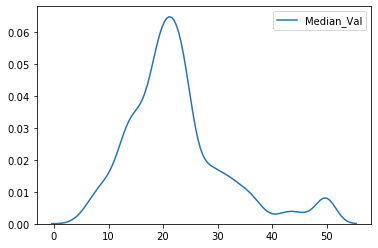

In [12]:
sns.kdeplot(df['Median_Val'])

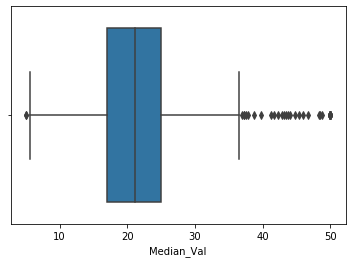

In [13]:
sns.boxplot(df['Median_Val'])

Looking at the all the features side by side, we can see that only Rooms, % of Lower Status people, Median Value are close to being normaly distributed. 

The "By_River" variable is a dummy variable with a boolean value. 

Crime rate, and the % of Large Plots have a large number of values close to zero which is understandable and doesn't set any alarm bells ringing about errors in the data.

The number of black people per 1000 tends towards the 40% mark, which again seems reasonable for a major US city and doesn't give any indication of errors in the data.

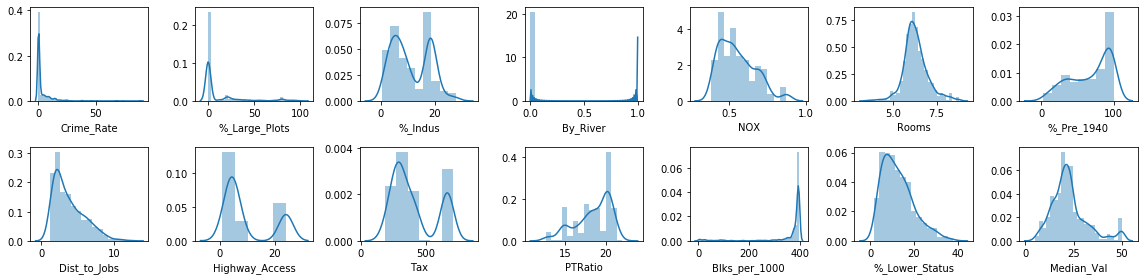

In [14]:
# distributions of the data
rows = 2
cols = 7

fig, ax = pyplt.subplots(nrows= rows, ncols= cols, figsize = (16,4))

col = df.columns
index = 0

for i in range(rows):
    for j in range(cols):
        sns.distplot(df[col[index]], ax = ax[i][j])
        index = index + 1

pyplt.tight_layout()

## 2.4 Relationships between the Variables

This next section will highlight any relationships between the data, beginning with creating a corrolation table.

In [15]:
corr_matrix = df.corr().round(2)
corr_matrix.style.background_gradient(cmap='coolwarm')

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
Crime_Rate,1,-0.2,0.41,-0.06,0.42,-0.22,0.35,-0.38,0.63,0.58,0.29,-0.39,0.46,-0.39
%_Large_Plots,-0.2,1,-0.53,-0.04,-0.52,0.31,-0.57,0.66,-0.31,-0.31,-0.39,0.18,-0.41,0.36
%_Indus,0.41,-0.53,1,0.06,0.76,-0.39,0.64,-0.71,0.6,0.72,0.38,-0.36,0.6,-0.48
By_River,-0.06,-0.04,0.06,1,0.09,0.09,0.09,-0.1,-0.01,-0.04,-0.12,0.05,-0.05,0.18
NOX,0.42,-0.52,0.76,0.09,1,-0.3,0.73,-0.77,0.61,0.67,0.19,-0.38,0.59,-0.43
Rooms,-0.22,0.31,-0.39,0.09,-0.3,1,-0.24,0.21,-0.21,-0.29,-0.36,0.13,-0.61,0.7
%_Pre_1940,0.35,-0.57,0.64,0.09,0.73,-0.24,1,-0.75,0.46,0.51,0.26,-0.27,0.6,-0.38
Dist_to_Jobs,-0.38,0.66,-0.71,-0.1,-0.77,0.21,-0.75,1,-0.49,-0.53,-0.23,0.29,-0.5,0.25
Highway_Access,0.63,-0.31,0.6,-0.01,0.61,-0.21,0.46,-0.49,1,0.91,0.46,-0.44,0.49,-0.38
Tax,0.58,-0.31,0.72,-0.04,0.67,-0.29,0.51,-0.53,0.91,1,0.46,-0.44,0.54,-0.47


As we can see from the above there are a number of variables that are strongly positively correlated, for example:

1. Tax and access to highways (0.91) - understandable as highways are paid for out of taxes.
2. NOX and the % of Industrial Land (0.76) - not very suprising that industrial areas would have high levels of NOX. 
2. NOX and the % of Pre 1940 houses (0.73) - possibly older houses would be burning coal.
3. Tax and the % of Industrial Land (0.71) 

There are also some strongly negatively correlated variables:

1. NOX and Distance to Jobs (-0.77) - makes sense as areas of employment are likely to be industrial and have more NOX. The further away you are, the better the air
2. % Pre 1940s houses and Distance to Jobs (-0.75) - makes sense as older areas are more likely to be located in the city centre near areas of employment. 
3. % Industrial and Distance to Jobs (-0.71) - same reasoning as point 1 above

In summary, there isn't anything unusual about the values in the correlation table that requires further investigation. 

Looking more closely at the correlation between the features and the target variable (Median House Prices), we can see that Rooms and % Lower Status are the most strongly corrolated. The rest of the variables are either moderately or weakly corrolated. This would indicate that the percentage of lower status people and the number of rooms are the best predictors of the housing prices. We will investigate this further later in this project.

In [16]:
median_val_corr = corr_matrix.iloc[-1]
median_val_corr.sort_values(ascending=True)

%_Lower_Status   -0.74
PTRatio          -0.51
%_Indus          -0.48
Tax              -0.47
NOX              -0.43
Crime_Rate       -0.39
%_Pre_1940       -0.38
Highway_Access   -0.38
By_River          0.18
Dist_to_Jobs      0.25
Blks_per_1000     0.33
%_Large_Plots     0.36
Rooms             0.70
Median_Val        1.00
Name: Median_Val, dtype: float64

Looking at below scatterplots of the different features vs the Median Value, Rooms and % of Lower Status People again stand out as having a relationship with it. 

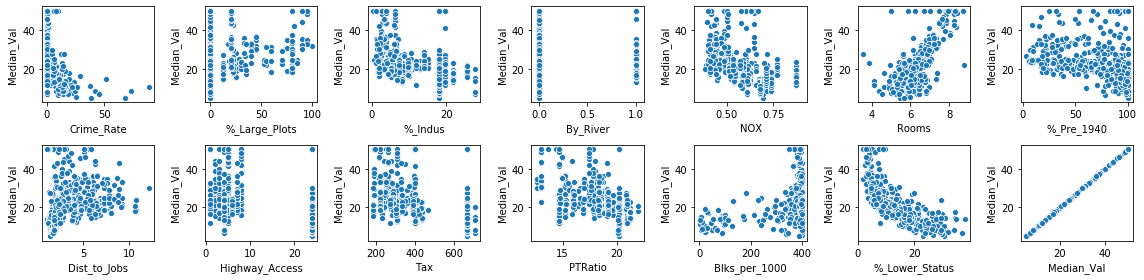

In [17]:
# scatter plots of the variables vs Median Value
rows = 2
cols = 7

fig, ax = pyplt.subplots(nrows= rows, ncols= cols, figsize = (16,4))

col = df.columns
index = 0

for i in range(rows):
    for j in range(cols):
        sns.scatterplot(df[col[index]], y="Median_Val", data=df, ax=ax[i][j])
        index = index + 1
        
        

pyplt.tight_layout()

Looking at the three most strongly corrolated values with the Median Value below, it's clear that the first two variables have a much more obvious relationship, while the Pupil Teacher ratio has much more noise.

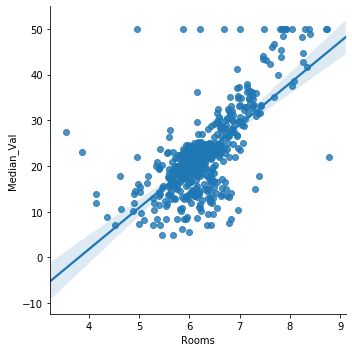

In [18]:
sns.lmplot(x="Rooms", y="Median_Val", data=df)

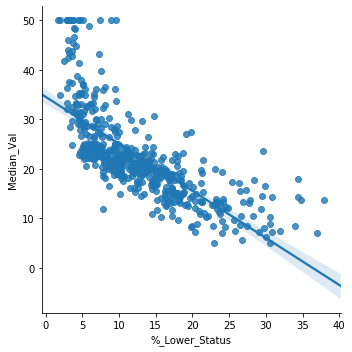

In [19]:
sns.lmplot(x="%_Lower_Status", y="Median_Val", data=df)

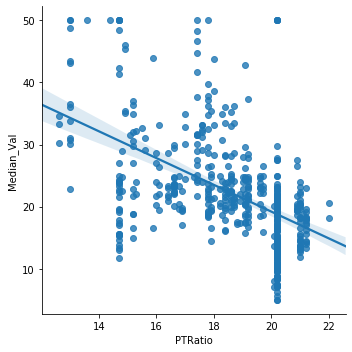

In [20]:
sns.lmplot(x="PTRatio", y="Median_Val", data=df)

## 2.5 Conclusions from the Descriptive Analytics

My main conclusions or items of note from this section are:

1. There are no null values in the data that will need to be dealt with.
2. There are some potential errors / outliers in the Median Values with 14 values being at the max value of $50,000
3. The only other two variables with a normal distribution are also the most strongly corrolated with the Median Value

# 3. Inferential Statistics

#### Objective 2: Analyse whether there is a significant difference between median house prices between houses that are along the Charles river and those that aren't.

The first attribute who's effect on housing prices that I was asked to investigate is whether the house is by the Charles River or not ("CHAS" or "By_River").

In the original paper this dataset was derived from, the authors assumed there would be a positive relationship between being next to the river and housing prices.

As I have shown above, there only seems to be a very week positive corrolation (0.18).

In order to investigate further I have performed a T-Test below.

## 3.1 Looking more closely at the  "By_River" variable

As we can see from the below histogram, there are significantly more areas in our dataset that are located away from the Charles river than next to the Charles River (35).  (471)

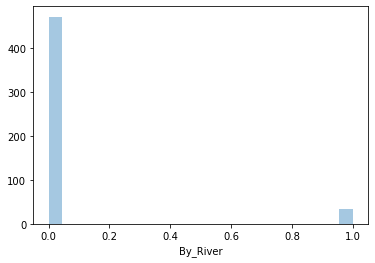

In [21]:
sns.distplot(df['By_River'], kde=False)

In [22]:
# getting the count of areas next to the Charles river
count_by_river = len(df[df['By_River'] == 1.0])
count_by_river

35

In [23]:
# getting the count of areas away from the Charles River
count_away_from_river = len(df[df['By_River'] == 0.0])
count_away_from_river

471

The exact count is:
* 35 next to the river 
* 471 away from the river

Looking at the distribution of the two categories we can see that the houses by the river would seems to have a higher percentage of more expensive houses. In addition, the cheapest house located away from the river.  

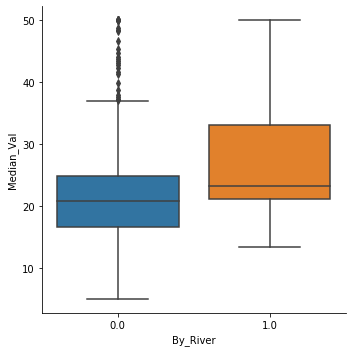

In [24]:
sns.catplot(x='By_River', y='Median_Val', kind='box', data=df)
# What do all the outliers mean

In [25]:
next_to_river = df[df['By_River'] == 1]
away_from_river = df[df['By_River'] == 0]

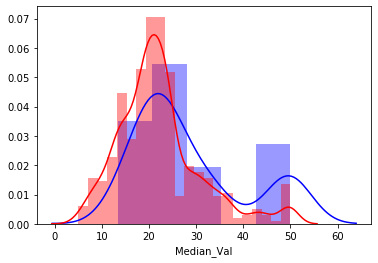

In [26]:
ax = sns.distplot(next_to_river['Median_Val'], color="blue")
ax = sns.distplot(away_from_river['Median_Val'], color="red")
pyplt.rcParams["figure.figsize"] = (20,20)

This is reflected in the descriptive statistics below with the "Next to River" values having a higher mean and mimimum value of than the areas that are located "Away from the River"

In [27]:
next_to_river["Median_Val"].describe()

count    35.000000
mean     28.440000
std      11.816643
min      13.400000
25%      21.100000
50%      23.300000
75%      33.150000
max      50.000000
Name: Median_Val, dtype: float64

In [28]:
away_from_river["Median_Val"].describe()

count    471.000000
mean      22.093843
std        8.831362
min        5.000000
25%       16.600000
50%       20.900000
75%       24.800000
max       50.000000
Name: Median_Val, dtype: float64

## 3.2 T-test Set-up

From the above plots and descriptive statistics it would seem that there does indeed to be some difference in the housing prices in areas along the Charles River vs those that aren't. A T-Test can be used to get futher confirmation of this (or indeed disprove this). 

### 3.2.1 Why use a T-Test?

A T-test is used to compare the means of two samples when the parameters of the population as a whole are not known. Using it will allow us to prove or reject the below Null Hypothosis and Alternative Hypothosis [14].

1. The Null Hypothesis is that there is no significant difference between houses along the Charles River and those that aren't.

2. The Alternative Hypothesis is that there is a significant difference between these two groups. 



### 3.2.2 T-Test Requirements

Before we can apply a T-Test, it is first necessary to ensure that our datasets meets the requirements:

|#|Requirement|Pass|Reasoning|
|:------------------------|:---------|:-----------|:-----------|
|1|Dependent variable should be measured on continuous scale|YES|Median Value is measured on continuous scale of 0-50|
|2|Independent variable should consist of two categorical independant groups|YES|Areas are either by or not by the river|
|3|Independence of observations|YES|None of the areas appear twice and no house appears in more than one area|
|4|There should be no significant outliers|NO|There are a number of outliers in the Median Values of houses not by the river|
|5|Dependent variable should be approximately normally distributed for each group|UNKNOWN|At first glance yes, but we will need to test to be sure|
|6|Needs to be homogeneity of variances|UNKNOWN|We will also need to test for this|


As you can see above, the first three requirements were met, but the 4th requirement was failed and the 5th and 6th requirements required further investigation before we can continue with out T-Test.

#### 3.2.2.1 Removing Outliers

As I mentioned earlier in this project, the "Median Val" variable has many outliers. This is clearly displayed in the Boxplot below. 

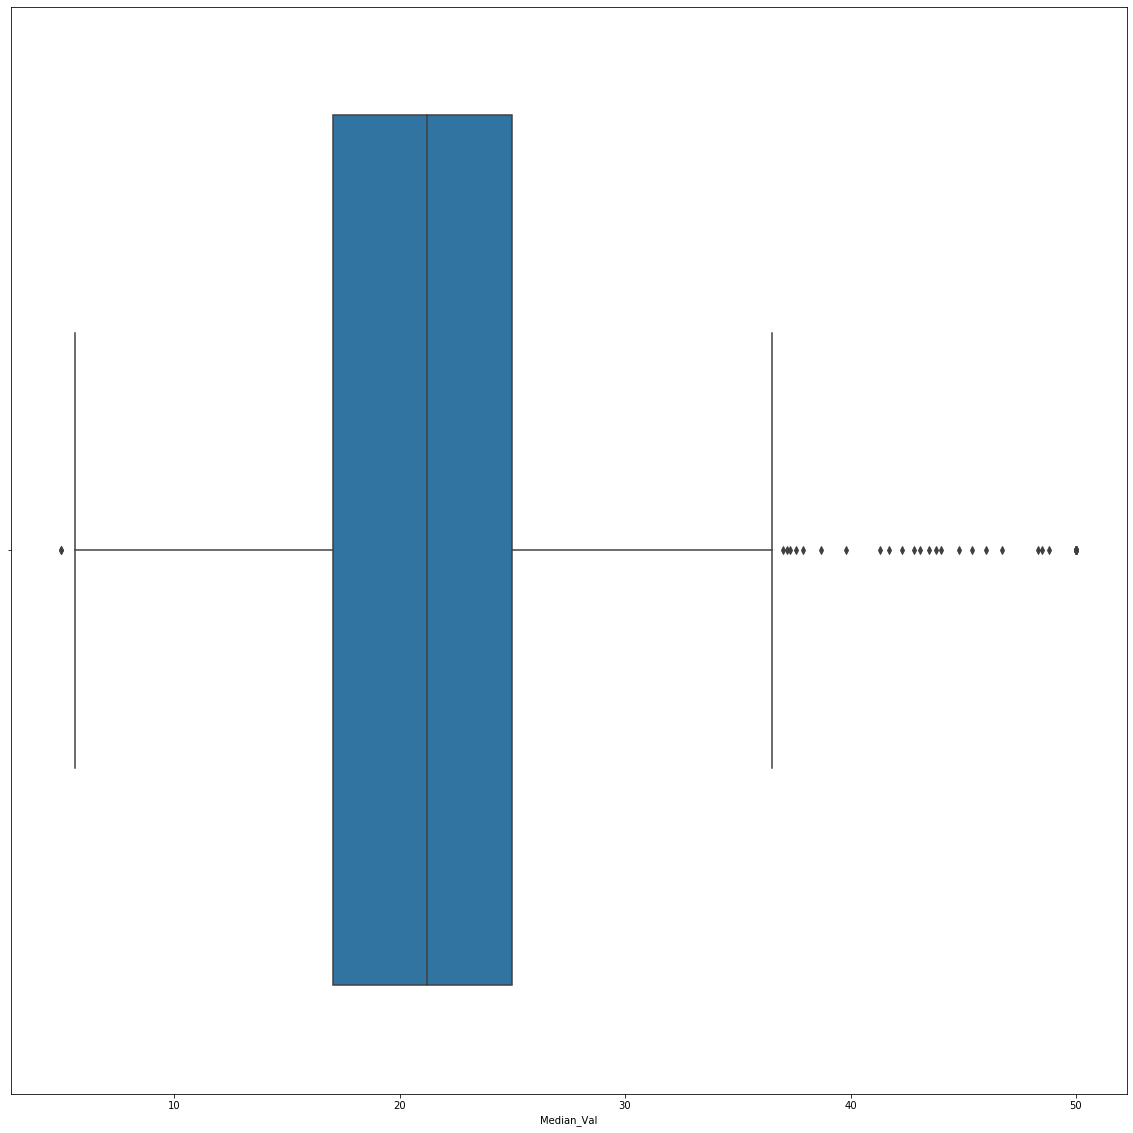

In [29]:
sns.boxplot(df['Median_Val'])

In [30]:
df["Median_Val"][df["Median_Val"] ==50].count()

16

There are also 16 areas where the median value of houses is $50,000, but nothing higher that this value. This could indicate  that there might be a cap on values in the dataset at this value or that this value was entered where accurate information was not available. We could just remove these values, but first I will investigate how many outliers there are in total.

In order to identify the outliers I have assigned a threshold for the Median Value, above or below which i have consider the data point to be an outlier. The most obvious way to do this is to follow the same method as the box-plot and remove an datapoints that are outside of the 75th and 25th percentiles. The Pandas library has a built in quantile method that can be used to calculate these thresholds.

In [31]:
Q1 = df['Median_Val'].quantile(0.25)
Q1

17.025

In [32]:
Q3 = df['Median_Val'].quantile(0.75)
Q3

25.0

In [33]:
IQR = Q3 - Q1
IQR

7.975000000000001

Having calculated the interquartile range, this was then used find the upper and lower "whisker" values for the box plot which will acts as the "outlier thresholds".

In [34]:
# calculate where the tip of the lower boxplot whisker is
lower_thresh = Q1 - 1.5 * IQR
lower_thresh

5.0624999999999964

In [35]:
# calculate where the tip of the upper boxplot whisker is
upper_thresh = Q3 + 1.5 * IQR
upper_thresh

36.962500000000006

In [36]:
# show all values that are below the lower outlier threshold
below = df.loc[df['Median_Val'] < lower_thresh]
below

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
398,38.3518,0.0,18.1,0.0,0.693,5.453,100.0,1.4896,24.0,666.0,20.2,396.90,30.59,5.0
405,67.9208,0.0,18.1,0.0,0.693,5.683,100.0,1.4254,24.0,666.0,20.2,384.97,22.98,5.0


There were two data points below the lower threshold.

In [37]:
# show all values that are above the upper outlier threshold
above = df.loc[df['Median_Val'] > upper_thresh]
above

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
97,0.12083,0.0,2.89,0.0,0.4450,8.069,76.0,3.4952,2.0,276.0,18.0,396.90,4.21,38.7
98,0.08187,0.0,2.89,0.0,0.4450,7.820,36.9,3.4952,2.0,276.0,18.0,393.53,3.57,43.8
157,1.22358,0.0,19.58,0.0,0.6050,6.943,97.4,1.8773,5.0,403.0,14.7,363.43,4.59,41.3
161,1.46336,0.0,19.58,0.0,0.6050,7.489,90.8,1.9709,5.0,403.0,14.7,374.43,1.73,50.0
162,1.83377,0.0,19.58,1.0,0.6050,7.802,98.2,2.0407,5.0,403.0,14.7,389.61,1.92,50.0
163,1.51902,0.0,19.58,1.0,0.6050,8.375,93.9,2.1620,5.0,403.0,14.7,388.45,3.32,50.0
166,2.01019,0.0,19.58,0.0,0.6050,7.929,96.2,2.0459,5.0,403.0,14.7,369.30,3.70,50.0
179,0.05780,0.0,2.46,0.0,0.4880,6.980,58.4,2.8290,3.0,193.0,17.8,396.90,5.04,37.2
180,0.06588,0.0,2.46,0.0,0.4880,7.765,83.3,2.7410,3.0,193.0,17.8,395.56,7.56,39.8
182,0.09103,0.0,2.46,0.0,0.4880,7.155,92.2,2.7006,3.0,193.0,17.8,394.12,4.82,37.9


In [38]:
above["Median_Val"].count()

38

There were 38 datapoints that were higher that the upper threshold. Using these thresholds I created a dataset of data that was within these two thresholds called "no_outliers".

In [39]:
no_outliers = df[((df['Median_Val'] > lower_thresh) & (df['Median_Val'] < upper_thresh))]
no_outliers

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


Comparing the two groups with the outliers removed shows that the median values of the two groups was now much closer together, but the range of values in the "Away from River" group was still much wider.

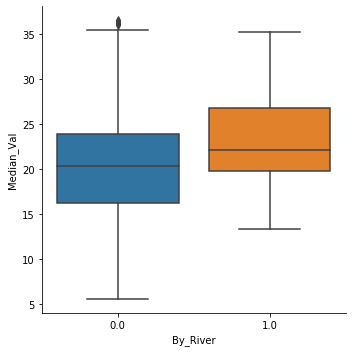

In [40]:
sns.catplot(x='By_River', y='Median_Val', kind='box', data=no_outliers)

#### 3.2.2.2 Determining if the Dependant Variable is Approxmately Normally Distributed in Each Group.

In order to test this I created two new groups from the "no_outliers" dataset:
1. Next to River
2. Away from River

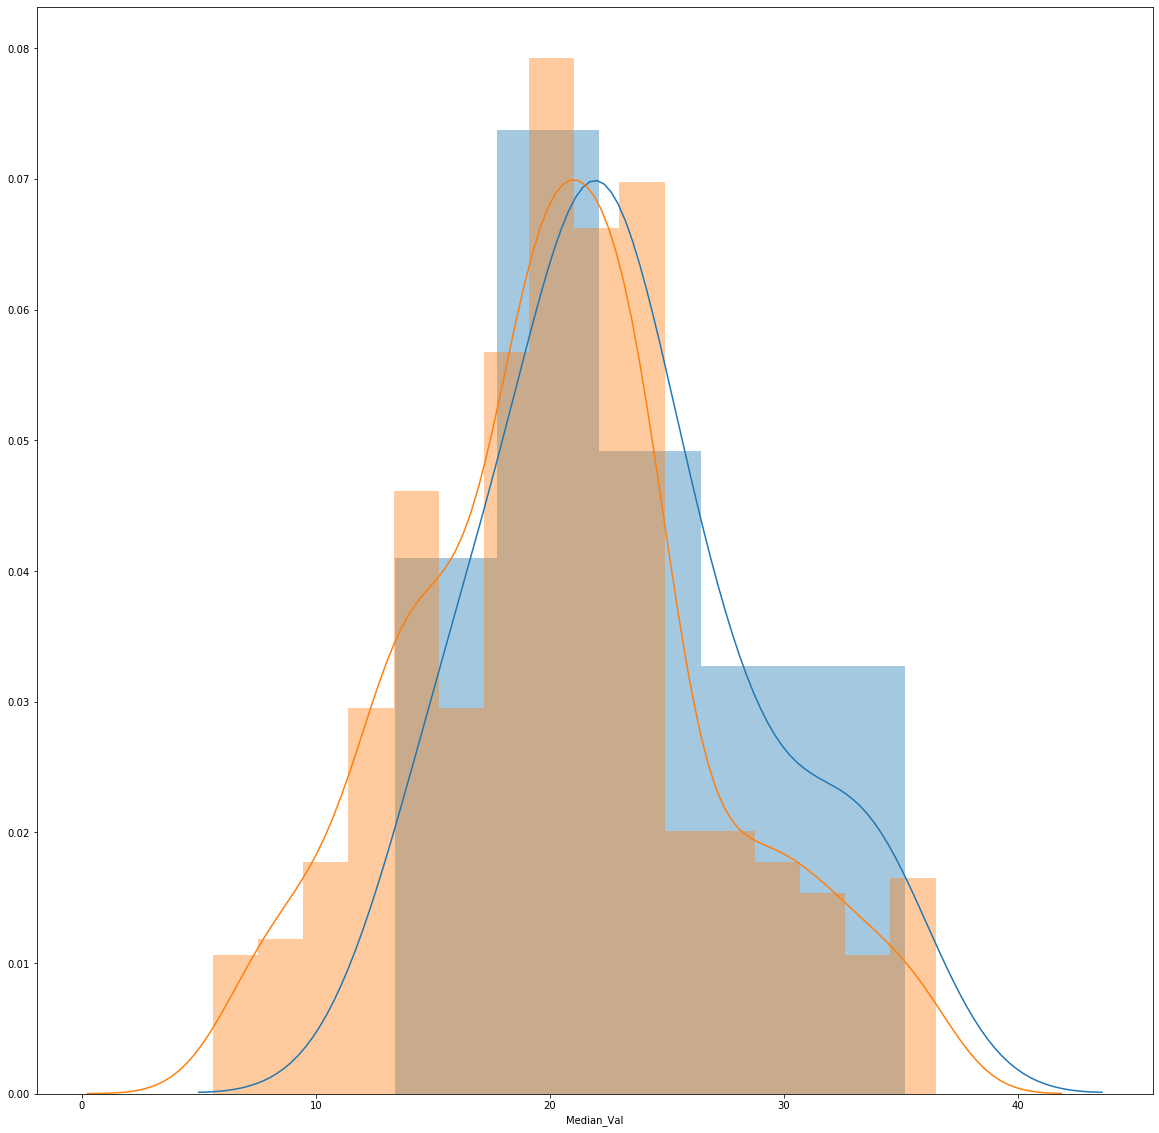

In [41]:
cleansed_next_to_river = no_outliers[no_outliers['By_River'] == 1]
cleansed_away_from_river = no_outliers[no_outliers['By_River'] == 0]

ax = sns.distplot(cleansed_next_to_river['Median_Val'])
ax = sns.distplot(cleansed_away_from_river['Median_Val'])
pyplt.rcParams["figure.figsize"] = (20,20)

From looking at the two "cleansed" group it can be observed that both are much closer to appearing to be normally distributed than the original dataset with the outliers included.

I performed a further test using Scipys "normaltest" method to confirm this.

In [42]:
from scipy import stats
next_to_river_Ntest = stats.normaltest(cleansed_next_to_river['Median_Val'])
away_from_river_Ntest = stats.normaltest(cleansed_away_from_river['Median_Val'])
print(next_to_river_Ntest)
print(away_from_river_Ntest)


NormaltestResult(statistic=1.289316190319236, pvalue=0.5248419574390437)
NormaltestResult(statistic=3.405851916816045, pvalue=0.1821497808954563)


For both groups the Pvalue is greater than the alpha threshold(0.05). I can therefore be said the no significant departure from normality was found [15].

#### 3.2.2.3 Homogenity of Variances

Homogeneity of variance is an assumption underlying t tests in which the population variances (i.e., the distribution, or “spread,” of scores around the mean) of two or more samples are considered equal. In correlations and regressions, the term “homogeneity of variance in arrays,” also called “homoskedasticity,” refers to the assumption that, within the population, the variance of Y for each value of X is constant.

In order to perform a valid t-test it is necessary to check if both samples have similar variances. Levenes test can be used to do this. It tests the null hypothosis that variances are equal. 

In [43]:
stats.levene(cleansed_next_to_river['Median_Val'], cleansed_away_from_river['Median_Val'])

LeveneResult(statistic=0.7964820987689898, pvalue=0.3726098479576784)

The P-value is greater than the threshold of 0.05 so it can be said that there is no signifcant difference in the variances of both groups.

In [44]:
# variance of median values of houses next to the river
print(np.var(cleansed_next_to_river['Median_Val']))

31.402091836734694


In [45]:
# variance of values of house in areas away from the river
print(np.var(cleansed_away_from_river['Median_Val']))

41.76279086132484


#### 3.2.2.4 Summary of T Test Requirement Statuses

|#|Requirement|Pass|Reasoning|
|:------------------------|:---------|:-----------|:-----------|
|1|Dependent variable should be measured on continuous scale|YES|Median Value is measured on continuous scale|
|2|Independent variable should consist of two categorical independant groups|YES|Areas are either by or not by the river|
|3|Independence of observations|YES|None of the areas appear twice and no house appears in more than one area|
|4|There should be no significant outliers|YES|There were originally, but they have been removed.|
|5|Dependent variable should be approximately normally distributed for each group|YES|Both groups are approximately normally distrubuted.|
|6|Needs to be homogeneity of variances|YES|There is homogenity of variances|


### 3.3 T Test Results

Since all the requirements were met, it was appropriate to proceed with the T Test.

In [46]:
stats.ttest_ind(cleansed_next_to_river['Median_Val'], cleansed_away_from_river['Median_Val'])

Ttest_indResult(statistic=2.100509858104912, pvalue=0.03622310352018016)

The purpose of the current section was to test if there is a significant difference in the Median Value of House Prices between the house prices in areas by or not by the Charles River in Boston.

In [47]:
import researchpy as rp

tt_descriptives, tt_results = rp.ttest(cleansed_next_to_river['Median_Val'], cleansed_away_from_river['Median_Val'])

tt_descriptives

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Median_Val,28.0,23.192857,5.706587,1.078444,20.980074,25.405640
1,Median_Val,438.0,20.560959,6.469804,0.309139,19.953375,21.168543
2,combined,466.0,20.719099,6.451416,0.298856,20.131823,21.306374


In [48]:
tt_results

,Independent t-test,results
0,Difference (Median_Val - Median_Val) =,2.6319
1,Degrees of freedom =,464.0000
2,t =,2.1005
3,Two side test p value =,0.0362
4,Difference < 0 p value =,0.9819
5,Difference > 0 p value =,0.0181
6,Cohen's d =,0.4095
7,Hedge's g =,0.4088
8,Glass's delta =,0.4612
9,r =,0.0971


The results of the test showed a P-value of 0.0362. This is lower than the 0.05 threshold giving a strong indication that we can reject the null hypothesis that there is no difference between Median Value of houses in areas that are by or away from the Charles River in Boston. If the value was greater than 0.05 this would indicate that there was no difference between the two groups.

It can therefore be concluded that there is a significant difference between the housing prices for houses along the Charles River and those not along the Charles River.

# 4. Predicting House Prices using a Neural Network


#### Objective 3: Predict the median house price based on the other variables in the dataset using neural network

## 4.0 Overview

In this section, I have built a model for a neural network that has gone through several iterations in order to determine which configuration of the model was delivering the best predictions.

Before creating the model I did several preprocessing steps to prepare the training and test data. Following that I created a "baseline" model to measure subsequent iterations performance against.

I then outlined the different elements of the model that could be adjusted and tested to see if they could improve performance. 

Following that I created and tested several different versions of the model, changing one key element each time e.g. number of epochs, layers size etc with an attempt at further tuning using Principal Component Analysis and Feature Selection.

Finally, I selected the best performing model from the various iteration as my final model.

**NOTE:** *I have commented out the code for several of the model testing functions below. Some of these can take quiet some time to run, so I felt it was safest to comment them out in case someone was to use the "Rull All" option.*

## 4.1 Pre-Processing

Before proceeding with the creation of the model it is necessary to ensure the data is as error free as possible and in the right format for feeding into the model.

In this project I took the following pre-processing steps:

1. Dealt with any Null values
2. Dealt with Categorical Variables
3. Standardised the Data

It should be noted that record with an outlier in the Median Value variable have already been removed during the preperation for the T-Test above. 


### 4.1.1 Null Values

First I checked to see if the cleansed dataset contained any Null values. If there were Null values, the row containing the value will be need to be removed or the value would have needed to be replaced.

In [49]:
no_outliers.isnull().sum()

Crime_Rate        0
%_Large_Plots     0
%_Indus           0
By_River          0
NOX               0
Rooms             0
%_Pre_1940        0
Dist_to_Jobs      0
Highway_Access    0
Tax               0
PTRatio           0
Blks_per_1000     0
%_Lower_Status    0
Median_Val        0
dtype: int64

However, as can be seen from the table above, there were no null values.

### 4.1.2 Check for Categorical Variables

As we have already seen there is one categorical variable in the dataset showing whether the area is located next to or away from the Charles River.

Luckily this has already been coverted into a "dummy variable" of 0 for No and 1 for Yes. Therefore, it was not necessary to have to do any encoding or processing of this variable.

In [50]:
no_outliers["By_River"]

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
501    0.0
502    0.0
503    0.0
504    0.0
505    0.0
Name: By_River, Length: 466, dtype: float64

### 4.1.3 Standardise  the Data

Standardisation means transforming all values in a dataset so that the means of the values is 0 and the standard deviation is 1.

This helps to prevent a machine learning model from giving a different weight to values that are at a different scale to other values. For example, looking at the below shows that variables like the number of black people per 1000 is always going to be higher than the number of Rooms in a house or the Pupil Teacher Ratio.

In [51]:
no_outliers.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Before the data was scaled it needed to be split into the independent and dependent variables for the model.

#### 4.1.3.1 Shuffling the Data

Before splitting the data it was also suffled. This is more important in classification tasks where the dataset is sorted by class, but it is also good to ensure all of the data from a particular area didn't end up in just the training dataset and not the test dataset. Following that, the data was split into the input and taget variables for the model.

In [52]:
no_outliers = shuffle(no_outliers)

In [53]:
# create the input from the first 13 variables
# output is the Median Value
x_input = no_outliers.iloc[:, 0:13]
y_output = no_outliers["Median_Val"]

#### 4.1.3.2 Splitting into Test and Training Sets

The data then needed to be split into the testing and training sets. For this project I have used a 80:20 train:test split. 

Sklearn's model selection tool for can be used to perform the split. 

In [54]:
#train test splitting
x_train, x_test, y_train, y_test = mod.train_test_split(x_input, y_output, test_size=0.2)

In [55]:
x_train.iloc[0] # snapshot of a single row of data

Crime_Rate          0.06466
%_Large_Plots      70.00000
%_Indus             2.24000
By_River            0.00000
NOX                 0.40000
Rooms               6.34500
%_Pre_1940         20.10000
Dist_to_Jobs        7.82780
Highway_Access      5.00000
Tax               358.00000
PTRatio            14.80000
Blks_per_1000     368.24000
%_Lower_Status      4.97000
Name: 298, dtype: float64

#### 4.1.3.3 Standarising the Data

Once the data was split into testing and training sets was standardised / scaled.


In [56]:
scaler = pre.StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_input.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_input.columns)

In [57]:
x_train.iloc[0]

Crime_Rate       -0.425603
%_Large_Plots     2.648160
%_Indus          -1.341755
By_River         -0.250713
NOX              -1.312599
Rooms             0.258608
%_Pre_1940       -1.680503
Dist_to_Jobs      1.862056
Highway_Access   -0.546425
Tax              -0.335786
PTRatio          -1.797004
Blks_per_1000     0.130573
%_Lower_Status   -1.191322
Name: 0, dtype: float64

In [58]:
x_train.describe().round()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status
count,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0,372.0
mean,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-0.0,-0.0,-1.0,-0.0,-1.0,-4.0,-2.0,-1.0,-1.0,-1.0,-3.0,-4.0,-2.0
25%,-0.0,-0.0,-1.0,-0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0
50%,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-1.0,-0.0,0.0,0.0,-0.0
75%,0.0,0.0,1.0,-0.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,1.0
max,10.0,4.0,2.0,4.0,3.0,5.0,1.0,4.0,2.0,2.0,2.0,0.0,4.0


##  4.2 Baseline prediction test

After the data processing was complete, it was possible to proceed with the creation of a baseline model. For the baseline model I added:
1. An input layer with a number of units equal to the number of input features in the dataset.
2. An output layer with one unit as the model is only supposed to produce one output value.
3. 100 epochs - number chosen at random
4. A batch size of 5 - number chosen at random

In [59]:
# Defining the Baseline test model
m = ks.models.Sequential()
m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(1))
m.compile(loss="mean_squared_error", optimizer="adam")


In [60]:
m.fit(x_train, y_train, epochs=100, batch_size=5)

Epoch 1/100
372/372 [==============================] - 1s 4ms/step - loss: 481.2464
Epoch 2/100
372/372 [==============================] - 0s 403us/step - loss: 442.6118
Epoch 3/100
372/372 [==============================] - 0s 378us/step - loss: 404.1928
Epoch 4/100
372/372 [==============================] - 0s 400us/step - loss: 362.6459
Epoch 5/100
372/372 [==============================] - 0s 317us/step - loss: 317.9414
Epoch 6/100
372/372 [==============================] - 0s 331us/step - loss: 273.2195
Epoch 7/100
372/372 [==============================] - 0s 338us/step - loss: 230.0394
Epoch 8/100
372/372 [==============================] - 0s 322us/step - loss: 190.0374
Epoch 9/100
372/372 [==============================] - 0s 314us/step - loss: 153.9941
Epoch 10/100
372/372 [==============================] - 0s 363us/step - loss: 122.3686
Epoch 11/100
372/372 [==============================] - 0s 381us/step - loss: 95.5535
Epoch 12/100
372/372 [==============================] -

372/372 [==============================] - 0s 249us/step - loss: 5.2717
Epoch 97/100
372/372 [==============================] - 0s 292us/step - loss: 5.2099
Epoch 98/100
372/372 [==============================] - 0s 365us/step - loss: 5.1678
Epoch 99/100
372/372 [==============================] - 0s 382us/step - loss: 5.2510
Epoch 100/100
372/372 [==============================] - 0s 352us/step - loss: 5.1537


In [61]:
# show the predicted prices for the test input variables
MedianVal_prediction = m.predict(x_test).T
MedianVal_prediction

array([[18.790672 , 14.174958 , 16.156298 , 17.521519 , 26.306858 ,
        30.153229 , 11.299565 , 15.57504  , 23.303131 , 30.491047 ,
        11.91502  , 16.927902 , 10.888394 , 13.542321 , 14.863542 ,
        12.215006 , 19.420828 , 15.795203 , 24.898424 , 18.046133 ,
        16.89139  , 17.366547 , 23.458815 , 23.365826 , 26.960606 ,
        31.970993 , 17.57568  , 27.658934 , 11.007024 , 21.82331  ,
        33.24808  , 24.987251 , 13.404402 , 16.30142  , 10.874898 ,
        16.944113 , 19.239073 , 20.451555 , 18.151    , 25.871433 ,
        22.294926 , 21.256655 , 19.48195  , 14.2741785, 17.30346  ,
        15.501467 , 30.129278 , 22.545124 , 25.643074 , 32.908203 ,
        21.53864  , 23.213379 , 21.34841  , 11.879979 , 17.630018 ,
        16.900974 , 25.16571  , 20.040361 , 15.664184 , 30.332205 ,
        12.917784 , 32.19642  , 12.515582 , 21.669617 , 15.182123 ,
        31.772255 , 12.585577 , 26.236511 , 16.09715  , 15.473115 ,
        22.591194 , 13.875452 ,  8.725838 , 20.0

In [62]:
#show the real values
MedianVal_real = y_test.as_matrix().astype(np.float32)
MedianVal_real

d:\data_analytics\machine_learning_stats\machinelearning-and-statistics-project\venv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


array([19.3, 17.8, 15.2, 17.5, 24.5, 34.9, 27.5, 13.9, 22.2, 36.2, 14.4,
       13.1, 10.9, 13.5, 15.4, 15. , 16.2, 14.8, 27. , 21.5, 16. , 19.6,
       21.5, 25. , 29. , 31.7, 19.5, 26.6, 17.2, 22.2, 36.1, 24.7, 13.3,
       16.1,  8.3, 11.7, 18.8, 23.1, 27.1, 22. , 20.8, 11.9, 19.6, 12.1,
       20.1, 13.1, 30.7, 20.6, 25.2, 34.9, 20.5, 20.6, 16.6, 13.2, 14.4,
       19.5, 24.4, 17.1, 18.4, 31.5, 11. , 33.2,  9.7, 19.6, 19.1, 31.5,
       12.8, 22. , 19. , 18.9, 21.6, 13.4,  8.4, 22.5, 32.7, 13.4, 19.7,
       16.5, 28.1, 23.6, 20. , 13.6, 21.7, 13.6, 20.9, 12.7, 23. ,  7.4,
       25. , 23.4, 27.5, 21.7, 22.7, 22.6], dtype=float32)

In [63]:
# Show prediction vs real side by side with difference between the two
predicted_V_real_df = pd.DataFrame({'Prediction': MedianVal_prediction.ravel(), 'Real_value': MedianVal_real.ravel()})
predicted_V_real_df['%Difference'] = 100*(abs(predicted_V_real_df['Prediction'] - predicted_V_real_df['Real_value'])/predicted_V_real_df['Prediction'])
predicted_V_real_df

,Prediction,Real_value,%Difference
0,18.790672,19.299999,2.710531
1,14.174958,17.799999,25.573557
2,16.156298,15.200000,5.919041
3,17.521519,17.500000,0.122813
4,26.306858,24.500000,6.868392
...,...,...,...
89,23.915743,23.400000,2.156501
90,23.849691,27.500000,15.305476
91,20.894880,21.700001,3.853195
92,20.737617,22.700001,9.462916


In [64]:
# average of the percentage difference
predicted_V_real_df['%Difference'].mean()

13.272456

In [65]:
# Evaluate the accuracy 
m.evaluate(x_test, y_test)

94/94 [==============================] - 0s 340us/step


10.855485195809223

The initial baseline test I performed showed an average of a 10.7% diffence between the real and predicted test values and an MSE value of 7.3. As can be seen in the following iteration, I found it very difficult to improve this value significantly. 

## 4.3 Factors Considered When Creating Further Models

Before progressing further with project and creating new models, I looked at the main elements that make up a model, what role they perform, and the potential effects of changing them.

### 4.3.1 Model Selection

I used the Sequential Model for all models in ths project. This is "default" model for Keras. It functions by adding sequential layers of neurons. Inputs are fed into the first layers with outputs being passed on to subsequent layers. 

In the Baseline Test I have just added an input later that takes in 13 variables, and an output layers that gives out a single values (Y).

There is also the option to create custom "functional models" in Keras, but this was not necessary for the purposes of this project.

### 4.3.2 Density

This is the layer type. In this type all nodes/neurons in the next layer are connected to all nodes in the previous layer. This is the best layer type for this projects use case. However, other layer types exist, such as Convolutional Layers (used for image prediction) and Recurrent Layers (used for time series data). I saw no reason to change this for the different models in this project.

### 4.3.3 Number of Layers

For the baseline I have added 1 input later and 1 output layer. This is the absolute minimum number a model can have. There is also an single "hidden layer" automatically created from the outputs of the input layer.

In the case of linear and generalized linear models, having no hidden layers is enough and increasing this number doesn't necessarily improve the performance of the model. However, if there are mutliple inputs (such as in our data) having up to 2 hidden layers can help to improve accuracy, but there is no set rules for what will deliver the best results. [1][2]. 

I have added additional layers in later iterations of the model.

### 4.3.4 Number of Units per Layer

The number of input units should match the number of variables being inputted while the number of output units should match the number of outputs required. In this projects dataset there are 13 input variables with 1 output required. This is what was entered into the Baseline test.

The number of units in a hidden layer depends on a number of factors [3]:

* the numbers of input and output units 
* the number of training cases 
* the amount of noise in the targets 
* the complexity of the function or classification to be learned 
* the architecture 
* the type of hidden unit activation function 
* the training algorithm 
* regularization 
 
Having too few or too many hidden units can result in underfitting and overfitting respectively, reducing accuracy. 

There are some rules of thumb such for layer sizes such as:
* somewhere between the size of the input and output layer
* (inputs + outputs) x 2/3
* never more than twice the number of the input layer

However, these fail to take account of size of the training dataset and other considerations [3]. 

I have experimented with different layer sizes in the models below.



### 4.3.5 Activation Functions

Choosing an appropriate activation function is one of the most important considerations when designing a model. An activation function is the non-linear transformation that is performed on the input data to create the output. In the absense of an activation function the model is just a linear regression model[4].

Different activation functions have different use cases. For example, Binary Step Functions is used in classification where there are only two choices. This was obviously not suitable for this project's dataset, but there were several others that were worth considering. 

##### Linear 
* Assumes input is proportional to output 
* Only suitable for simple tasks as each layer in the model only does a linear transformation of the output of the previous layer and passes it on.
* This is also the default function in Keras if no other function is specified.

##### Sigmoid 
* Non-linear
* Tries to push Y values to extremes making it useful for classification

##### Tanh 
* Essentially a scaled version of the Sigmoid function

##### ReLU
* The most widely used activation function.
* Full name is Rectified Linear Unit
* It's non-linear allowing for back propigation of erros. 
* Allows for mutliple layers activated by the ReLU function. 
* ReLu should only be used in hidden layers and not the output layer.

As a rule of thumb, ReLu should be the first port of call when creating a model. If it's results are not optimal, then other functions can be considered [7]. This is why ReLU was used in the Baseline Model. The output was left as the default linear function.




### 4.3.6 Loss Function

This is the method used to find the error between the actual values and predicted value. Different metrics are used for different use cases. 

For regression problems the best option is "mean-squared error", which is what was used in the various models in this project [6].

### 4.3.7 Optimizer

Optimizers try to minimise the loss function and make predictions as correct as possible. They do this by updating the model in response to the output of the loss function[10]. 

Adam is generally recommended as the best optimizer to use [8] along with SGD using Nestorov momentum[9]. I have used Adam in the baseline model and given that Adam incorporates many of the good features of SGD I did not think there would be much value in using other optimizers.

### 4.3.8 Epochs

An epoch is single pass of the entire training dataset through a machine learning model.

One pass is not enough as the model is learning each time the model is passed through. If there are too many epochs the model will go from underfitting to overfitting. That being said, there is no fixed rule on how many epochs is best for a given dataset [11]. 

In the Baseline Model I set the model to perform 100 epochs. I tried larger numbers of epochs in later iterations. 

### 4.3.9 Batch Size

The batch size is the number of samples processed before the model is updated. For example, in the Baseline Model the batch size is 5. There are 372 samples (rows) in the training dataset so the date will be divided into 74 batches each with 5 rows. Therefore, each epoch will involved 74 updates to the model. 

Generally, batch sizes are set to values that are to the power of 2 e.g. 32, 64, 128 etc. A good default batch size is 32 with smaller batches tending to give better results [12]. 

I have tried several different batch sized in the models below.


## 4.4 Model Tuning

In this section I tested changes to the model based on some of the possible improvements discussed above:

1. Decreasing batch sizes beginning at 32
2. Increasing number of epochs starting at 100
3. Varied Layer Sizes
4. Increased numbers of layers

I did not be change:
1. Activation functions
2. Loss function
3. Optimizer

I attempted to test this in an empirical fashion, changing one parameter at a time and testing to see if it resulted in any improvements vs the Baseline.

### 4.4.1 Batch Sizes

In this section I tested various batch sizes while keeping all other model parameters the same as the Baseline Model.

###### Test 1-  Increasing Batch Size to 32


In [66]:
# Test 1
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# m.fit(x_train, y_train, epochs=100, batch_size=32)

# batch_test1_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_batch1 = m.evaluate(x_test, y_test)

In [67]:
# result_batch1

**Result:** Rejected - MSE increased to 26.539871296984085

###### Test 2 - Batch Size to 16

In [68]:
# Test 2
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# m.fit(x_train, y_train, epochs=100, batch_size=16)

# batch_test1_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_batch2 = m.evaluate(x_test, y_test)

In [69]:
# result_batch2

**Result:** Rejected - MSE increased to 12.633492307460054

###### Test 3 - Batch Size to 4

In [70]:
# Test 3
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# m.fit(x_train, y_train, epochs=100, batch_size=4)

# batch_test1_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_batch3 = m.evaluate(x_test, y_test)

In [71]:
# result_batch3

**Result:** Possible candidate. MSE of 7.892184135761667 is closer to the baseline

###### Test 4 - Batch Size to 2

In [72]:
# Test 4
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# m.fit(x_train, y_train, epochs=100, batch_size=2)

# batch_test1_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_batch4 = m.evaluate(x_test, y_test)

In [73]:
# result_batch4

**Result:** Possible candidate. MSE of 8.877476955981965 is slightly worse than the baseline.

#### 4.4.1.1 Commentary

I tested batch sizes multiple times and the results for 2 vs 4 batches was inconclusive. Sometimes 2 performed better and sometimes 4 performed better.

In order to get a more conclusive answer I test each five times and got the average of the tests.

In [74]:
# function to test batch sizes with 10 test and average of results

# def batchsize_test(tests, b_size):
#     counter = 0
#     resultslist = []
#     while counter < tests:
#         m = ks.models.Sequential()
#         m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
#         m.add(ks.layers.Dense(1))

#         m.compile(loss="mean_squared_error", optimizer="adam")

#         m.fit(x_train, y_train, epochs=100, batch_size=b_size)

#         batch_test1_prediction = m.predict(x_test).T

#         MedianVal_real = y_test.as_matrix().astype(np.float32)

#         result_batch3 = m.evaluate(x_test, y_test)
#         counter += 1
#         resultslist.append(result_batch3)
#     avg_result = sum(resultslist) / tests
#     return avg_result

#print(batchsize_test(5, 2))

In [75]:
#print(batchsize_test(5, 4))

###### Result of tests:

A batch size of 2 seemed to perform marginally better. Given that this project  dealt with a relatively small dataset memory wasn't an issue so  there was no reason not to use the smaller batch size. 

### 4.4.2 Number of Epochs

In this section I tested different epoch sizes.

###### Test 1 - 500 Epochs

In [76]:
# Test 1
m = ks.models.Sequential()
m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(1))

m.compile(loss="mean_squared_error", optimizer="adam")

history = m.fit(x_train, y_train, epochs=500, batch_size=2)

epoch_test1_prediction = m.predict(x_test).T

MedianVal_real = y_test.as_matrix().astype(np.float32)

result_epochv1 = m.evaluate(x_test, y_test)

Epoch 1/500
372/372 [==============================] - 0s 1ms/step - loss: 484.5324
Epoch 2/500
372/372 [==============================] - 0s 805us/step - loss: 391.5823
Epoch 3/500
372/372 [==============================] - 0s 786us/step - loss: 284.1488
Epoch 4/500
372/372 [==============================] - 0s 792us/step - loss: 179.5243
Epoch 5/500
372/372 [==============================] - 0s 793us/step - loss: 103.6007
Epoch 6/500
372/372 [==============================] - 0s 737us/step - loss: 60.7426
Epoch 7/500
372/372 [==============================] - 0s 710us/step - loss: 39.8399
Epoch 8/500
372/372 [==============================] - 0s 701us/step - loss: 29.1135
Epoch 9/500
372/372 [==============================] - 0s 695us/step - loss: 23.2968
Epoch 10/500
372/372 [==============================] - 0s 726us/step - loss: 19.9260
Epoch 11/500
372/372 [==============================] - 0s 616us/step - loss: 17.8444
Epoch 12/500
372/372 [==============================] - 0s 7

372/372 [==============================] - 0s 838us/step - loss: 4.6262
Epoch 98/500
372/372 [==============================] - 0s 871us/step - loss: 4.5156
Epoch 99/500
372/372 [==============================] - 0s 822us/step - loss: 4.5400
Epoch 100/500
372/372 [==============================] - 0s 757us/step - loss: 4.4842
Epoch 101/500
372/372 [==============================] - 0s 708us/step - loss: 4.5004
Epoch 102/500
372/372 [==============================] - 0s 838us/step - loss: 4.4831
Epoch 103/500
372/372 [==============================] - 0s 869us/step - loss: 4.4874
Epoch 104/500
372/372 [==============================] - 0s 831us/step - loss: 4.4436
Epoch 105/500
372/372 [==============================] - 0s 859us/step - loss: 4.4380
Epoch 106/500
372/372 [==============================] - 0s 858us/step - loss: 4.4583
Epoch 107/500
372/372 [==============================] - 0s 844us/step - loss: 4.4284
Epoch 108/500
372/372 [==============================] - 0s 875us/step

372/372 [==============================] - 0s 878us/step - loss: 3.9191
Epoch 193/500
372/372 [==============================] - 0s 863us/step - loss: 3.9737
Epoch 194/500
372/372 [==============================] - 0s 862us/step - loss: 3.9378
Epoch 195/500
372/372 [==============================] - 0s 905us/step - loss: 3.9665
Epoch 196/500
372/372 [==============================] - 0s 858us/step - loss: 3.9225
Epoch 197/500
372/372 [==============================] - 0s 858us/step - loss: 3.8989
Epoch 198/500
372/372 [==============================] - 0s 874us/step - loss: 3.9330
Epoch 199/500
372/372 [==============================] - 0s 873us/step - loss: 3.9907
Epoch 200/500
372/372 [==============================] - 0s 851us/step - loss: 3.9103
Epoch 201/500
372/372 [==============================] - 0s 865us/step - loss: 3.9704
Epoch 202/500
372/372 [==============================] - 0s 873us/step - loss: 3.9157
Epoch 203/500
372/372 [==============================] - 0s 883us/st

372/372 [==============================] - 0s 574us/step - loss: 3.7245
Epoch 288/500
372/372 [==============================] - 0s 608us/step - loss: 3.7099
Epoch 289/500
372/372 [==============================] - 0s 599us/step - loss: 3.6381
Epoch 290/500
372/372 [==============================] - 0s 610us/step - loss: 3.6925
Epoch 291/500
372/372 [==============================] - 0s 615us/step - loss: 3.6757
Epoch 292/500
372/372 [==============================] - 0s 609us/step - loss: 3.6599
Epoch 293/500
372/372 [==============================] - 0s 624us/step - loss: 3.7336
Epoch 294/500
372/372 [==============================] - 0s 599us/step - loss: 3.7279
Epoch 295/500
372/372 [==============================] - 0s 583us/step - loss: 3.6950
Epoch 296/500
372/372 [==============================] - 0s 585us/step - loss: 3.7176
Epoch 297/500
372/372 [==============================] - 0s 606us/step - loss: 3.6774
Epoch 298/500
372/372 [==============================] - 0s 597us/st

372/372 [==============================] - 0s 655us/step - loss: 3.4925
Epoch 383/500
372/372 [==============================] - 0s 650us/step - loss: 3.4704
Epoch 384/500
372/372 [==============================] - 0s 655us/step - loss: 3.4527
Epoch 385/500
372/372 [==============================] - 0s 641us/step - loss: 3.4783
Epoch 386/500
372/372 [==============================] - 0s 657us/step - loss: 3.4912
Epoch 387/500
372/372 [==============================] - 0s 666us/step - loss: 3.4474
Epoch 388/500
372/372 [==============================] - 0s 659us/step - loss: 3.4759
Epoch 389/500
372/372 [==============================] - 0s 618us/step - loss: 3.4570
Epoch 390/500
372/372 [==============================] - 0s 553us/step - loss: 3.4393
Epoch 391/500
372/372 [==============================] - 0s 610us/step - loss: 3.4968
Epoch 392/500
372/372 [==============================] - 0s 595us/step - loss: 3.4585
Epoch 393/500
372/372 [==============================] - 0s 647us/st

372/372 [==============================] - 0s 866us/step - loss: 3.2103
Epoch 478/500
372/372 [==============================] - 0s 838us/step - loss: 3.2691
Epoch 479/500
372/372 [==============================] - 0s 790us/step - loss: 3.2663
Epoch 480/500
372/372 [==============================] - 0s 814us/step - loss: 3.2529
Epoch 481/500
372/372 [==============================] - 0s 802us/step - loss: 3.2217
Epoch 482/500
372/372 [==============================] - 0s 801us/step - loss: 3.2504
Epoch 483/500
372/372 [==============================] - 0s 760us/step - loss: 3.2639
Epoch 484/500
372/372 [==============================] - 0s 784us/step - loss: 3.3072
Epoch 485/500
372/372 [==============================] - 0s 797us/step - loss: 3.2409
Epoch 486/500
372/372 [==============================] - 0s 872us/step - loss: 3.2043
Epoch 487/500
372/372 [==============================] - 0s 882us/step - loss: 3.2238
Epoch 488/500
372/372 [==============================] - 0s 870us/st

d:\data_analytics\machine_learning_stats\machinelearning-and-statistics-project\venv\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [77]:
print(history.history.keys())

dict_keys(['loss'])


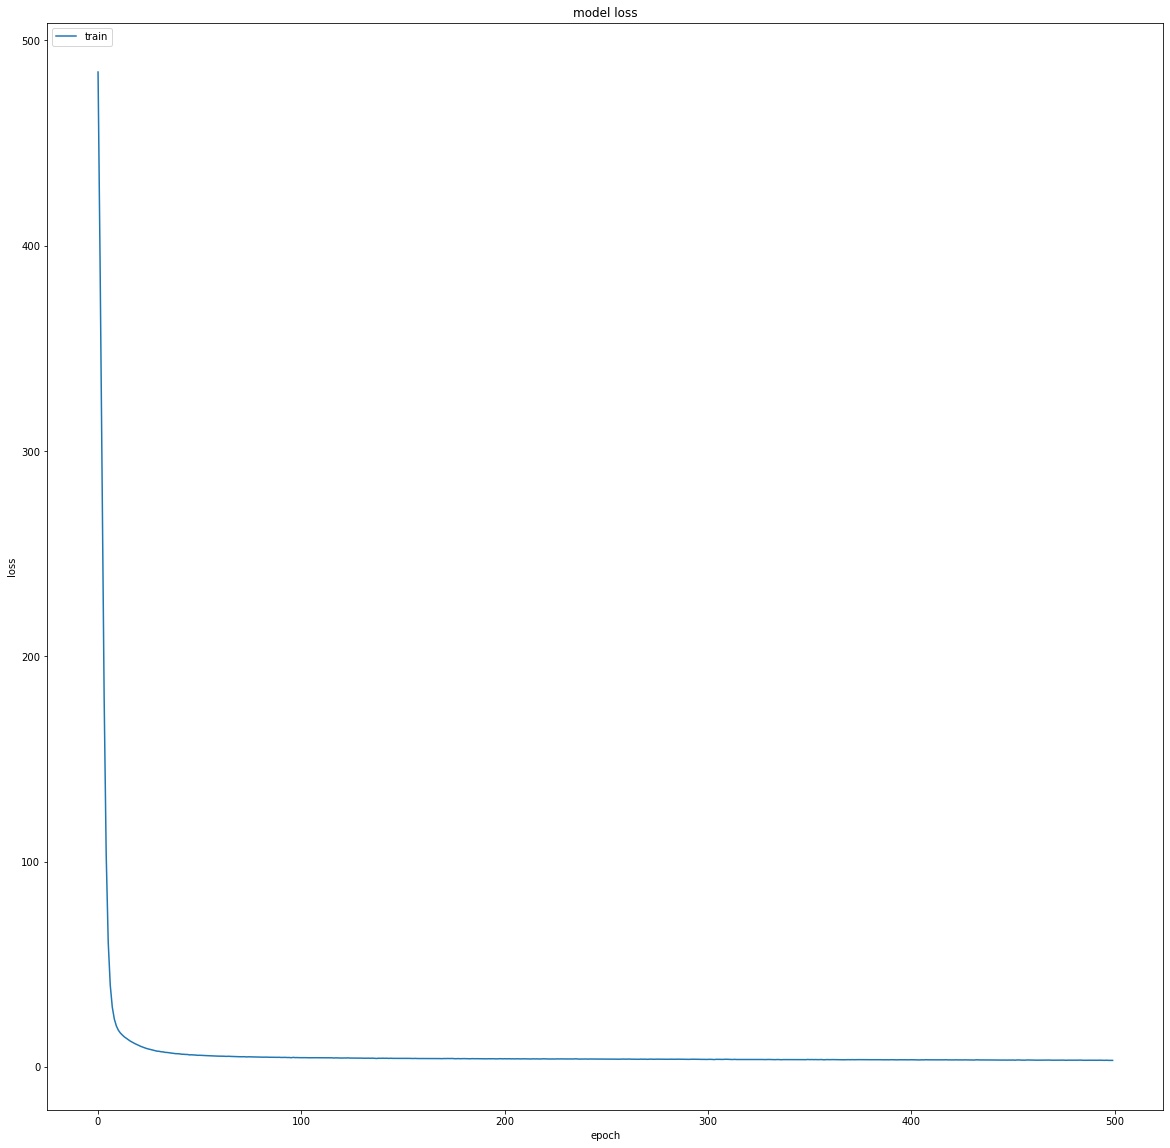

In [78]:
pyplt.plot(history.history['loss'])
pyplt.title('model loss')
pyplt.ylabel('loss')
pyplt.xlabel('epoch')
pyplt.legend(['train', 'test'], loc='upper left')
pyplt.show()

In [79]:
result_epochv1

9.47670618016669

**Result:** The MSE for this model was 5.679925218541571, but I had varying results with several test.

From looking at the above results there definitely seemed to be deminishing returns or even signs of overfitting after the 300 epoch mark. I therefore decided to introduce early stopping in the remaining models.

###### Test 2 - 500 Epochs with Early Stopping

In [80]:
# Test 2
# 
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# #add early stopping
# es = EarlyStopping(monitor='loss', patience=10, verbose=1)

# history = m.fit(x_train, y_train, epochs=500, batch_size=2, callbacks=[es])

# ES_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_ES = m.evaluate(x_test, y_test)

In [81]:
# result_ES

**Result:** MSE was 8.051695742505663

#### 4.4.2.1 Commentary

Early stopping kicked in at before the 230 epoch mark in most tests. This was even when the test was set to only stop when the loss value had not descreased for the previous 10 epochs.

I decided that 250-300 epochs was enough for any further tests.

### 4.4.3 Number of Units per Layer

In this section I adjusted the number of units in the single hidden layer. I used some of the heuristics discussed early as guidelines for selecting the layer sizes.

###### Test 1 - (inputs + outputs) x 2/3

One heuristic is that the number of units in the  hidden layer should be calculated using the above formula. I tested this configuration first.

In [82]:
14*(2/3)


9.333333333333332

In [83]:
# Test 1
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(9, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# #add early stopping
# es = EarlyStopping(monitor='loss', patience=10, verbose=1)

# history = m.fit(x_train, y_train, epochs=250, batch_size=2, callbacks=[es])

# layersize9_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_layerN9 = m.evaluate(x_test, y_test)

In [84]:
# result_layerN9

**Result:** The MSE was 8.323373987319622

###### Test 2 - Twice the number of Inputs

The next heuristics I tested was that the number of units in the hidden layer should not be over twice the number of inputs.

In [85]:
# Test 2
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(26, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# #add early stopping
# es = EarlyStopping(monitor='loss', patience=10, verbose=1)

# history = m.fit(x_train, y_train, epochs=250, batch_size=2, callbacks=[es])

# layersize26_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_layerN26 = m.evaluate(x_test, y_test)

In [86]:
# result_layerN26

**Result:** This gave MSE results comparable to the Baseline model: 7.729459732136828

###### Test 3 - Quadrupel the Input

In [87]:
# m = ks.models.Sequential()
# m.add(ks.layers.Dense(52, input_dim=13, activation="relu"))
# m.add(ks.layers.Dense(1))

# m.compile(loss="mean_squared_error", optimizer="adam")

# #add early stopping
# es = EarlyStopping(monitor='loss', patience=10, verbose=1)

# history = m.fit(x_train, y_train, epochs=250, batch_size=2, callbacks=[es])

# layersize52_prediction = m.predict(x_test).T

# MedianVal_real = y_test.as_matrix().astype(np.float32)

# result_layerN52 = m.evaluate(x_test, y_test)

In [88]:
# result_layerN52

**Result:** This configuration gave the best MSE score so far at 5.981633308085989

#### 4.4.3.1 Commentary

Results for diffent layer sizes again appeared to be inconclusive. I therefore decided to test the different model configurations several times and get the average of the results.

In [89]:
# function to test different batch sizes
# def unitsize_test(tests, batchsize, unit_size):
#     counter = 0
#     resultslist = []
#     while counter < tests:
#         m = ks.models.Sequential()
#         m.add(ks.layers.Dense(unit_size, input_dim=13, activation="relu"))
#         m.add(ks.layers.Dense(1))

#         m.compile(loss="mean_squared_error", optimizer="adam")
        
#         es = EarlyStopping(monitor='loss', patience=10, verbose=1)
        
#         m.fit(x_train, y_train, epochs=300, batch_size=batchsize, callbacks=[es])

#         #unit_prediction = m.predict(x_test).T

#         #MedianVal_real = y_test.as_matrix().astype(np.float32)

#         result_units = m.evaluate(x_test, y_test)
#         counter += 1
#         resultslist.append(result_units)
#     avg_result = sum(resultslist) / tests
#     return avg_result

In [90]:
# hidden layer size = 26
# batch size = 2
# epoch = 300 - with early stopping
#print(unitsize_test(5, 2, 26))

**Result:** was 8.461502002147919

In [91]:
# hidden layer size = 26
# batch size = 4
# epoch = 300 - with early stopping
#print(unitsize_test(5, 4, 26))

**Result:** was 7.670181302821382

In [92]:
# hidden layer size = 52
# batch size = 2
# epoch = 300 - with early stopping
#print(unitsize_test(5, 2, 52))

**Result:** was 8.024365358149751

In [93]:
# hidden layer size = 52
# batch size = 4
# epoch = 300 - with early stopping
#print(unitsize_test(5, 4, 52))

**Result:** was 7.862417864292226

In [94]:
# hidden layer size = 64
# batch size = 2
# epoch = 300 - with early stopping
#print(unitsize_test(5, 2, 64))

**Result:** was 8.067290689590129

In [95]:
# hidden layer size = 64
# batch size = 4
# epoch = 300 - with early stopping
#print(unitsize_test(5, 4, 64))

**Result:** was 7.880062107329673

The best result seemed to be a hidden layer of 26 units and a batch size of 4 per epoch. Batch sizes of 4 seemed to consistently perform better. I therefore decided to change to a batch size of 4 in the subsequent tests.

### 4.4.4 Number of Layers

Next I tested adding additional layers of neurons to the model. Again, I tested each model configuration 5 times and got the average of the MSE results.

In [96]:
# function to test different amounts of layers
# def layer_count_test(tests, batchsize, unit_size1, unit_size2):
#     counter = 0
#     resultslist = []
#     while counter < tests:
#         m = ks.models.Sequential()
#         m.add(ks.layers.Dense(unit_size1, input_dim=13, activation="relu"))
#         m.add(ks.layers.Dense(unit_size2, activation="relu"))
#         m.add(ks.layers.Dense(1))

#         m.compile(loss="mean_squared_error", optimizer="adam")
        
#         es = EarlyStopping(monitor='loss', patience=10, verbose=1)
        
#         m.fit(x_train, y_train, epochs=300, batch_size=batchsize, callbacks=[es])

#         result_units = m.evaluate(x_test, y_test)
        
#         counter += 1
        
#         resultslist.append(result_units)
#         #print("Version: " + tests, batchsize, unit_size1, unit_size2 + " iteration: " + counter)
        
#     avg_result = sum(resultslist) / tests
#     return avg_result

In [97]:
# layers_test_results = [
#     layer_count_test(5, 4, 13, 13),
#     layer_count_test(5, 4, 26, 26),
#     layer_count_test(5, 4, 26, 13),
#     layer_count_test(5, 4, 52, 26),
#     layer_count_test(5, 4, 64, 13),
# ]

In [98]:
# labels = ["13 -> 13", "26 -> 26", "26 -> 13", "52 -> 26", "64 -> 13"]

In [99]:
# layerresults_df = pd.DataFrame({'Tests': labels, 'Results': layers_test_results})

In [100]:
# layerresults_df

|Test|Results|
|:------------------------|:---------|
|13 -> 13|7.155485|
|26 -> 26|7.930675|
|26 -> 13|7.613028|
|52 -> 26|8.173526|
|64 -> 13|7.872510|

**Result:** The best results were achieved using two layers of 13 units giving an MSE of 7.155485.

##### Test with 3 Layers 

In [101]:
def three_layer_count_test(tests, batchsize, unit_size1, unit_size2, unit_size3):
    counter = 0
    resultslist = []
    while counter < tests:
        m = ks.models.Sequential()
        m.add(ks.layers.Dense(unit_size1, input_dim=13, activation="relu"))
        m.add(ks.layers.Dense(unit_size2, activation="relu"))
        m.add(ks.layers.Dense(unit_size3, activation="relu"))
        m.add(ks.layers.Dense(1))

        m.compile(loss="mean_squared_error", optimizer="adam")
        
        es = EarlyStopping(monitor='loss', patience=10, verbose=1)
        
        m.fit(x_train, y_train, epochs=300, batch_size=batchsize, callbacks=[es])

        result_units = m.evaluate(x_test, y_test)
        
        counter += 1
        
        resultslist.append(result_units)
   
        
    avg_result = sum(resultslist) / tests
    return avg_result

In [102]:
three_layers_test_results = [
    three_layer_count_test(5, 4, 13, 13, 13),
    three_layer_count_test(5, 4, 26, 13, 13),
    three_layer_count_test(5, 4, 26, 13, 9),
    three_layer_count_test(5, 4, 52, 26, 13),
    three_layer_count_test(5, 4, 64, 26, 13)
]

Epoch 1/300
372/372 [==============================] - 0s 1ms/step - loss: 408.0405
Epoch 2/300
372/372 [==============================] - 0s 526us/step - loss: 143.6287
Epoch 3/300
372/372 [==============================] - 0s 548us/step - loss: 28.8520
Epoch 4/300
372/372 [==============================] - 0s 538us/step - loss: 18.4887
Epoch 5/300
372/372 [==============================] - 0s 547us/step - loss: 15.1063
Epoch 6/300
372/372 [==============================] - 0s 529us/step - loss: 13.1709
Epoch 7/300
372/372 [==============================] - 0s 525us/step - loss: 12.0065
Epoch 8/300
372/372 [==============================] - 0s 545us/step - loss: 11.2548
Epoch 9/300
372/372 [==============================] - 0s 529us/step - loss: 10.5788
Epoch 10/300
372/372 [==============================] - 0s 523us/step - loss: 9.7543
Epoch 11/300
372/372 [==============================] - 0s 530us/step - loss: 9.1546
Epoch 12/300
372/372 [==============================] - 0s 519us/

Epoch 97/300
372/372 [==============================] - 0s 501us/step - loss: 3.7693
Epoch 98/300
372/372 [==============================] - 0s 505us/step - loss: 3.7086
Epoch 99/300
372/372 [==============================] - 0s 499us/step - loss: 3.6616
Epoch 100/300
372/372 [==============================] - 0s 510us/step - loss: 3.6271
Epoch 101/300
372/372 [==============================] - 0s 503us/step - loss: 3.8027
Epoch 102/300
372/372 [==============================] - 0s 495us/step - loss: 3.6340
Epoch 103/300
372/372 [==============================] - 0s 495us/step - loss: 3.6427
Epoch 104/300
372/372 [==============================] - 0s 492us/step - loss: 3.6741
Epoch 105/300
372/372 [==============================] - 0s 487us/step - loss: 3.5969
Epoch 106/300
372/372 [==============================] - 0s 496us/step - loss: 3.6715
Epoch 107/300
372/372 [==============================] - 0s 503us/step - loss: 3.6616
Epoch 108/300
372/372 [==============================] - 

372/372 [==============================] - 0s 470us/step - loss: 2.7916
Epoch 193/300
372/372 [==============================] - 0s 482us/step - loss: 2.7990
Epoch 194/300
372/372 [==============================] - 0s 491us/step - loss: 2.7516
Epoch 195/300
372/372 [==============================] - 0s 419us/step - loss: 2.7078
Epoch 196/300
372/372 [==============================] - 0s 483us/step - loss: 2.8147
Epoch 197/300
372/372 [==============================] - 0s 489us/step - loss: 2.5989
Epoch 198/300
372/372 [==============================] - 0s 451us/step - loss: 2.7123
Epoch 199/300
372/372 [==============================] - 0s 465us/step - loss: 2.5682
Epoch 200/300
372/372 [==============================] - 0s 505us/step - loss: 2.6488
Epoch 201/300
372/372 [==============================] - 0s 500us/step - loss: 2.6273
Epoch 202/300
372/372 [==============================] - 0s 440us/step - loss: 2.6244
Epoch 203/300
372/372 [==============================] - 0s 469us/st

Epoch 22/300
372/372 [==============================] - 0s 479us/step - loss: 6.8253
Epoch 23/300
372/372 [==============================] - 0s 515us/step - loss: 6.5571
Epoch 24/300
372/372 [==============================] - 0s 517us/step - loss: 6.3895
Epoch 25/300
372/372 [==============================] - 0s 499us/step - loss: 6.2480
Epoch 26/300
372/372 [==============================] - 0s 513us/step - loss: 6.3282
Epoch 27/300
372/372 [==============================] - 0s 494us/step - loss: 6.1412
Epoch 28/300
372/372 [==============================] - 0s 525us/step - loss: 5.9429
Epoch 29/300
372/372 [==============================] - 0s 524us/step - loss: 5.8287
Epoch 30/300
372/372 [==============================] - 0s 467us/step - loss: 5.8497
Epoch 31/300
372/372 [==============================] - 0s 507us/step - loss: 5.7519
Epoch 32/300
372/372 [==============================] - 0s 506us/step - loss: 5.7852
Epoch 33/300
372/372 [==============================] - 0s 520us/

372/372 [==============================] - 0s 508us/step - loss: 3.4879
Epoch 118/300
372/372 [==============================] - 0s 507us/step - loss: 3.3783
Epoch 119/300
372/372 [==============================] - 0s 515us/step - loss: 3.4103
Epoch 120/300
372/372 [==============================] - 0s 502us/step - loss: 3.3886
Epoch 121/300
372/372 [==============================] - 0s 514us/step - loss: 3.3281
Epoch 122/300
372/372 [==============================] - 0s 518us/step - loss: 3.5980
Epoch 123/300
372/372 [==============================] - 0s 500us/step - loss: 3.1743
Epoch 124/300
372/372 [==============================] - 0s 505us/step - loss: 3.4818
Epoch 125/300
372/372 [==============================] - 0s 491us/step - loss: 3.3765
Epoch 126/300
372/372 [==============================] - 0s 526us/step - loss: 3.2798
Epoch 127/300
372/372 [==============================] - 0s 504us/step - loss: 3.2736
Epoch 128/300
372/372 [==============================] - 0s 504us/st

372/372 [==============================] - 0s 539us/step - loss: 4.2709
Epoch 80/300
372/372 [==============================] - 0s 496us/step - loss: 4.1855
Epoch 81/300
372/372 [==============================] - 0s 500us/step - loss: 4.1394
Epoch 82/300
372/372 [==============================] - 0s 492us/step - loss: 4.1283
Epoch 83/300
372/372 [==============================] - 0s 458us/step - loss: 4.2018
Epoch 84/300
372/372 [==============================] - 0s 506us/step - loss: 4.1900
Epoch 85/300
372/372 [==============================] - 0s 520us/step - loss: 4.1356
Epoch 86/300
372/372 [==============================] - 0s 519us/step - loss: 4.2057
Epoch 87/300
372/372 [==============================] - 0s 453us/step - loss: 4.1186
Epoch 88/300
372/372 [==============================] - 0s 479us/step - loss: 4.0252
Epoch 89/300
372/372 [==============================] - 0s 533us/step - loss: 4.1663
Epoch 90/300
372/372 [==============================] - 0s 499us/step - loss: 

372/372 [==============================] - 0s 482us/step - loss: 5.4909
Epoch 34/300
372/372 [==============================] - 0s 493us/step - loss: 5.3670
Epoch 35/300
372/372 [==============================] - 0s 500us/step - loss: 5.2390
Epoch 36/300
372/372 [==============================] - 0s 586us/step - loss: 5.3755
Epoch 37/300
372/372 [==============================] - 0s 561us/step - loss: 5.1746
Epoch 38/300
372/372 [==============================] - 0s 503us/step - loss: 5.1778
Epoch 39/300
372/372 [==============================] - 0s 511us/step - loss: 5.0539
Epoch 40/300
372/372 [==============================] - 0s 516us/step - loss: 5.1259
Epoch 41/300
372/372 [==============================] - 0s 472us/step - loss: 4.8574
Epoch 42/300
372/372 [==============================] - 0s 522us/step - loss: 4.8909
Epoch 43/300
372/372 [==============================] - 0s 527us/step - loss: 4.7042
Epoch 44/300
372/372 [==============================] - 0s 520us/step - loss: 

372/372 [==============================] - 0s 496us/step - loss: 2.9316
Epoch 130/300
372/372 [==============================] - 0s 506us/step - loss: 2.9870
Epoch 131/300
372/372 [==============================] - ETA: 0s - loss: 3.249 - 0s 508us/step - loss: 3.1254
Epoch 132/300
372/372 [==============================] - 0s 474us/step - loss: 2.9595
Epoch 133/300
372/372 [==============================] - 0s 454us/step - loss: 2.9931
Epoch 134/300
372/372 [==============================] - 0s 511us/step - loss: 2.9756
Epoch 135/300
372/372 [==============================] - 0s 478us/step - loss: 3.0529
Epoch 136/300
372/372 [==============================] - 0s 491us/step - loss: 3.0617
Epoch 137/300
372/372 [==============================] - 0s 510us/step - loss: 2.9862
Epoch 138/300
372/372 [==============================] - 0s 491us/step - loss: 2.9342
Epoch 139/300
372/372 [==============================] - 0s 494us/step - loss: 2.9090
Epoch 140/300
372/372 [=====================

Epoch 73/300
372/372 [==============================] - 0s 506us/step - loss: 4.1488
Epoch 74/300
372/372 [==============================] - 0s 465us/step - loss: 4.1337
Epoch 75/300
372/372 [==============================] - 0s 484us/step - loss: 4.3334
Epoch 76/300
372/372 [==============================] - 0s 476us/step - loss: 4.1900
Epoch 77/300
372/372 [==============================] - 0s 501us/step - loss: 4.1085
Epoch 78/300
372/372 [==============================] - 0s 526us/step - loss: 4.1531
Epoch 79/300
372/372 [==============================] - 0s 488us/step - loss: 4.1372
Epoch 80/300
372/372 [==============================] - 0s 544us/step - loss: 4.1431
Epoch 81/300
372/372 [==============================] - 0s 489us/step - loss: 4.0955
Epoch 82/300
372/372 [==============================] - 0s 505us/step - loss: 4.0836
Epoch 83/300
372/372 [==============================] - 0s 483us/step - loss: 3.9580
Epoch 84/300
372/372 [==============================] - 0s 495us/

372/372 [==============================] - 0s 478us/step - loss: 4.0544
Epoch 44/300
372/372 [==============================] - 0s 498us/step - loss: 4.0562
Epoch 45/300
372/372 [==============================] - 0s 498us/step - loss: 4.2289
Epoch 46/300
372/372 [==============================] - 0s 437us/step - loss: 4.1022
Epoch 47/300
372/372 [==============================] - 0s 470us/step - loss: 3.8542
Epoch 48/300
372/372 [==============================] - 0s 506us/step - loss: 3.7808
Epoch 49/300
372/372 [==============================] - 0s 513us/step - loss: 3.8356
Epoch 50/300
372/372 [==============================] - 0s 482us/step - loss: 3.7072
Epoch 51/300
372/372 [==============================] - 0s 496us/step - loss: 3.7559
Epoch 52/300
372/372 [==============================] - 0s 512us/step - loss: 3.8058
Epoch 53/300
372/372 [==============================] - 0s 527us/step - loss: 3.5632
Epoch 54/300
372/372 [==============================] - 0s 451us/step - loss: 

372/372 [==============================] - 0s 485us/step - loss: 2.4931
Epoch 140/300
372/372 [==============================] - 0s 488us/step - loss: 2.4758
Epoch 141/300
372/372 [==============================] - 0s 483us/step - loss: 2.2054
Epoch 142/300
372/372 [==============================] - 0s 494us/step - loss: 2.4252
Epoch 143/300
372/372 [==============================] - 0s 505us/step - loss: 2.3342
Epoch 144/300
372/372 [==============================] - 0s 501us/step - loss: 2.2792
Epoch 145/300
372/372 [==============================] - 0s 463us/step - loss: 2.2574
Epoch 146/300
372/372 [==============================] - 0s 475us/step - loss: 2.2554
Epoch 147/300
372/372 [==============================] - 0s 503us/step - loss: 2.2477
Epoch 148/300
372/372 [==============================] - 0s 458us/step - loss: 2.1988
Epoch 149/300
372/372 [==============================] - 0s 506us/step - loss: 2.2872
Epoch 150/300
372/372 [==============================] - 0s 478us/st

372/372 [==============================] - 0s 503us/step - loss: 11.0806
Epoch 8/300
372/372 [==============================] - 0s 480us/step - loss: 9.9829
Epoch 9/300
372/372 [==============================] - 0s 448us/step - loss: 9.2133
Epoch 10/300
372/372 [==============================] - 0s 484us/step - loss: 8.3495
Epoch 11/300
372/372 [==============================] - 0s 494us/step - loss: 7.7819
Epoch 12/300
372/372 [==============================] - 0s 449us/step - loss: 7.5090
Epoch 13/300
372/372 [==============================] - 0s 487us/step - loss: 6.9680
Epoch 14/300
372/372 [==============================] - 0s 495us/step - loss: 6.6345
Epoch 15/300
372/372 [==============================] - 0s 511us/step - loss: 6.4858
Epoch 16/300
372/372 [==============================] - 0s 478us/step - loss: 6.2728
Epoch 17/300
372/372 [==============================] - 0s 471us/step - loss: 6.0496
Epoch 18/300
372/372 [==============================] - 0s 472us/step - loss: 5

372/372 [==============================] - 0s 500us/step - loss: 2.2637
Epoch 104/300
372/372 [==============================] - 0s 494us/step - loss: 2.3296
Epoch 105/300
372/372 [==============================] - 0s 484us/step - loss: 2.3177
Epoch 106/300
372/372 [==============================] - 0s 471us/step - loss: 2.2092
Epoch 107/300
372/372 [==============================] - 0s 478us/step - loss: 2.2488
Epoch 108/300
372/372 [==============================] - 0s 495us/step - loss: 2.2753
Epoch 109/300
372/372 [==============================] - 0s 490us/step - loss: 2.1728
Epoch 110/300
372/372 [==============================] - 0s 504us/step - loss: 2.0632
Epoch 111/300
372/372 [==============================] - 0s 459us/step - loss: 2.2358
Epoch 112/300
372/372 [==============================] - 0s 489us/step - loss: 2.0805
Epoch 113/300
372/372 [==============================] - 0s 497us/step - loss: 2.1349
Epoch 114/300
372/372 [==============================] - 0s 491us/st

372/372 [==============================] - 0s 335us/step - loss: 5.8773
Epoch 21/300
372/372 [==============================] - 0s 346us/step - loss: 5.9237
Epoch 22/300
372/372 [==============================] - 0s 343us/step - loss: 5.8423
Epoch 23/300
372/372 [==============================] - 0s 336us/step - loss: 5.5321
Epoch 24/300
372/372 [==============================] - 0s 376us/step - loss: 5.5222
Epoch 25/300
372/372 [==============================] - 0s 350us/step - loss: 5.4313
Epoch 26/300
372/372 [==============================] - 0s 368us/step - loss: 5.4263
Epoch 27/300
372/372 [==============================] - 0s 365us/step - loss: 5.2390
Epoch 28/300
372/372 [==============================] - 0s 362us/step - loss: 5.2970
Epoch 29/300
372/372 [==============================] - 0s 339us/step - loss: 5.2448
Epoch 30/300
372/372 [==============================] - 0s 353us/step - loss: 5.2018
Epoch 31/300
372/372 [==============================] - 0s 354us/step - loss: 

372/372 [==============================] - 0s 334us/step - loss: 3.0646
Epoch 117/300
372/372 [==============================] - 0s 353us/step - loss: 3.1337
Epoch 118/300
372/372 [==============================] - 0s 357us/step - loss: 3.0687
Epoch 119/300
372/372 [==============================] - 0s 355us/step - loss: 3.0014
Epoch 120/300
372/372 [==============================] - 0s 344us/step - loss: 3.0605
Epoch 121/300
372/372 [==============================] - 0s 353us/step - loss: 3.0305
Epoch 122/300
372/372 [==============================] - 0s 372us/step - loss: 3.0473
Epoch 123/300
372/372 [==============================] - 0s 347us/step - loss: 2.9732
Epoch 124/300
372/372 [==============================] - 0s 352us/step - loss: 2.9521
Epoch 125/300
372/372 [==============================] - 0s 360us/step - loss: 2.9655
Epoch 126/300
372/372 [==============================] - 0s 349us/step - loss: 2.9923
Epoch 127/300
372/372 [==============================] - 0s 354us/st

372/372 [==============================] - 0s 329us/step - loss: 2.1179
Epoch 212/300
372/372 [==============================] - 0s 350us/step - loss: 2.0318
Epoch 213/300
372/372 [==============================] - 0s 365us/step - loss: 2.1871
Epoch 214/300
372/372 [==============================] - 0s 368us/step - loss: 2.0350
Epoch 215/300
372/372 [==============================] - 0s 344us/step - loss: 2.1641
Epoch 216/300
372/372 [==============================] - 0s 358us/step - loss: 2.1458
Epoch 217/300
372/372 [==============================] - 0s 360us/step - loss: 2.0419
Epoch 218/300
372/372 [==============================] - 0s 361us/step - loss: 2.0269
Epoch 219/300
372/372 [==============================] - 0s 389us/step - loss: 2.0884
Epoch 220/300
372/372 [==============================] - 0s 384us/step - loss: 2.0524
Epoch 221/300
372/372 [==============================] - 0s 360us/step - loss: 2.1775
Epoch 222/300
372/372 [==============================] - 0s 378us/st

372/372 [==============================] - 0s 528us/step - loss: 3.3913
Epoch 57/300
372/372 [==============================] - 0s 501us/step - loss: 3.4102
Epoch 58/300
372/372 [==============================] - 0s 482us/step - loss: 3.3826
Epoch 59/300
372/372 [==============================] - 0s 505us/step - loss: 3.3850
Epoch 60/300
372/372 [==============================] - 0s 453us/step - loss: 3.2418
Epoch 61/300
372/372 [==============================] - 0s 525us/step - loss: 3.3333
Epoch 62/300
372/372 [==============================] - 0s 517us/step - loss: 3.3571
Epoch 63/300
372/372 [==============================] - 0s 444us/step - loss: 3.3314
Epoch 64/300
372/372 [==============================] - 0s 478us/step - loss: 3.1867
Epoch 65/300
372/372 [==============================] - 0s 519us/step - loss: 3.1513
Epoch 66/300
372/372 [==============================] - 0s 531us/step - loss: 3.0595
Epoch 67/300
372/372 [==============================] - 0s 508us/step - loss: 

372/372 [==============================] - 0s 546us/step - loss: 4.4792
Epoch 36/300
372/372 [==============================] - 0s 540us/step - loss: 4.6538
Epoch 37/300
372/372 [==============================] - 0s 536us/step - loss: 4.2985
Epoch 38/300
372/372 [==============================] - 0s 548us/step - loss: 4.4325
Epoch 39/300
372/372 [==============================] - 0s 532us/step - loss: 4.2296
Epoch 40/300
372/372 [==============================] - 0s 553us/step - loss: 4.2383
Epoch 41/300
372/372 [==============================] - 0s 550us/step - loss: 3.9943
Epoch 42/300
372/372 [==============================] - 0s 547us/step - loss: 4.1962
Epoch 43/300
372/372 [==============================] - 0s 545us/step - loss: 3.9610
Epoch 44/300
372/372 [==============================] - 0s 547us/step - loss: 4.0527
Epoch 45/300
372/372 [==============================] - 0s 555us/step - loss: 3.9446
Epoch 46/300
372/372 [==============================] - 0s 543us/step - loss: 

Epoch 131/300
372/372 [==============================] - 0s 517us/step - loss: 2.0976
Epoch 132/300
372/372 [==============================] - 0s 517us/step - loss: 2.1173
Epoch 133/300
372/372 [==============================] - 0s 538us/step - loss: 2.1499
Epoch 134/300
372/372 [==============================] - 0s 488us/step - loss: 2.1792
Epoch 135/300
372/372 [==============================] - 0s 513us/step - loss: 2.2710
Epoch 136/300
372/372 [==============================] - 0s 533us/step - loss: 2.2094
Epoch 137/300
372/372 [==============================] - 0s 534us/step - loss: 2.2148
Epoch 138/300
372/372 [==============================] - 0s 521us/step - loss: 2.0518
Epoch 139/300
372/372 [==============================] - 0s 536us/step - loss: 2.1251
Epoch 140/300
372/372 [==============================] - 0s 534us/step - loss: 1.9754
Epoch 141/300
372/372 [==============================] - 0s 528us/step - loss: 2.0569
Epoch 142/300
372/372 [==============================]

372/372 [==============================] - 0s 542us/step - loss: 11.4281
Epoch 10/300
372/372 [==============================] - 0s 512us/step - loss: 10.1419
Epoch 11/300
372/372 [==============================] - 0s 523us/step - loss: 9.6444
Epoch 12/300
372/372 [==============================] - 0s 505us/step - loss: 9.2078
Epoch 13/300
372/372 [==============================] - 0s 503us/step - loss: 8.5355
Epoch 14/300
372/372 [==============================] - 0s 544us/step - loss: 8.2123
Epoch 15/300
372/372 [==============================] - 0s 494us/step - loss: 7.7001
Epoch 16/300
372/372 [==============================] - 0s 504us/step - loss: 7.4483
Epoch 17/300
372/372 [==============================] - 0s 542us/step - loss: 7.1522
Epoch 18/300
372/372 [==============================] - 0s 487us/step - loss: 6.8634
Epoch 19/300
372/372 [==============================] - 0s 529us/step - loss: 6.7105
Epoch 20/300
372/372 [==============================] - 0s 517us/step - loss

372/372 [==============================] - 0s 526us/step - loss: 3.3393
Epoch 106/300
372/372 [==============================] - 0s 489us/step - loss: 3.3414
Epoch 107/300
372/372 [==============================] - 0s 522us/step - loss: 3.2657
Epoch 108/300
372/372 [==============================] - 0s 504us/step - loss: 3.1338
Epoch 109/300
372/372 [==============================] - 0s 497us/step - loss: 3.3563
Epoch 110/300
372/372 [==============================] - 0s 532us/step - loss: 3.2912
Epoch 111/300
372/372 [==============================] - 0s 508us/step - loss: 3.1909
Epoch 112/300
372/372 [==============================] - 0s 523us/step - loss: 3.1790
Epoch 113/300
372/372 [==============================] - 0s 521us/step - loss: 3.1307
Epoch 114/300
372/372 [==============================] - 0s 479us/step - loss: 3.3108
Epoch 115/300
372/372 [==============================] - 0s 507us/step - loss: 3.1982
Epoch 116/300
372/372 [==============================] - 0s 528us/st

372/372 [==============================] - 0s 530us/step - loss: 4.7808
Epoch 29/300
372/372 [==============================] - 0s 498us/step - loss: 4.7459
Epoch 30/300
372/372 [==============================] - 0s 482us/step - loss: 4.5203
Epoch 31/300
372/372 [==============================] - 0s 539us/step - loss: 4.4506
Epoch 32/300
372/372 [==============================] - 0s 543us/step - loss: 4.5176
Epoch 33/300
372/372 [==============================] - 0s 522us/step - loss: 4.3940
Epoch 34/300
372/372 [==============================] - 0s 517us/step - loss: 4.1848
Epoch 35/300
372/372 [==============================] - 0s 520us/step - loss: 4.1592
Epoch 36/300
372/372 [==============================] - 0s 530us/step - loss: 4.1167
Epoch 37/300
372/372 [==============================] - 0s 513us/step - loss: 4.0643
Epoch 38/300
372/372 [==============================] - 0s 514us/step - loss: 4.0320
Epoch 39/300
372/372 [==============================] - 0s 517us/step - loss: 

372/372 [==============================] - 0s 537us/step - loss: 22.6100
Epoch 5/300
372/372 [==============================] - 0s 517us/step - loss: 18.0615
Epoch 6/300
372/372 [==============================] - 0s 522us/step - loss: 15.3466
Epoch 7/300
372/372 [==============================] - 0s 526us/step - loss: 13.2863
Epoch 8/300
372/372 [==============================] - 0s 530us/step - loss: 11.7835
Epoch 9/300
372/372 [==============================] - 0s 526us/step - loss: 10.5138
Epoch 10/300
372/372 [==============================] - 0s 522us/step - loss: 9.3972
Epoch 11/300
372/372 [==============================] - 0s 527us/step - loss: 8.8126
Epoch 12/300
372/372 [==============================] - 0s 536us/step - loss: 8.0465
Epoch 13/300
372/372 [==============================] - 0s 533us/step - loss: 7.7101
Epoch 14/300
372/372 [==============================] - 0s 520us/step - loss: 7.3143
Epoch 15/300
372/372 [==============================] - 0s 456us/step - loss:

372/372 [==============================] - 0s 536us/step - loss: 2.9325
Epoch 101/300
372/372 [==============================] - 0s 523us/step - loss: 2.9719
Epoch 102/300
372/372 [==============================] - 0s 526us/step - loss: 2.8713
Epoch 103/300
372/372 [==============================] - 0s 528us/step - loss: 3.0310
Epoch 104/300
372/372 [==============================] - 0s 491us/step - loss: 2.8354
Epoch 105/300
372/372 [==============================] - 0s 510us/step - loss: 2.8662
Epoch 106/300
372/372 [==============================] - 0s 517us/step - loss: 2.7885
Epoch 107/300
372/372 [==============================] - 0s 505us/step - loss: 2.7907
Epoch 108/300
372/372 [==============================] - 0s 529us/step - loss: 2.8553
Epoch 109/300
372/372 [==============================] - 0s 517us/step - loss: 2.8465
Epoch 110/300
372/372 [==============================] - 0s 493us/step - loss: 2.7576
Epoch 111/300
372/372 [==============================] - 0s 503us/st

372/372 [==============================] - 0s 537us/step - loss: 1.8962
Epoch 196/300
372/372 [==============================] - 0s 508us/step - loss: 1.9835
Epoch 197/300
372/372 [==============================] - 0s 512us/step - loss: 1.8834
Epoch 198/300
372/372 [==============================] - 0s 501us/step - loss: 1.8900
Epoch 199/300
372/372 [==============================] - 0s 496us/step - loss: 1.8914
Epoch 200/300
372/372 [==============================] - 0s 530us/step - loss: 1.8627
Epoch 201/300
372/372 [==============================] - 0s 508us/step - loss: 1.8659
Epoch 202/300
372/372 [==============================] - 0s 535us/step - loss: 1.8622
Epoch 203/300
372/372 [==============================] - 0s 487us/step - loss: 1.8803
Epoch 204/300
372/372 [==============================] - 0s 536us/step - loss: 1.7117
Epoch 205/300
372/372 [==============================] - 0s 530us/step - loss: 1.8101
Epoch 206/300
372/372 [==============================] - 0s 531us/st

Epoch 63/300
372/372 [==============================] - 0s 503us/step - loss: 3.8012
Epoch 64/300
372/372 [==============================] - 0s 485us/step - loss: 3.7375
Epoch 65/300
372/372 [==============================] - 0s 507us/step - loss: 3.7145
Epoch 66/300
372/372 [==============================] - 0s 516us/step - loss: 3.8019
Epoch 67/300
372/372 [==============================] - 0s 497us/step - loss: 3.6649
Epoch 68/300
372/372 [==============================] - 0s 512us/step - loss: 3.6767
Epoch 69/300
372/372 [==============================] - 0s 510us/step - loss: 3.5822
Epoch 70/300
372/372 [==============================] - 0s 494us/step - loss: 3.7269
Epoch 71/300
372/372 [==============================] - 0s 559us/step - loss: 3.6981
Epoch 72/300
372/372 [==============================] - 0s 514us/step - loss: 3.6912
Epoch 73/300
372/372 [==============================] - 0s 494us/step - loss: 3.5622
Epoch 74/300
372/372 [==============================] - 0s 504us/

372/372 [==============================] - 0s 503us/step - loss: 2.3441
Epoch 159/300
372/372 [==============================] - 0s 504us/step - loss: 2.3470
Epoch 160/300
372/372 [==============================] - 0s 512us/step - loss: 2.3347
Epoch 161/300
372/372 [==============================] - 0s 498us/step - loss: 2.3525
Epoch 162/300
372/372 [==============================] - 0s 533us/step - loss: 2.4146
Epoch 163/300
372/372 [==============================] - 0s 507us/step - loss: 2.3227
Epoch 164/300
372/372 [==============================] - 0s 516us/step - loss: 2.3841
Epoch 165/300
372/372 [==============================] - 0s 524us/step - loss: 2.3818
Epoch 166/300
372/372 [==============================] - 0s 521us/step - loss: 2.2512
Epoch 167/300
372/372 [==============================] - 0s 495us/step - loss: 2.3050
Epoch 168/300
372/372 [==============================] - 0s 522us/step - loss: 2.3023
Epoch 169/300
372/372 [==============================] - 0s 514us/st

372/372 [==============================] - 0s 545us/step - loss: 3.8932
Epoch 56/300
372/372 [==============================] - 0s 554us/step - loss: 3.8472
Epoch 57/300
372/372 [==============================] - 0s 559us/step - loss: 3.8139
Epoch 58/300
372/372 [==============================] - 0s 550us/step - loss: 3.7651
Epoch 59/300
372/372 [==============================] - 0s 562us/step - loss: 3.6974
Epoch 60/300
372/372 [==============================] - 0s 478us/step - loss: 3.6511
Epoch 61/300
372/372 [==============================] - 0s 582us/step - loss: 3.7668
Epoch 62/300
372/372 [==============================] - 0s 522us/step - loss: 3.8081
Epoch 63/300
372/372 [==============================] - 0s 548us/step - loss: 3.6302
Epoch 64/300
372/372 [==============================] - 0s 548us/step - loss: 3.6035
Epoch 65/300
372/372 [==============================] - 0s 600us/step - loss: 3.6370
Epoch 66/300
372/372 [==============================] - 0s 619us/step - loss: 

Epoch 151/300
372/372 [==============================] - 0s 519us/step - loss: 2.2038
Epoch 152/300
372/372 [==============================] - 0s 521us/step - loss: 2.1941
Epoch 153/300
372/372 [==============================] - 0s 576us/step - loss: 2.1898
Epoch 154/300
372/372 [==============================] - 0s 553us/step - loss: 2.2248
Epoch 155/300
372/372 [==============================] - 0s 529us/step - loss: 2.2292
Epoch 156/300
372/372 [==============================] - 0s 520us/step - loss: 2.2048
Epoch 157/300
372/372 [==============================] - 0s 526us/step - loss: 2.2267
Epoch 158/300
372/372 [==============================] - 0s 510us/step - loss: 2.1054
Epoch 159/300
372/372 [==============================] - 0s 528us/step - loss: 2.0779
Epoch 160/300
372/372 [==============================] - 0s 534us/step - loss: 2.2531
Epoch 161/300
372/372 [==============================] - 0s 504us/step - loss: 2.1600
Epoch 162/300
372/372 [==============================]

372/372 [==============================] - 0s 456us/step - loss: 2.6805
Epoch 65/300
372/372 [==============================] - 0s 522us/step - loss: 2.7343
Epoch 66/300
372/372 [==============================] - 0s 508us/step - loss: 2.6030
Epoch 67/300
372/372 [==============================] - 0s 500us/step - loss: 2.5062
Epoch 68/300
372/372 [==============================] - 0s 532us/step - loss: 2.4851
Epoch 69/300
372/372 [==============================] - 0s 471us/step - loss: 2.6369
Epoch 70/300
372/372 [==============================] - 0s 525us/step - loss: 2.5548
Epoch 71/300
372/372 [==============================] - 0s 496us/step - loss: 2.5727
Epoch 72/300
372/372 [==============================] - 0s 531us/step - loss: 2.7002
Epoch 73/300
372/372 [==============================] - 0s 488us/step - loss: 2.4490
Epoch 74/300
372/372 [==============================] - 0s 499us/step - loss: 2.3366
Epoch 75/300
372/372 [==============================] - 0s 509us/step - loss: 

372/372 [==============================] - 0s 547us/step - loss: 4.9815
Epoch 23/300
372/372 [==============================] - 0s 512us/step - loss: 4.9051
Epoch 24/300
372/372 [==============================] - 0s 551us/step - loss: 4.7880
Epoch 25/300
372/372 [==============================] - 0s 499us/step - loss: 4.8939
Epoch 26/300
372/372 [==============================] - 0s 522us/step - loss: 4.7563
Epoch 27/300
372/372 [==============================] - ETA: 0s - loss: 4.423 - 0s 510us/step - loss: 4.5790
Epoch 28/300
372/372 [==============================] - 0s 518us/step - loss: 4.5136
Epoch 29/300
372/372 [==============================] - 0s 512us/step - loss: 4.4485
Epoch 30/300
372/372 [==============================] - 0s 556us/step - loss: 4.3617
Epoch 31/300
372/372 [==============================] - 0s 545us/step - loss: 4.4101
Epoch 32/300
372/372 [==============================] - 0s 499us/step - loss: 4.2685
Epoch 33/300
372/372 [==============================] 

372/372 [==============================] - 0s 353us/step - loss: 1.7463
Epoch 119/300
372/372 [==============================] - 0s 345us/step - loss: 1.8598
Epoch 120/300
372/372 [==============================] - 0s 348us/step - loss: 1.9758
Epoch 121/300
372/372 [==============================] - 0s 349us/step - loss: 1.6958
Epoch 122/300
372/372 [==============================] - 0s 360us/step - loss: 1.7290
Epoch 123/300
372/372 [==============================] - 0s 352us/step - loss: 1.6944
Epoch 124/300
372/372 [==============================] - 0s 339us/step - loss: 1.7711
Epoch 125/300
372/372 [==============================] - 0s 344us/step - loss: 1.7642
Epoch 126/300
372/372 [==============================] - 0s 362us/step - loss: 1.9255
Epoch 127/300
372/372 [==============================] - 0s 346us/step - loss: 1.7480
Epoch 128/300
372/372 [==============================] - 0s 369us/step - loss: 1.7262
Epoch 129/300
372/372 [==============================] - 0s 358us/st

372/372 [==============================] - 0s 317us/step - loss: 3.3973
Epoch 34/300
372/372 [==============================] - 0s 335us/step - loss: 3.3245
Epoch 35/300
372/372 [==============================] - 0s 342us/step - loss: 3.7308
Epoch 36/300
372/372 [==============================] - 0s 330us/step - loss: 3.6548
Epoch 37/300
372/372 [==============================] - 0s 335us/step - loss: 3.3417
Epoch 38/300
372/372 [==============================] - 0s 353us/step - loss: 3.2108
Epoch 39/300
372/372 [==============================] - 0s 334us/step - loss: 3.3903
Epoch 40/300
372/372 [==============================] - 0s 352us/step - loss: 3.3107
Epoch 41/300
372/372 [==============================] - 0s 335us/step - loss: 3.1210
Epoch 42/300
372/372 [==============================] - 0s 335us/step - loss: 3.2031
Epoch 43/300
372/372 [==============================] - 0s 345us/step - loss: 3.1544
Epoch 44/300
372/372 [==============================] - 0s 344us/step - loss: 

372/372 [==============================] - 0s 314us/step - loss: 3.7986
Epoch 34/300
372/372 [==============================] - 0s 324us/step - loss: 3.6783
Epoch 35/300
372/372 [==============================] - 0s 326us/step - loss: 3.5600
Epoch 36/300
372/372 [==============================] - 0s 307us/step - loss: 3.8074
Epoch 37/300
372/372 [==============================] - 0s 322us/step - loss: 3.4554
Epoch 38/300
372/372 [==============================] - 0s 332us/step - loss: 3.5937
Epoch 39/300
372/372 [==============================] - 0s 310us/step - loss: 3.3501 0s - loss: 3.496
Epoch 40/300
372/372 [==============================] - 0s 307us/step - loss: 3.3069
Epoch 41/300
372/372 [==============================] - 0s 310us/step - loss: 3.5019
Epoch 42/300
372/372 [==============================] - 0s 301us/step - loss: 3.2960
Epoch 43/300
372/372 [==============================] - 0s 310us/step - loss: 3.4248
Epoch 44/300
372/372 [==============================] - 0s 32

372/372 [==============================] - 0s 322us/step - loss: 3.8509
Epoch 40/300
372/372 [==============================] - 0s 360us/step - loss: 4.0654
Epoch 41/300
372/372 [==============================] - 0s 346us/step - loss: 4.2974
Epoch 42/300
372/372 [==============================] - 0s 349us/step - loss: 3.7713
Epoch 43/300
372/372 [==============================] - 0s 344us/step - loss: 3.5247
Epoch 44/300
372/372 [==============================] - 0s 322us/step - loss: 3.7281
Epoch 45/300
372/372 [==============================] - 0s 359us/step - loss: 3.7600
Epoch 46/300
372/372 [==============================] - 0s 349us/step - loss: 3.6743
Epoch 47/300
372/372 [==============================] - 0s 339us/step - loss: 3.6093
Epoch 48/300
372/372 [==============================] - 0s 325us/step - loss: 3.7470
Epoch 49/300
372/372 [==============================] - 0s 352us/step - loss: 3.5493
Epoch 50/300
372/372 [==============================] - 0s 338us/step - loss: 

372/372 [==============================] - 0s 343us/step - loss: 2.4130
Epoch 82/300
372/372 [==============================] - 0s 364us/step - loss: 2.3308
Epoch 83/300
372/372 [==============================] - 0s 373us/step - loss: 2.3367
Epoch 84/300
372/372 [==============================] - 0s 342us/step - loss: 2.2242
Epoch 85/300
372/372 [==============================] - 0s 343us/step - loss: 2.3339
Epoch 86/300
372/372 [==============================] - 0s 341us/step - loss: 2.2587
Epoch 87/300
372/372 [==============================] - 0s 341us/step - loss: 2.3557
Epoch 88/300
372/372 [==============================] - 0s 363us/step - loss: 2.1418
Epoch 89/300
372/372 [==============================] - 0s 344us/step - loss: 2.1500
Epoch 90/300
372/372 [==============================] - 0s 366us/step - loss: 1.9464
Epoch 91/300
372/372 [==============================] - 0s 341us/step - loss: 2.0941
Epoch 92/300
372/372 [==============================] - 0s 354us/step - loss: 

372/372 [==============================] - 0s 337us/step - loss: 1.0103
Epoch 177/300
372/372 [==============================] - 0s 343us/step - loss: 0.9810
Epoch 00177: early stopping
94/94 [==============================] - 0s 205us/step
Epoch 1/300
372/372 [==============================] - 0s 670us/step - loss: 327.2172
Epoch 2/300
372/372 [==============================] - 0s 366us/step - loss: 37.3934
Epoch 3/300
372/372 [==============================] - 0s 361us/step - loss: 16.4330
Epoch 4/300
372/372 [==============================] - 0s 354us/step - loss: 12.5679
Epoch 5/300
372/372 [==============================] - 0s 361us/step - loss: 10.5210
Epoch 6/300
372/372 [==============================] - 0s 345us/step - loss: 9.1416
Epoch 7/300
372/372 [==============================] - 0s 354us/step - loss: 8.2910
Epoch 8/300
372/372 [==============================] - 0s 353us/step - loss: 7.5360
Epoch 9/300
372/372 [==============================] - 0s 341us/step - loss: 7.14

372/372 [==============================] - 0s 322us/step - loss: 2.2008
Epoch 95/300
372/372 [==============================] - 0s 326us/step - loss: 2.1560
Epoch 96/300
372/372 [==============================] - 0s 330us/step - loss: 2.1950
Epoch 97/300
372/372 [==============================] - 0s 339us/step - loss: 2.2679
Epoch 98/300
372/372 [==============================] - 0s 344us/step - loss: 2.3880
Epoch 99/300
372/372 [==============================] - 0s 320us/step - loss: 2.2014
Epoch 00099: early stopping
94/94 [==============================] - 0s 189us/step
Epoch 1/300
372/372 [==============================] - 0s 771us/step - loss: 344.9933
Epoch 2/300
372/372 [==============================] - 0s 353us/step - loss: 28.3450
Epoch 3/300
372/372 [==============================] - 0s 352us/step - loss: 14.4844
Epoch 4/300
372/372 [==============================] - 0s 353us/step - loss: 11.5744
Epoch 5/300
372/372 [==============================] - 0s 342us/step - loss: 9.

372/372 [==============================] - 0s 323us/step - loss: 1.6688
Epoch 91/300
372/372 [==============================] - 0s 350us/step - loss: 1.7945
Epoch 92/300
372/372 [==============================] - 0s 351us/step - loss: 1.7718
Epoch 93/300
372/372 [==============================] - 0s 328us/step - loss: 1.7518
Epoch 94/300
372/372 [==============================] - 0s 321us/step - loss: 1.6880
Epoch 95/300
372/372 [==============================] - 0s 313us/step - loss: 1.6532
Epoch 96/300
372/372 [==============================] - 0s 336us/step - loss: 1.6696
Epoch 97/300
372/372 [==============================] - 0s 350us/step - loss: 1.5944
Epoch 98/300
372/372 [==============================] - 0s 339us/step - loss: 1.6088
Epoch 99/300
372/372 [==============================] - 0s 336us/step - loss: 1.5723
Epoch 100/300
372/372 [==============================] - 0s 380us/step - loss: 1.6991
Epoch 101/300
372/372 [==============================] - 0s 339us/step - loss

372/372 [==============================] - 0s 334us/step - loss: 2.4661
Epoch 70/300
372/372 [==============================] - 0s 351us/step - loss: 2.5657
Epoch 71/300
372/372 [==============================] - 0s 348us/step - loss: 2.6445
Epoch 72/300
372/372 [==============================] - 0s 340us/step - loss: 2.4349
Epoch 73/300
372/372 [==============================] - 0s 345us/step - loss: 2.3118
Epoch 74/300
372/372 [==============================] - 0s 335us/step - loss: 2.4692
Epoch 75/300
372/372 [==============================] - 0s 336us/step - loss: 2.3139
Epoch 76/300
372/372 [==============================] - 0s 342us/step - loss: 2.2752
Epoch 77/300
372/372 [==============================] - 0s 340us/step - loss: 2.3391
Epoch 78/300
372/372 [==============================] - 0s 335us/step - loss: 2.3007
Epoch 79/300
372/372 [==============================] - 0s 335us/step - loss: 2.3082
Epoch 80/300
372/372 [==============================] - 0s 331us/step - loss: 

372/372 [==============================] - 0s 331us/step - loss: 2.6672
Epoch 54/300
372/372 [==============================] - 0s 369us/step - loss: 2.4387
Epoch 55/300
372/372 [==============================] - 0s 365us/step - loss: 2.5442
Epoch 56/300
372/372 [==============================] - 0s 372us/step - loss: 2.4949
Epoch 57/300
372/372 [==============================] - 0s 369us/step - loss: 2.3959
Epoch 58/300
372/372 [==============================] - 0s 350us/step - loss: 2.5428
Epoch 59/300
372/372 [==============================] - 0s 365us/step - loss: 2.4389
Epoch 60/300
372/372 [==============================] - 0s 363us/step - loss: 2.4199
Epoch 61/300
372/372 [==============================] - 0s 379us/step - loss: 2.4457
Epoch 62/300
372/372 [==============================] - 0s 390us/step - loss: 2.5926
Epoch 63/300
372/372 [==============================] - 0s 500us/step - loss: 2.4968
Epoch 64/300
372/372 [==============================] - 0s 495us/step - loss: 

In [103]:
labels = ["13 -> 13 -> 13", "26 -> 13 - > 13", "26 -> 13 -> 9", "52 -> 26 -> 13", "64 -> 26 -> 13"]

In [104]:
three_layerresults_df = pd.DataFrame({'Tests': labels, 'Results': three_layers_test_results})
three_layerresults_df

,Tests,Results
0,13 -> 13 -> 13,11.186936
1,26 -> 13 - > 13,10.026151
2,26 -> 13 -> 9,11.425745
3,52 -> 26 -> 13,10.427292
4,64 -> 26 -> 13,10.408079


**3 Layer Test Results:**

|Test|Results|
|:------------------------|:---------|
|13 -> 13 -> 13|11.186936|
|26 -> 13 - > 13|10.026151|
|26 -> 13 -> 9|11.425745|
|52 -> 26 -> 13|10.427292|
|64 -> 26 -> 13|10.408079|

**Result:** Adding further layers did not lead to improvements in the performance of the model.

## 4.5 Further Tuning

In an attempt to further tune the model and achieve better results I tried two approaches for improving the data being fed into the model.

1. Whitening / Dimenstionality Reduction
2. Feature Selection


### 4.5.1 Whitening / Dimensionality Reduction

PCA attempts to summarise datasets and remove dedundancy by "merging" corrolated features or variables. If two features are telling us the same thing or not really adding to the ability of a model to predict a value [13].

Before applying PCA it is a good idea to standardise the data.

In [105]:
w_inputs = no_outliers.iloc[:, 0:13]
w_inputs.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status
20,1.25179,0.0,8.14,0.0,0.538,5.570,98.1,3.7979,4.0,307.0,21.0,376.57,21.02
294,0.08199,0.0,13.92,0.0,0.437,6.009,42.3,5.5027,4.0,289.0,16.0,396.90,10.40
403,24.80170,0.0,18.10,0.0,0.693,5.349,96.0,1.7028,24.0,666.0,20.2,396.90,19.77
341,0.01301,35.0,1.52,0.0,0.442,7.241,49.3,7.0379,1.0,284.0,15.5,394.74,5.49
492,0.11132,0.0,27.74,0.0,0.609,5.983,83.5,2.1099,4.0,711.0,20.1,396.90,13.35


In [106]:
w_outputs = no_outliers[['Median_Val']]
w_outputs.head()

,Median_Val
20,13.6
294,21.7
403,8.3
341,32.7
492,20.1


In [107]:
wx_train, wx_test, wy_train, wy_test = mod.train_test_split(w_inputs, w_outputs, test_size=0.2)

In [108]:
# Normalise the training data first before PCA
w_scaler = pre.StandardScaler()
wx_train_scaled = pd.DataFrame(w_scaler.fit_transform(wx_train), columns=w_inputs.columns)
wx_test_scaled = pd.DataFrame(w_scaler.transform(wx_test), columns=w_inputs.columns)

In [109]:
wx_train_scaled.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status
0,-0.381999,-0.485123,-0.218320,-0.262613,-0.099998,-0.706997,0.135463,0.066349,-0.626044,-0.636758,-0.084184,0.453114,0.377274
1,-0.398608,1.091807,-0.775027,-0.262613,-1.033406,1.409089,-1.756616,0.750855,-0.277583,-0.486086,-1.185527,0.386185,-1.193783
2,-0.404796,1.949842,-0.887537,-0.262613,-1.268860,0.232897,-0.779042,1.606722,-0.393737,-0.703053,-0.946105,0.453114,-0.805273
3,-0.030217,-0.485123,1.196096,3.807887,2.649772,-1.375328,1.127053,-1.204254,-0.509890,-0.040098,-1.855910,0.453114,1.919972
4,2.426525,-0.485123,0.979842,-0.262613,1.152955,-1.470552,0.986899,-1.025532,1.697032,1.544968,0.777737,0.453114,0.920338


In [110]:
wx_test_scaled.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status
0,-0.320185,0.442483,-1.084796,-0.262613,0.766137,1.465518,0.587460,-0.823884,-0.509890,-0.877833,-2.669947,0.320394,0.214213
1,-0.164244,-0.485123,1.196096,-0.262613,2.649772,-0.835726,1.074495,-1.062852,-0.509890,-0.040098,-1.855910,-0.942879,0.356005
2,-0.395043,-0.485123,-0.414117,-0.262613,-0.301816,-0.098623,0.608483,-0.828807,-0.509890,-0.154609,1.112928,0.357841,0.114958
3,-0.108625,-0.485123,-0.218320,-0.262613,-0.099998,-2.133592,-1.052342,-0.642677,-0.626044,-0.636758,-0.084184,-0.027389,-0.090640
4,0.486538,-0.485123,0.979842,-0.262613,0.833410,0.045977,-0.085279,-0.434512,1.697032,1.544968,0.777737,0.453114,-0.008401


Once the data was scaled it was appropriate to apply PCA. Looking back the descriptive statistics section above there was high corrolation between Tax and Access to Highways, and NOX and the % of land devoted to industrial use. 

I used this as guide using PCA to reduce the number of variables by 2 and test to see if it improved performance. 

In [111]:
# perform PCA on standardised training set
pca = dec.PCA(n_components=11, whiten=True)
pca.fit(wx_train_scaled)


w_train_whitened = pd.DataFrame(pca.transform(wx_train_scaled))
w_test_whitened = pd.DataFrame(pca.transform(wx_test_scaled))



In [112]:
w_train_whitened.head()

,0,1,2,3,4,5,6,7,8,9,10
0,-0.134406,-0.829092,-0.835434,-0.230677,-0.087897,0.148192,0.271746,-0.133680,-0.324821,-0.090863,0.085021
1,-1.213000,0.835838,0.762825,-0.077277,-0.570573,-0.400199,-0.065728,1.128161,0.111020,-0.994680,0.639531
2,-1.236410,0.786230,-0.027601,-1.013566,0.261101,-0.673944,-0.420640,-0.434117,0.167678,0.134843,-1.097880
3,0.996672,-3.072672,2.083303,-2.327132,2.117270,-0.694836,-0.181859,0.243768,0.311359,0.094401,1.781861
4,1.523380,0.597997,-0.581368,-0.257871,0.813010,-1.727695,1.671531,0.618777,0.157736,1.151854,-0.484767


In [113]:
# test with scaled and whitened data
def whitened_tester(unit1, unit2):
    counter = 0
    results = []
    while counter < 5:
        m = ks.models.Sequential()
        m.add(ks.layers.Dense(unit1, input_dim=11, activation="relu"))
        m.add(ks.layers.Dense(unit2, activation="relu"))
        m.add(ks.layers.Dense(1))

        m.compile(loss="mean_squared_error", optimizer="adam")

        es = EarlyStopping(monitor='loss', patience=10, verbose=1)

        m.fit(w_train_whitened, wy_train, epochs=300, batch_size=4, callbacks=[es])

        result_units = m.evaluate(w_test_whitened, wy_test)

        counter += 1

        results.append(result_units)
   
        
    avg_result = sum(results) / 5
    return avg_result

Note that I reduced the numbers units per layer to correspond with the reduced number of input features.

In [114]:
# whitened_tests = [
#     whitened_tester(11, 11),
#     whitened_tester(22, 11),
#     whitened_tester(44, 11),
#     whitened_tester(44, 22),
#     whitened_tester(55, 11)    
# ]


In [115]:
# white_labels = ["11 -> 11", "22 -> 11", "44 -> 11", "44 -> 22", "55 -> 11"]

In [116]:
# whitened_results_df = pd.DataFrame({'Tests': white_labels, 'Results': whitened_tests})
# whitened_results_df

**Whitened Test Results:**

|Test|Results|
|:------------------------|:---------|
|11 -> 11|14.224302|
|22 -> 11|13.666238|
|44 -> 11|13.566721|
|44 -> 22|12.039789|
|44 -> 22|13.098691|

#### 4.5.1.1 Commentary on Results following PCA

Results after applying PCA seemed to be consistently worse than before. PCA may not be of any help if there is no linear relationships between the variables in the dataset. From looking at the pairplot below it's clear that several variables have no linear relationship with eachother e.g Crime Rate and several other variables, By_River (obviously), and Highway access and several others. 

### 4.5.2 Feature / Variable Selection

Another approach to tuning the model I tested was feature selection. Feature selection can be used to identify and remove unneeded, irrelevant and redundant data that does not contribute to the accuracy of a predictive model [13]. If this project involved dealing with a larger dataset it would have the added benefit of being more cost-effective, and simpler to explain.

Generally speaking, the more features used in the model, the better the prediction will be. However, this a trade off outlined in the table below:


|LESS FEATURES|MORE FEATURES|
|:------------------------|:---------|
|Easier to iterpret|Harder to interpret|
|Less likely to over fit|More likely to overfit|
|Lower predictiton accuracy|Higher predicition accuracy|

#### 4.5.2.1 Methods for Determining Which Features to Retain

There were several different approaches that could have been used to select which features to retain and use as inputs into the model.

##### 1. Filter Method / Corrolation
One method of doing this is corrolation of each variable with the target variable. There should also be low corrolation between predictors or they should be merged. Corrolation was just one statistical measure that could have been used. For example, I also used the f_regression test.

##### 2. Wrapper Method

This approach treats the selection of features as a search problem. Different combinations of features are compared with other combinations with the combination that provides the best accuracy being used. In some was, I have done this in the project by trying various different models above, however, a better approach would have been to automated this.

##### 3. Embedded Method

This just approach allows the algorithm to do the feature selection automatically. Bad predictors are given a low weight with better predictors are given a higher weight.

In this project I have used the filter method to select my features.

#### 4.5.2.2 Filtering using Corrolation

The corrolation between elements was examined earlier in the "Descriptive Analytics" section, but this was for the dataset before outliers were removed. The corrolation needed to be calculated again on the "no_outliers" dataset.

In [117]:
#Check no errors have been introduced
no_outliers.describe()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
count,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000
mean,3.590278,10.580472,11.382446,0.060086,0.556826,6.179633,68.666524,3.833586,9.669528,413.105150,18.617382,354.197790,13.275687,20.719099
std,8.245015,22.177036,6.793901,0.237901,0.117400,0.576325,28.046527,2.124901,8.792361,168.544572,2.063273,94.679607,6.934097,6.451416
min,0.006320,0.000000,0.740000,0.000000,0.385000,3.561000,2.900000,1.137000,1.000000,187.000000,12.600000,0.320000,1.980000,5.600000
25%,0.082757,0.000000,5.640000,0.000000,0.453000,5.876250,45.175000,2.104425,4.000000,284.000000,17.400000,374.590000,7.790000,16.500000
50%,0.247510,0.000000,9.900000,0.000000,0.538000,6.163500,77.500000,3.272100,5.000000,335.000000,19.100000,391.955000,12.125000,20.600000
75%,3.755472,12.500000,18.100000,0.000000,0.624000,6.506250,94.100000,5.241300,24.000000,666.000000,20.200000,396.397500,17.205000,24.075000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,36.500000


In [118]:
noOutliers_corr_matrix = no_outliers.corr().round(2)
noOutliers_corr_matrix.style.background_gradient(cmap='coolwarm')

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
Crime_Rate,1,-0.2,0.41,-0.07,0.42,-0.2,0.36,-0.39,0.64,0.59,0.29,-0.42,0.45,-0.48
%_Large_Plots,-0.2,1,-0.54,-0.06,-0.51,0.32,-0.56,0.69,-0.31,-0.3,-0.38,0.18,-0.43,0.44
%_Indus,0.41,-0.54,1,0.04,0.77,-0.37,0.65,-0.73,0.59,0.71,0.37,-0.36,0.62,-0.61
By_River,-0.07,-0.06,0.04,1,0.09,0.06,0.08,-0.09,-0.03,-0.07,-0.12,0.05,-0.01,0.1
NOX,0.42,-0.51,0.77,0.09,1,-0.31,0.73,-0.77,0.61,0.67,0.18,-0.38,0.61,-0.57
Rooms,-0.2,0.32,-0.37,0.06,-0.31,1,-0.27,0.27,-0.16,-0.23,-0.22,0.1,-0.58,0.57
%_Pre_1940,0.36,-0.56,0.65,0.08,0.73,-0.27,1,-0.74,0.45,0.51,0.27,-0.28,0.65,-0.56
Dist_to_Jobs,-0.39,0.69,-0.73,-0.09,-0.77,0.27,-0.74,1,-0.5,-0.55,-0.26,0.31,-0.55,0.44
Highway_Access,0.64,-0.31,0.59,-0.03,0.61,-0.16,0.45,-0.5,1,0.91,0.45,-0.45,0.5,-0.5
Tax,0.59,-0.3,0.71,-0.07,0.67,-0.23,0.51,-0.55,0.91,1,0.44,-0.45,0.55,-0.59


In [119]:
no_median_val_corr = noOutliers_corr_matrix.iloc[-1]
no_median_val_corr.sort_values(ascending=True)

%_Lower_Status   -0.77
%_Indus          -0.61
Tax              -0.59
NOX              -0.57
%_Pre_1940       -0.56
Highway_Access   -0.50
PTRatio          -0.49
Crime_Rate       -0.48
By_River          0.10
Blks_per_1000     0.41
%_Large_Plots     0.44
Dist_to_Jobs      0.44
Rooms             0.57
Median_Val        1.00
Name: Median_Val, dtype: float64

**Restoring Some "Outlier" values**

Removing the outlier has had a big effect on the corrolation of some the features with the Median Value. With that in mind, I thought it was best to reinstate all values except those at the maximum Median Value of 50,000. As I previosly, stated I believe it was best to excluded these records as it appears to be a cap on the Median Value, and the real value could in fact be higher. This would reduce the true predictive value of the model.

In [120]:
fifty_plus_removed = df.loc[df['Median_Val'] < 49.9]
fifty_plus_removed.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [121]:
fifty_plus_removed.describe()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
count,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,490.00000,490.000000,490.000000,490.000000,490.000000,490.000000,490.00000,490.000000
mean,3.643241,11.112245,11.113143,0.059184,0.554307,6.245471,68.27898,3.834519,9.514286,408.002041,18.520000,355.855449,12.92402,21.635918
std,8.722154,22.844626,6.821302,0.236209,0.116688,0.653147,28.16479,2.109948,8.691297,168.065190,2.110478,92.634273,7.08318,7.865301
min,0.006320,0.000000,0.740000,0.000000,0.385000,3.561000,2.90000,1.137000,1.000000,187.000000,12.600000,0.320000,1.98000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.881000,44.55000,2.111050,4.000000,280.250000,17.400000,375.912500,7.34750,16.700000
50%,0.247510,0.000000,9.690000,0.000000,0.538000,6.185000,76.80000,3.275900,5.000000,330.000000,19.100000,391.770000,11.67500,20.900000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.578000,93.87500,5.214600,24.000000,666.000000,20.200000,396.322500,17.11750,24.675000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.00000,12.126500,24.000000,711.000000,22.000000,396.900000,37.97000,48.800000


The new dataset removed the 16 records where the Median Value was greater than 49,900, leaving 490 record in total.

In [122]:
fiftyPlusRemoved_corr_matrix = fifty_plus_removed.corr().round(2)
fiftyPlusRemoved_corr_matrix.style.background_gradient(cmap='coolwarm')

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
Crime_Rate,1,-0.2,0.41,-0.06,0.42,-0.22,0.35,-0.38,0.63,0.58,0.29,-0.38,0.46,-0.45
%_Large_Plots,-0.2,1,-0.53,-0.05,-0.51,0.31,-0.56,0.67,-0.31,-0.3,-0.38,0.18,-0.42,0.4
%_Indus,0.41,-0.53,1,0.04,0.77,-0.41,0.64,-0.71,0.6,0.72,0.39,-0.36,0.64,-0.6
By_River,-0.06,-0.05,0.04,1,0.09,0.04,0.07,-0.08,-0.03,-0.07,-0.12,0.04,-0.01,0.07
NOX,0.42,-0.51,0.77,0.09,1,-0.32,0.73,-0.77,0.61,0.67,0.19,-0.38,0.61,-0.52
Rooms,-0.22,0.31,-0.41,0.04,-0.32,1,-0.27,0.25,-0.2,-0.28,-0.29,0.12,-0.61,0.69
%_Pre_1940,0.35,-0.56,0.64,0.07,0.73,-0.27,1,-0.74,0.45,0.5,0.27,-0.28,0.64,-0.49
Dist_to_Jobs,-0.38,0.67,-0.71,-0.08,-0.77,0.25,-0.74,1,-0.49,-0.53,-0.25,0.3,-0.54,0.37
Highway_Access,0.63,-0.31,0.6,-0.03,0.61,-0.2,0.45,-0.49,1,0.91,0.46,-0.45,0.51,-0.48
Tax,0.58,-0.3,0.72,-0.07,0.67,-0.28,0.5,-0.53,0.91,1,0.45,-0.45,0.57,-0.57


In [123]:
fifty_val_corr = fiftyPlusRemoved_corr_matrix.iloc[-1]
fifty_val_corr.sort_values(ascending=True)

%_Lower_Status   -0.76
%_Indus          -0.60
Tax              -0.57
NOX              -0.52
PTRatio          -0.52
%_Pre_1940       -0.49
Highway_Access   -0.48
Crime_Rate       -0.45
By_River          0.07
Blks_per_1000     0.36
Dist_to_Jobs      0.37
%_Large_Plots     0.40
Rooms             0.69
Median_Val        1.00
Name: Median_Val, dtype: float64

**Updated Corrolation Figures with some of the Outliers Restored**

Removing Median Values of 50,000 resulted in the corrolations changing slightly. However, the features with the highest corrolation were still the % of Lower Status people and the number of rooms in the house. % of Land zoned for industrial use, Tax, NOX and Parent Teacher Ratio all also had a corrolation of above 0.50. I also performed a follow-up check if there continued to be a relationship between these features and the Median Value.

In [124]:
# getting highly corralted values
high_corr_features = fifty_plus_removed[["%_Lower_Status","Rooms","%_Indus","Tax","NOX","PTRatio","Median_Val"]]
high_corr_features.head()

,%_Lower_Status,Rooms,%_Indus,Tax,NOX,PTRatio,Median_Val
0,4.98,6.575,2.31,296.0,0.538,15.3,24.0
1,9.14,6.421,7.07,242.0,0.469,17.8,21.6
2,4.03,7.185,7.07,242.0,0.469,17.8,34.7
3,2.94,6.998,2.18,222.0,0.458,18.7,33.4
4,5.33,7.147,2.18,222.0,0.458,18.7,36.2


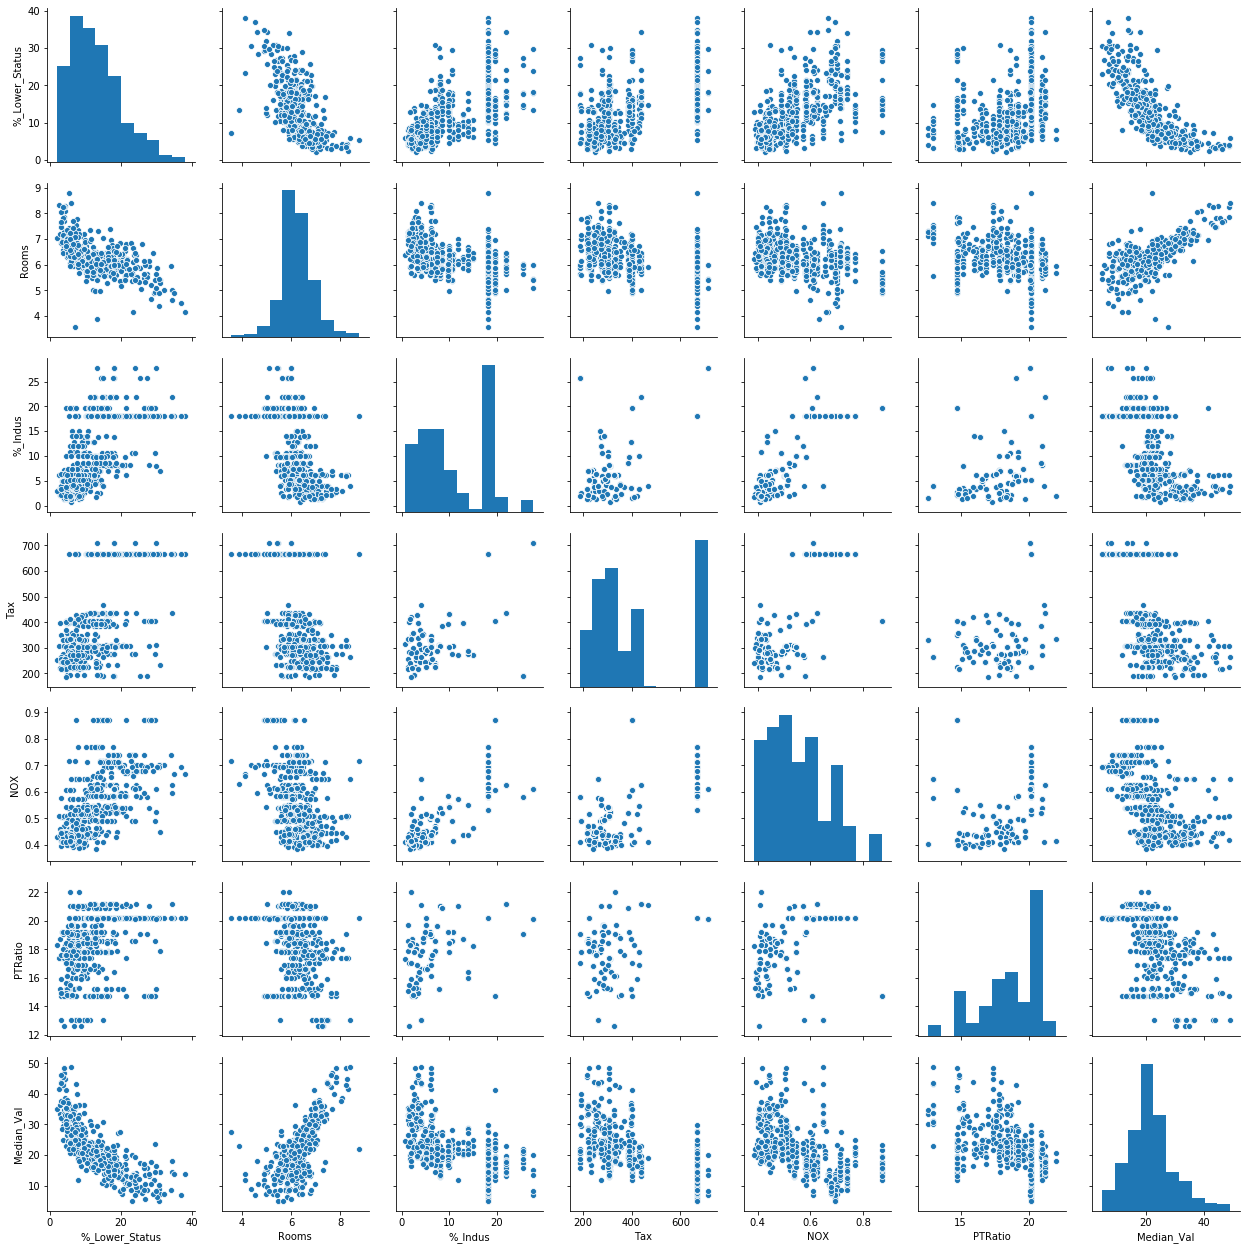

In [125]:
sns.pairplot(high_corr_features)

From looking at the right hand column of the pairplot above, I observed that only % Lower Status and number of Rooms had an obvious relationship with the Median Value. Furthermore, Tax, the % Industrial, and NOX were all corrolated with eachother making them bad features to include in the model.

#### 4.5.2.3 Filtering using F_regression

I also used this test to see if it identified any alternative features vs the corrolation test.

In [126]:
# modification of chi squared test code found here:
#https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
fregX = fifty_plus_removed.iloc[:, 0:13]  
fregy = fifty_plus_removed["Median_Val"]
fregX.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [127]:
bestfeatures = SelectKBest(score_func=f_regression, k=10) # show the top 10 best features
fregfit = bestfeatures.fit(fregX,fregy)
dfscores = pd.DataFrame(fregfit.scores_)
dfcolumns = pd.DataFrame(fregX.columns) 
fregfeatureScores = pd.concat([dfcolumns,dfscores],axis=1)
fregfeatureScores.columns = ['Features','Score']  #naming the dataframe columns
print(fregfeatureScores.nlargest(10,'Score'))  #print 10 best features

          Features       Score
12  %_Lower_Status  666.627892
5            Rooms  435.309814
2          %_Indus  274.507475
9              Tax  237.855059
4              NOX  185.148836
10         PTRatio  179.568192
6       %_Pre_1940  156.620474
8   Highway_Access  143.190234
0       Crime_Rate  123.991786
1    %_Large_Plots   95.527784


As with the corrolation test, % Lower Status and Rooms were identified as by far the best predictors.

### 4.5.3 Testing with Filtered Features

In this section I tested to if the performance of the model was improved by using only the two best predictors of the Median Value: % of Lower Status people and the number of Rooms.

In [128]:
# creating a new dataset containing the two inputs and target variable
filtered_features = fifty_plus_removed[["%_Lower_Status","Rooms","Median_Val"]]
filtered_features.head()

,%_Lower_Status,Rooms,Median_Val
0,4.98,6.575,24.0
1,9.14,6.421,21.6
2,4.03,7.185,34.7
3,2.94,6.998,33.4
4,5.33,7.147,36.2


In [129]:
# shuffle again and split into train and test
filtered_features = shuffle(filtered_features)

FFX = filtered_features.drop(labels=['Median_Val'], axis = 1)
FFy = filtered_features['Median_Val']

FFX_train, FFX_test, FFy_train, FFy_test = mod.train_test_split(FFX, FFy, test_size = 0.2)

In [130]:
#check how many datapoints are in the train and test batches
FFX_train.shape, FFX_test.shape

((392, 2), (98, 2))

In [131]:
# new filtered features model
FFm = ks.models.Sequential()
FFm.add(ks.layers.Dense(12, input_dim=2, activation="relu"))
FFm.add(ks.layers.Dense(1, activation="linear"))
FFm.compile(loss="mean_squared_error", optimizer="adam")
#FFes = EarlyStopping(monitor='loss', patience=20, verbose=1)

FFm.fit(FFX_train, FFy_train, epochs=300, batch_size=4)

Epoch 1/300
392/392 [==============================] - 0s 672us/step - loss: 431.2614
Epoch 2/300
392/392 [==============================] - 0s 447us/step - loss: 216.1579
Epoch 3/300
392/392 [==============================] - 0s 406us/step - loss: 148.2474
Epoch 4/300
392/392 [==============================] - 0s 427us/step - loss: 128.6770
Epoch 5/300
392/392 [==============================] - 0s 434us/step - loss: 112.8631
Epoch 6/300
392/392 [==============================] - 0s 429us/step - loss: 98.3978
Epoch 7/300
392/392 [==============================] - 0s 422us/step - loss: 84.1488
Epoch 8/300
392/392 [==============================] - 0s 429us/step - loss: 71.1057
Epoch 9/300
392/392 [==============================] - 0s 447us/step - loss: 59.2793
Epoch 10/300
392/392 [==============================] - 0s 447us/step - loss: 49.2701
Epoch 11/300
392/392 [==============================] - 0s 459us/step - loss: 41.1889
Epoch 12/300
392/392 [==============================] - 0s

392/392 [==============================] - 0s 436us/step - loss: 23.3005
Epoch 97/300
392/392 [==============================] - 0s 432us/step - loss: 22.8264
Epoch 98/300
392/392 [==============================] - 0s 384us/step - loss: 23.1924
Epoch 99/300
392/392 [==============================] - 0s 415us/step - loss: 23.2677
Epoch 100/300
392/392 [==============================] - 0s 428us/step - loss: 23.1465
Epoch 101/300
392/392 [==============================] - 0s 402us/step - loss: 23.1227
Epoch 102/300
392/392 [==============================] - 0s 400us/step - loss: 23.1376
Epoch 103/300
392/392 [==============================] - 0s 415us/step - loss: 22.8725
Epoch 104/300
392/392 [==============================] - 0s 440us/step - loss: 23.2811
Epoch 105/300
392/392 [==============================] - 0s 431us/step - loss: 23.1173
Epoch 106/300
392/392 [==============================] - 0s 398us/step - loss: 23.1141
Epoch 107/300
392/392 [==============================] - 0s 

392/392 [==============================] - 0s 427us/step - loss: 23.3374
Epoch 191/300
392/392 [==============================] - 0s 404us/step - loss: 23.0522
Epoch 192/300
392/392 [==============================] - 0s 424us/step - loss: 23.0527
Epoch 193/300
392/392 [==============================] - 0s 436us/step - loss: 23.0549
Epoch 194/300
392/392 [==============================] - 0s 426us/step - loss: 22.9081
Epoch 195/300
392/392 [==============================] - 0s 447us/step - loss: 22.9747
Epoch 196/300
392/392 [==============================] - 0s 382us/step - loss: 22.9451
Epoch 197/300
392/392 [==============================] - 0s 437us/step - loss: 23.4522
Epoch 198/300
392/392 [==============================] - 0s 434us/step - loss: 22.9929
Epoch 199/300
392/392 [==============================] - 0s 375us/step - loss: 22.9586
Epoch 200/300
392/392 [==============================] - 0s 434us/step - loss: 22.9458
Epoch 201/300
392/392 [==============================] - 

392/392 [==============================] - 0s 435us/step - loss: 22.9130
Epoch 285/300
392/392 [==============================] - 0s 429us/step - loss: 22.9077
Epoch 286/300
392/392 [==============================] - 0s 435us/step - loss: 23.0539
Epoch 287/300
392/392 [==============================] - 0s 428us/step - loss: 22.8253
Epoch 288/300
392/392 [==============================] - 0s 424us/step - loss: 22.9717
Epoch 289/300
392/392 [==============================] - 0s 416us/step - loss: 22.9353
Epoch 290/300
392/392 [==============================] - 0s 426us/step - loss: 23.1051
Epoch 291/300
392/392 [==============================] - 0s 434us/step - loss: 23.3990
Epoch 292/300
392/392 [==============================] - 0s 439us/step - loss: 22.9157
Epoch 293/300
392/392 [==============================] - 0s 427us/step - loss: 23.1912
Epoch 294/300
392/392 [==============================] - 0s 428us/step - loss: 22.9144
Epoch 295/300
392/392 [==============================] - 

In [132]:
FFm.evaluate(FFX_test, FFy_test)

98/98 [==============================] - 0s 150us/step


15.329063376601862

**Result:** The result was a MSE of 16.9, drastically worse than the Baseline Test and some of the better performing subsequent models.

#### 4.5.3.1 Filtered Features Standardisation

While initial results for the model using the filtered features were worse than the Baseline, the data had not been standardised yet. The logical next step was to standardise the filtered features and evaluate performance with that data.

In [133]:
#scaling the filtered features
scaler = pre.StandardScaler()
FFX_train = pd.DataFrame(scaler.fit_transform(FFX_train), columns=FFX.columns)
FFX_test = pd.DataFrame(scaler.transform(FFX_test), columns=FFX.columns)

In [134]:
FFX_train.head()

,%_Lower_Status,Rooms
0,0.697024,-0.434424
1,0.474201,-0.907146
2,-1.095189,1.047350
3,-0.484488,0.584747
4,-0.245160,-0.722105


In [135]:
# model test with normalised input features 

FFm = ks.models.Sequential()
FFm.add(ks.layers.Dense(12, input_dim=2, activation="relu"))
FFm.add(ks.layers.Dense(1, activation="linear"))
FFm.compile(loss="mean_squared_error", optimizer="adam")
#FFes = EarlyStopping(monitor='loss', patience=20, verbose=1)

FFm.fit(FFX_train, FFy_train, epochs=300, batch_size=4)

Epoch 1/300
392/392 [==============================] - 0s 734us/step - loss: 514.8740
Epoch 2/300
392/392 [==============================] - 0s 380us/step - loss: 492.2415
Epoch 3/300
392/392 [==============================] - 0s 334us/step - loss: 463.1585
Epoch 4/300
392/392 [==============================] - 0s 438us/step - loss: 425.5215
Epoch 5/300
392/392 [==============================] - 0s 450us/step - loss: 377.4128
Epoch 6/300
392/392 [==============================] - 0s 473us/step - loss: 318.1999
Epoch 7/300
392/392 [==============================] - 0s 432us/step - loss: 251.8227
Epoch 8/300
392/392 [==============================] - 0s 414us/step - loss: 185.4827
Epoch 9/300
392/392 [==============================] - 0s 390us/step - loss: 127.9009
Epoch 10/300
392/392 [==============================] - 0s 400us/step - loss: 83.5923
Epoch 11/300
392/392 [==============================] - 0s 430us/step - loss: 53.0860
Epoch 12/300
392/392 [==============================] 

392/392 [==============================] - 0s 466us/step - loss: 14.1341
Epoch 97/300
392/392 [==============================] - 0s 442us/step - loss: 14.0889
Epoch 98/300
392/392 [==============================] - 0s 457us/step - loss: 14.0829
Epoch 99/300
392/392 [==============================] - 0s 465us/step - loss: 14.0902
Epoch 100/300
392/392 [==============================] - 0s 450us/step - loss: 14.0630
Epoch 101/300
392/392 [==============================] - 0s 449us/step - loss: 14.0560
Epoch 102/300
392/392 [==============================] - 0s 444us/step - loss: 14.0600
Epoch 103/300
392/392 [==============================] - 0s 467us/step - loss: 13.9912
Epoch 104/300
392/392 [==============================] - 0s 439us/step - loss: 14.0017
Epoch 105/300
392/392 [==============================] - 0s 446us/step - loss: 13.9726
Epoch 106/300
392/392 [==============================] - 0s 457us/step - loss: 13.9923
Epoch 107/300
392/392 [==============================] - 0s 

392/392 [==============================] - 0s 448us/step - loss: 13.5871
Epoch 191/300
392/392 [==============================] - 0s 458us/step - loss: 13.6140
Epoch 192/300
392/392 [==============================] - 0s 448us/step - loss: 13.5990
Epoch 193/300
392/392 [==============================] - 0s 457us/step - loss: 13.5945
Epoch 194/300
392/392 [==============================] - 0s 468us/step - loss: 13.6227
Epoch 195/300
392/392 [==============================] - 0s 461us/step - loss: 13.5729
Epoch 196/300
392/392 [==============================] - 0s 455us/step - loss: 13.6229
Epoch 197/300
392/392 [==============================] - 0s 466us/step - loss: 13.5711
Epoch 198/300
392/392 [==============================] - 0s 459us/step - loss: 13.5832
Epoch 199/300
392/392 [==============================] - 0s 458us/step - loss: 13.5821
Epoch 200/300
392/392 [==============================] - 0s 443us/step - loss: 13.6137
Epoch 201/300
392/392 [==============================] - 

392/392 [==============================] - 0s 459us/step - loss: 13.5372
Epoch 285/300
392/392 [==============================] - 0s 444us/step - loss: 13.5192
Epoch 286/300
392/392 [==============================] - 0s 456us/step - loss: 13.5366
Epoch 287/300
392/392 [==============================] - 0s 459us/step - loss: 13.5542
Epoch 288/300
392/392 [==============================] - 0s 458us/step - loss: 13.5581
Epoch 289/300
392/392 [==============================] - 0s 446us/step - loss: 13.5229
Epoch 290/300
392/392 [==============================] - 0s 451us/step - loss: 13.5097
Epoch 291/300
392/392 [==============================] - 0s 449us/step - loss: 13.5070
Epoch 292/300
392/392 [==============================] - 0s 462us/step - loss: 13.5342
Epoch 293/300
392/392 [==============================] - 0s 445us/step - loss: 13.5627
Epoch 294/300
392/392 [==============================] - 0s 463us/step - loss: 13.5060
Epoch 295/300
392/392 [==============================] - 

In [136]:
FFm.evaluate(FFX_test, FFy_test)

98/98 [==============================] - 0s 199us/step


11.58915188847756

**Result:** MSE was 18.124

Even after the standardisation the performance of the model still failed by a wide marginto beat the Baseline test where all 13 features where included.

#### 4.5.3.2 Filtered Features - Comparing Various Model Configurations

To be sure that not improvements using the filtered set were possible I tested serveral different model configurations. 

In [137]:
# function to test various model configurations on the filter features dataset
def FF_tester(layer_size1, layer_size2, batch_S, OPT):
    counter = 0
    results = []
    while counter < 5:
        FFm = ks.models.Sequential()
        FFm.add(ks.layers.Dense(layer_size1, input_dim=2, activation="relu"))
        FFm.add(ks.layers.Dense(layer_size2, activation="relu"))
        FFm.add(ks.layers.Dense(1,activation="linear"))

        FFm.compile(loss="mean_squared_error", optimizer=OPT)

        FFes = EarlyStopping(monitor='loss', patience=20, verbose=1)

        FFm.fit(FFX_train, FFy_train, epochs=300, batch_size=batch_S, callbacks=[FFes])

        result_units = FFm.evaluate(FFX_test, FFy_test)

        counter += 1

        results.append(result_units)
   
        
    avg_result = sum(results) / 5
    return avg_result

In [138]:
#big_all_adam = FF_tester(64,64,32,"adam") # large layers, large batches, adam optimizer
#big_all_adam

In [139]:
#bigLayer_mediumbatch_adam = FF_tester(64,64,16,"adam") # large layers, large batches, adam optimizer
#bigLayer_smallbatch_adam = FF_tester(64,64,4,"adam")

In [140]:
#print(bigLayer_mediumbatch_adam)

In [141]:
# print(bigLayer_smallbatch_adam)

In [142]:
# mediumLayer_bigbatch_adam = FF_tester(32,12,32,"adam")
# mediumLayer_mediumbatch_adam  = FF_tester(32,12,16,"adam")
# mediumLayer_smallbatch_adam  = FF_tester(32,12,4,"adam")

In [143]:
# print(mediumLayer_bigbatch_adam)
# print(mediumLayer_mediumbatch_adam)
# print(mediumLayer_smallbatch_adam)

In [144]:
#smallLayer_bigbatch_adam  = FF_tester(12,6,32,"adam")
#smallLayer_mediumbatch_adam  = FF_tester(12,6,16,"adam")
#smallLayer_smallbatch_adam  = FF_tester(12,6,4,"adam")
# tinyLayer_smallbatch_adam = FF_tester(2,2,4,"adam")

In [145]:
# print(smallLayer_bigbatch_adam)
# print(smallLayer_mediumbatch_adam)
# print(smallLayer_smallbatch_adam)
# print(tinyLayer_smallbatch_adam)

**Result:** Medium layer sizes seemed to peform the best, but still did not better the original baseline test. Next I tried removing a layer.

In [146]:
def FF_tester_1layer(layer_size1, batch_S, OPT):
    counter = 0
    results = []
    while counter < 5:
        FFm = ks.models.Sequential()
        FFm.add(ks.layers.Dense(layer_size1, input_dim=2, activation="relu"))
        FFm.add(ks.layers.Dense(1,activation="linear"))

        FFm.compile(loss="mean_squared_error", optimizer=OPT)

        FFes = EarlyStopping(monitor='loss', patience=20, verbose=1)

        FFm.fit(FFX_train, FFy_train, epochs=300, batch_size=batch_S, callbacks=[FFes])

        result_units = FFm.evaluate(FFX_test, FFy_test)

        counter += 1

        results.append(result_units)
   
        
    avg_result = sum(results) / 5
    return avg_result

In [147]:
# hugelayer = FF_tester_1layer(64, 4, "adam")
# biglayer = FF_tester_1layer(32, 4, "adam")
# mediumlayer = FF_tester_1layer(12, 4, "adam")
# smalllayer = FF_tester_1layer(6, 4, "adam")


In [148]:
# print(hugelayer)
# print(biglayer)
# print(mediumlayer)
# print(smalllayer)

**Result:** Again, there didn't seem to be any drastic improvements and the results were still not beating the initial Baseline Test on all features. 

## 4.6 Conclusion and Final Model

In this final section, I retested the best performing models from above to determine the final model. For the re-test I used the dataset with all variables included, but with the samples that had a Median Value of 50,000 removed. 

In [149]:
final_model_df = fifty_plus_removed
final_model_df.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [150]:
# suffling the data 
final_model_df = shuffle(final_model_df)
final_model_df

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
6,0.08829,12.5,7.87,0.0,0.5240,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43,22.9
330,0.04544,0.0,3.24,0.0,0.4600,6.144,32.2,5.8736,4.0,430.0,16.9,368.57,9.09,19.8
280,0.03578,20.0,3.33,0.0,0.4429,7.820,64.5,4.6947,5.0,216.0,14.9,387.31,3.76,45.4
360,4.54192,0.0,18.10,0.0,0.7700,6.398,88.0,2.5182,24.0,666.0,20.2,374.56,7.79,25.0
39,0.02763,75.0,2.95,0.0,0.4280,6.595,21.8,5.4011,3.0,252.0,18.3,395.63,4.32,30.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,0.21161,0.0,8.56,0.0,0.5200,6.137,87.4,2.7147,5.0,384.0,20.9,394.47,13.44,19.3
169,2.44953,0.0,19.58,0.0,0.6050,6.402,95.2,2.2625,5.0,403.0,14.7,330.04,11.32,22.3
272,0.11460,20.0,6.96,0.0,0.4640,6.538,58.7,3.9175,3.0,223.0,18.6,394.96,7.73,24.4
34,1.61282,0.0,8.14,0.0,0.5380,6.096,96.9,3.7598,4.0,307.0,21.0,248.31,20.34,13.5


In [151]:
# creating the input and out datasets for the final tests
FinalX = final_model_df.drop(labels=['Median_Val'], axis = 1)
Finaly = final_model_df['Median_Val']

FinalX_train, FinalX_test, Finaly_train, Finaly_test = mod.train_test_split(FinalX, Finaly, test_size = 0.2)

In [152]:
FinalX.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status
6,0.08829,12.5,7.87,0.0,0.5240,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43
330,0.04544,0.0,3.24,0.0,0.4600,6.144,32.2,5.8736,4.0,430.0,16.9,368.57,9.09
280,0.03578,20.0,3.33,0.0,0.4429,7.820,64.5,4.6947,5.0,216.0,14.9,387.31,3.76
360,4.54192,0.0,18.10,0.0,0.7700,6.398,88.0,2.5182,24.0,666.0,20.2,374.56,7.79
39,0.02763,75.0,2.95,0.0,0.4280,6.595,21.8,5.4011,3.0,252.0,18.3,395.63,4.32


In [153]:
# scaling the data
scaler = pre.StandardScaler()
FinalX_train = pd.DataFrame(scaler.fit_transform(FinalX_train), columns=FinalX.columns)
FinalX_test = pd.DataFrame(scaler.transform(FinalX_test), columns=FinalX.columns)

In [154]:
FinalX_train.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status
0,-0.336048,-0.496072,1.609434,-0.243843,0.580916,0.196794,1.090341,-0.737732,-0.635393,0.166628,1.295196,0.344561,-0.245346
1,-0.374289,-0.496072,-0.191517,-0.243843,0.253896,-0.363710,-0.062614,-0.699410,-0.406465,-0.106372,0.338142,0.460289,0.013005
2,-0.399657,0.286027,-1.280944,-0.243843,-0.140205,0.519123,-0.066150,0.089038,-0.978786,-0.670175,-1.528111,0.460289,-1.126614
3,-0.396913,3.631675,-1.404944,-0.243843,-1.272196,1.154255,-1.830949,1.760498,-0.749857,-0.041089,-0.714616,0.460289,-1.186896
4,-0.390426,-0.496072,-1.258801,-0.243843,-0.559461,1.440065,0.888751,-0.562678,-0.749857,-1.281457,-0.331795,0.431409,-1.149578


In [155]:
#test final model option 1
def Final_tester(layer_size1, layer_size2):
    counter = 0
    results = []
    while counter < 5:
        m = ks.models.Sequential()
        m.add(ks.layers.Dense(layer_size1, input_dim=13, activation="relu"))
        m.add(ks.layers.Dense(layer_size2, activation="relu"))
        m.add(ks.layers.Dense(1,activation="linear"))

        m.compile(loss="mean_squared_error", optimizer="adam")

        es = EarlyStopping(monitor='loss', patience=20, verbose=1)

        m.fit(FinalX_train, Finaly_train, epochs=300, batch_size=4, callbacks=[es])

        result_units = m.evaluate(FinalX_test, Finaly_test)

        counter += 1

        results.append(result_units)
   
        
    avg_result = sum(results) / 5
    return avg_result

In [156]:
final_results = [
    Final_tester(13, 13),
    Final_tester(26, 26),
    Final_tester(26, 13),
    Final_tester(52, 26),
    Final_tester(64, 13)
]

Epoch 1/300
392/392 [==============================] - 0s 748us/step - loss: 499.5007
Epoch 2/300
392/392 [==============================] - 0s 467us/step - loss: 360.2818
Epoch 3/300
392/392 [==============================] - 0s 502us/step - loss: 176.5547
Epoch 4/300
392/392 [==============================] - 0s 451us/step - loss: 66.6350
Epoch 5/300
392/392 [==============================] - 0s 449us/step - loss: 39.6857
Epoch 6/300
392/392 [==============================] - 0s 449us/step - loss: 29.0207
Epoch 7/300
392/392 [==============================] - 0s 454us/step - loss: 23.5278
Epoch 8/300
392/392 [==============================] - 0s 464us/step - loss: 20.1926
Epoch 9/300
392/392 [==============================] - 0s 473us/step - loss: 18.1186
Epoch 10/300
392/392 [==============================] - 0s 501us/step - loss: 16.7482
Epoch 11/300
392/392 [==============================] - 0s 524us/step - loss: 15.6965
Epoch 12/300
392/392 [==============================] - 0s 5

392/392 [==============================] - 0s 503us/step - loss: 4.9767
Epoch 98/300
392/392 [==============================] - 0s 495us/step - loss: 5.0059
Epoch 99/300
392/392 [==============================] - 0s 497us/step - loss: 4.9354
Epoch 100/300
392/392 [==============================] - 0s 490us/step - loss: 4.8297
Epoch 101/300
392/392 [==============================] - 0s 490us/step - loss: 4.9670
Epoch 102/300
392/392 [==============================] - 0s 497us/step - loss: 4.8051
Epoch 103/300
392/392 [==============================] - 0s 497us/step - loss: 4.8344
Epoch 104/300
392/392 [==============================] - 0s 496us/step - loss: 4.7041
Epoch 105/300
392/392 [==============================] - 0s 483us/step - loss: 4.6495
Epoch 106/300
392/392 [==============================] - 0s 484us/step - loss: 4.6314
Epoch 107/300
392/392 [==============================] - 0s 497us/step - loss: 4.6722
Epoch 108/300
392/392 [==============================] - 0s 503us/step

392/392 [==============================] - 0s 420us/step - loss: 3.2356
Epoch 193/300
392/392 [==============================] - 0s 476us/step - loss: 3.2831
Epoch 194/300
392/392 [==============================] - 0s 500us/step - loss: 3.1841
Epoch 195/300
392/392 [==============================] - 0s 495us/step - loss: 3.1811
Epoch 196/300
392/392 [==============================] - 0s 494us/step - loss: 3.2278
Epoch 197/300
392/392 [==============================] - 0s 496us/step - loss: 3.2617
Epoch 198/300
392/392 [==============================] - 0s 485us/step - loss: 3.1762
Epoch 199/300
392/392 [==============================] - 0s 504us/step - loss: 3.1915
Epoch 200/300
392/392 [==============================] - 0s 454us/step - loss: 3.2067
Epoch 201/300
392/392 [==============================] - 0s 434us/step - loss: 3.1840
Epoch 202/300
392/392 [==============================] - 0s 498us/step - loss: 3.1692
Epoch 203/300
392/392 [==============================] - 0s 437us/st

392/392 [==============================] - 0s 430us/step - loss: 2.6659
Epoch 288/300
392/392 [==============================] - 0s 411us/step - loss: 2.7022
Epoch 289/300
392/392 [==============================] - 0s 416us/step - loss: 2.6381
Epoch 290/300
392/392 [==============================] - 0s 415us/step - loss: 2.6362
Epoch 291/300
392/392 [==============================] - 0s 419us/step - loss: 2.6402
Epoch 292/300
392/392 [==============================] - 0s 491us/step - loss: 2.6123
Epoch 293/300
392/392 [==============================] - 0s 420us/step - loss: 2.6168
Epoch 294/300
392/392 [==============================] - 0s 418us/step - loss: 2.6305
Epoch 295/300
392/392 [==============================] - 0s 427us/step - loss: 2.5591
Epoch 296/300
392/392 [==============================] - 0s 420us/step - loss: 2.6545
Epoch 297/300
392/392 [==============================] - 0s 412us/step - loss: 2.6504
Epoch 298/300
392/392 [==============================] - 0s 417us/st

392/392 [==============================] - 0s 468us/step - loss: 5.6196
Epoch 83/300
392/392 [==============================] - 0s 476us/step - loss: 5.5959
Epoch 84/300
392/392 [==============================] - 0s 463us/step - loss: 5.5227
Epoch 85/300
392/392 [==============================] - 0s 468us/step - loss: 5.5661
Epoch 86/300
392/392 [==============================] - 0s 464us/step - loss: 5.5519
Epoch 87/300
392/392 [==============================] - 0s 460us/step - loss: 5.4481
Epoch 88/300
392/392 [==============================] - 0s 468us/step - loss: 5.3688
Epoch 89/300
392/392 [==============================] - 0s 458us/step - loss: 5.4255
Epoch 90/300
392/392 [==============================] - 0s 468us/step - loss: 5.4732
Epoch 91/300
392/392 [==============================] - 0s 471us/step - loss: 5.4114
Epoch 92/300
392/392 [==============================] - 0s 463us/step - loss: 5.3986
Epoch 93/300
392/392 [==============================] - 0s 468us/step - loss: 

392/392 [==============================] - 0s 409us/step - loss: 4.1377
Epoch 178/300
392/392 [==============================] - 0s 388us/step - loss: 4.0521
Epoch 179/300
392/392 [==============================] - 0s 461us/step - loss: 4.0628
Epoch 180/300
392/392 [==============================] - 0s 441us/step - loss: 4.1792
Epoch 181/300
392/392 [==============================] - 0s 471us/step - loss: 4.0521
Epoch 182/300
392/392 [==============================] - 0s 448us/step - loss: 4.0194
Epoch 183/300
392/392 [==============================] - 0s 427us/step - loss: 4.0378
Epoch 184/300
392/392 [==============================] - 0s 470us/step - loss: 4.0197
Epoch 185/300
392/392 [==============================] - 0s 451us/step - loss: 3.9837
Epoch 186/300
392/392 [==============================] - 0s 478us/step - loss: 4.0450
Epoch 187/300
392/392 [==============================] - 0s 437us/step - loss: 4.0071
Epoch 188/300
392/392 [==============================] - 0s 423us/st

Epoch 272/300
392/392 [==============================] - 0s 465us/step - loss: 3.3929
Epoch 273/300
392/392 [==============================] - 0s 460us/step - loss: 3.3013
Epoch 274/300
392/392 [==============================] - 0s 455us/step - loss: 3.3222
Epoch 275/300
392/392 [==============================] - 0s 450us/step - loss: 3.4196
Epoch 276/300
392/392 [==============================] - 0s 451us/step - loss: 3.3091
Epoch 277/300
392/392 [==============================] - 0s 469us/step - loss: 3.3879 0s - loss: 3.48
Epoch 278/300
392/392 [==============================] - 0s 462us/step - loss: 3.3454
Epoch 279/300
392/392 [==============================] - 0s 463us/step - loss: 3.2733
Epoch 280/300
392/392 [==============================] - 0s 451us/step - loss: 3.3038
Epoch 281/300
392/392 [==============================] - 0s 459us/step - loss: 3.3163
Epoch 282/300
392/392 [==============================] - 0s 465us/step - loss: 3.3354
Epoch 283/300
392/392 [===============

392/392 [==============================] - 0s 308us/step - loss: 5.7566
Epoch 67/300
392/392 [==============================] - 0s 320us/step - loss: 5.7618
Epoch 68/300
392/392 [==============================] - 0s 336us/step - loss: 5.7015
Epoch 69/300
392/392 [==============================] - 0s 346us/step - loss: 5.6709
Epoch 70/300
392/392 [==============================] - 0s 332us/step - loss: 5.7612
Epoch 71/300
392/392 [==============================] - 0s 332us/step - loss: 5.7226
Epoch 72/300
392/392 [==============================] - 0s 299us/step - loss: 5.7817
Epoch 73/300
392/392 [==============================] - 0s 339us/step - loss: 5.5626
Epoch 74/300
392/392 [==============================] - 0s 341us/step - loss: 5.5508
Epoch 75/300
392/392 [==============================] - 0s 325us/step - loss: 5.5533
Epoch 76/300
392/392 [==============================] - 0s 337us/step - loss: 5.4787
Epoch 77/300
392/392 [==============================] - 0s 336us/step - loss: 

392/392 [==============================] - 0s 318us/step - loss: 4.4344
Epoch 162/300
392/392 [==============================] - 0s 339us/step - loss: 4.4462
Epoch 163/300
392/392 [==============================] - 0s 317us/step - loss: 4.3969
Epoch 164/300
392/392 [==============================] - 0s 337us/step - loss: 4.3644
Epoch 165/300
392/392 [==============================] - 0s 336us/step - loss: 4.3614
Epoch 166/300
392/392 [==============================] - 0s 329us/step - loss: 4.5100
Epoch 167/300
392/392 [==============================] - 0s 320us/step - loss: 4.4203
Epoch 168/300
392/392 [==============================] - 0s 336us/step - loss: 4.4027
Epoch 169/300
392/392 [==============================] - 0s 334us/step - loss: 4.2853
Epoch 170/300
392/392 [==============================] - 0s 321us/step - loss: 4.2932
Epoch 171/300
392/392 [==============================] - 0s 314us/step - loss: 4.2680
Epoch 172/300
392/392 [==============================] - 0s 325us/st

Epoch 256/300
392/392 [==============================] - 0s 299us/step - loss: 3.7116
Epoch 257/300
392/392 [==============================] - 0s 317us/step - loss: 3.7534
Epoch 258/300
392/392 [==============================] - 0s 307us/step - loss: 3.7110
Epoch 259/300
392/392 [==============================] - 0s 303us/step - loss: 3.7853
Epoch 260/300
392/392 [==============================] - 0s 318us/step - loss: 3.8061
Epoch 261/300
392/392 [==============================] - 0s 315us/step - loss: 3.7353
Epoch 262/300
392/392 [==============================] - 0s 322us/step - loss: 3.8500
Epoch 263/300
392/392 [==============================] - 0s 318us/step - loss: 3.7583
Epoch 264/300
392/392 [==============================] - 0s 321us/step - loss: 3.7396
Epoch 265/300
392/392 [==============================] - 0s 322us/step - loss: 3.7254
Epoch 266/300
392/392 [==============================] - 0s 323us/step - loss: 3.7897
Epoch 267/300
392/392 [==============================]

392/392 [==============================] - 0s 285us/step - loss: 6.4320
Epoch 52/300
392/392 [==============================] - 0s 299us/step - loss: 6.4898
Epoch 53/300
392/392 [==============================] - 0s 311us/step - loss: 6.3996
Epoch 54/300
392/392 [==============================] - 0s 291us/step - loss: 6.1988
Epoch 55/300
392/392 [==============================] - 0s 275us/step - loss: 6.2947
Epoch 56/300
392/392 [==============================] - 0s 302us/step - loss: 6.3457
Epoch 57/300
392/392 [==============================] - 0s 280us/step - loss: 6.2210
Epoch 58/300
392/392 [==============================] - 0s 288us/step - loss: 6.2737
Epoch 59/300
392/392 [==============================] - 0s 288us/step - loss: 6.1071
Epoch 60/300
392/392 [==============================] - 0s 287us/step - loss: 6.2049
Epoch 61/300
392/392 [==============================] - 0s 297us/step - loss: 6.1638
Epoch 62/300
392/392 [==============================] - 0s 306us/step - loss: 

Epoch 147/300
392/392 [==============================] - 0s 290us/step - loss: 4.8900
Epoch 148/300
392/392 [==============================] - 0s 289us/step - loss: 4.7641
Epoch 149/300
392/392 [==============================] - 0s 311us/step - loss: 4.9454
Epoch 150/300
392/392 [==============================] - 0s 290us/step - loss: 4.8071
Epoch 151/300
392/392 [==============================] - 0s 301us/step - loss: 4.9378
Epoch 152/300
392/392 [==============================] - 0s 272us/step - loss: 4.7327
Epoch 153/300
392/392 [==============================] - 0s 285us/step - loss: 4.7732
Epoch 154/300
392/392 [==============================] - 0s 321us/step - loss: 4.7010
Epoch 155/300
392/392 [==============================] - 0s 285us/step - loss: 4.7268
Epoch 156/300
392/392 [==============================] - ETA: 0s - loss: 4.691 - 0s 314us/step - loss: 4.7644
Epoch 157/300
392/392 [==============================] - 0s 296us/step - loss: 4.7331
Epoch 158/300
392/392 [=======

Epoch 242/300
392/392 [==============================] - 0s 280us/step - loss: 3.8684
Epoch 243/300
392/392 [==============================] - 0s 301us/step - loss: 3.6931
Epoch 244/300
392/392 [==============================] - 0s 300us/step - loss: 3.7632
Epoch 245/300
392/392 [==============================] - 0s 295us/step - loss: 3.8268
Epoch 246/300
392/392 [==============================] - 0s 301us/step - loss: 3.7953
Epoch 247/300
392/392 [==============================] - 0s 303us/step - loss: 3.7478
Epoch 248/300
392/392 [==============================] - 0s 297us/step - loss: 3.8453
Epoch 249/300
392/392 [==============================] - 0s 299us/step - loss: 3.8368
Epoch 250/300
392/392 [==============================] - 0s 298us/step - loss: 3.6313
Epoch 251/300
392/392 [==============================] - 0s 299us/step - loss: 3.6597
Epoch 252/300
392/392 [==============================] - 0s 296us/step - loss: 3.6603
Epoch 253/300
392/392 [==============================]

392/392 [==============================] - 0s 291us/step - loss: 7.1167
Epoch 37/300
392/392 [==============================] - 0s 307us/step - loss: 7.1404
Epoch 38/300
392/392 [==============================] - 0s 349us/step - loss: 6.9579
Epoch 39/300
392/392 [==============================] - 0s 345us/step - loss: 6.8043
Epoch 40/300
392/392 [==============================] - 0s 340us/step - loss: 6.8684
Epoch 41/300
392/392 [==============================] - 0s 323us/step - loss: 6.9157
Epoch 42/300
392/392 [==============================] - 0s 315us/step - loss: 6.8028
Epoch 43/300
392/392 [==============================] - 0s 318us/step - loss: 6.7203
Epoch 44/300
392/392 [==============================] - ETA: 0s - loss: 6.049 - 0s 327us/step - loss: 6.6069
Epoch 45/300
392/392 [==============================] - 0s 332us/step - loss: 6.6151
Epoch 46/300
392/392 [==============================] - 0s 342us/step - loss: 6.4874
Epoch 47/300
392/392 [==============================] 

392/392 [==============================] - 0s 309us/step - loss: 4.6276
Epoch 132/300
392/392 [==============================] - 0s 327us/step - loss: 4.6113
Epoch 133/300
392/392 [==============================] - 0s 322us/step - loss: 4.6713
Epoch 134/300
392/392 [==============================] - 0s 324us/step - loss: 4.6424
Epoch 135/300
392/392 [==============================] - 0s 323us/step - loss: 4.6168
Epoch 136/300
392/392 [==============================] - 0s 317us/step - loss: 4.4776
Epoch 137/300
392/392 [==============================] - 0s 329us/step - loss: 4.5691
Epoch 138/300
392/392 [==============================] - 0s 339us/step - loss: 4.6024
Epoch 139/300
392/392 [==============================] - 0s 283us/step - loss: 4.5104 0s - loss: 4.876
Epoch 140/300
392/392 [==============================] - 0s 292us/step - loss: 4.5524
Epoch 141/300
392/392 [==============================] - 0s 298us/step - loss: 4.4878
Epoch 142/300
392/392 [============================

392/392 [==============================] - 0s 338us/step - loss: 3.8393
Epoch 227/300
392/392 [==============================] - 0s 340us/step - loss: 3.8686
Epoch 228/300
392/392 [==============================] - 0s 340us/step - loss: 3.7961
Epoch 229/300
392/392 [==============================] - 0s 340us/step - loss: 3.8361
Epoch 230/300
392/392 [==============================] - 0s 341us/step - loss: 3.8514
Epoch 231/300
392/392 [==============================] - 0s 329us/step - loss: 3.8136
Epoch 232/300
392/392 [==============================] - 0s 349us/step - loss: 3.7414
Epoch 233/300
392/392 [==============================] - 0s 354us/step - loss: 3.8426
Epoch 234/300
392/392 [==============================] - 0s 329us/step - loss: 3.7666
Epoch 235/300
392/392 [==============================] - 0s 335us/step - loss: 3.7238
Epoch 236/300
392/392 [==============================] - 0s 350us/step - loss: 3.7435
Epoch 237/300
392/392 [==============================] - 0s 346us/st

Epoch 21/300
392/392 [==============================] - 0s 320us/step - loss: 7.8168
Epoch 22/300
392/392 [==============================] - 0s 330us/step - loss: 7.7516
Epoch 23/300
392/392 [==============================] - 0s 328us/step - loss: 7.4976
Epoch 24/300
392/392 [==============================] - 0s 339us/step - loss: 7.5608
Epoch 25/300
392/392 [==============================] - 0s 334us/step - loss: 7.3046
Epoch 26/300
392/392 [==============================] - 0s 336us/step - loss: 7.1932
Epoch 27/300
392/392 [==============================] - 0s 343us/step - loss: 7.0520
Epoch 28/300
392/392 [==============================] - 0s 342us/step - loss: 6.8985
Epoch 29/300
392/392 [==============================] - 0s 326us/step - loss: 6.9867
Epoch 30/300
392/392 [==============================] - 0s 325us/step - loss: 6.8030
Epoch 31/300
392/392 [==============================] - 0s 352us/step - loss: 6.6746
Epoch 32/300
392/392 [==============================] - 0s 335us/

392/392 [==============================] - 0s 303us/step - loss: 2.9613
Epoch 118/300
392/392 [==============================] - 0s 342us/step - loss: 2.9699
Epoch 119/300
392/392 [==============================] - 0s 309us/step - loss: 2.9555
Epoch 120/300
392/392 [==============================] - 0s 331us/step - loss: 3.0131
Epoch 121/300
392/392 [==============================] - 0s 332us/step - loss: 3.0036
Epoch 122/300
392/392 [==============================] - 0s 331us/step - loss: 3.0264
Epoch 123/300
392/392 [==============================] - 0s 313us/step - loss: 2.9288
Epoch 124/300
392/392 [==============================] - 0s 356us/step - loss: 2.7951
Epoch 125/300
392/392 [==============================] - 0s 332us/step - loss: 3.1268
Epoch 126/300
392/392 [==============================] - 0s 331us/step - loss: 2.9133
Epoch 127/300
392/392 [==============================] - 0s 309us/step - loss: 2.8323
Epoch 128/300
392/392 [==============================] - 0s 338us/st

392/392 [==============================] - 0s 322us/step - loss: 1.8945
Epoch 213/300
392/392 [==============================] - 0s 328us/step - loss: 1.8849
Epoch 214/300
392/392 [==============================] - 0s 341us/step - loss: 1.8629
Epoch 215/300
392/392 [==============================] - 0s 324us/step - loss: 1.8677
Epoch 216/300
392/392 [==============================] - 0s 307us/step - loss: 1.9363
Epoch 217/300
392/392 [==============================] - 0s 306us/step - loss: 1.7404
Epoch 218/300
392/392 [==============================] - 0s 302us/step - loss: 1.8807
Epoch 219/300
392/392 [==============================] - 0s 308us/step - loss: 1.8864
Epoch 220/300
392/392 [==============================] - 0s 329us/step - loss: 1.7549
Epoch 221/300
392/392 [==============================] - 0s 316us/step - loss: 1.9080
Epoch 222/300
392/392 [==============================] - 0s 343us/step - loss: 1.8444
Epoch 223/300
392/392 [==============================] - 0s 325us/st

392/392 [==============================] - 0s 315us/step - loss: 11.1105
Epoch 12/300
392/392 [==============================] - 0s 306us/step - loss: 10.4986
Epoch 13/300
392/392 [==============================] - 0s 358us/step - loss: 9.9193
Epoch 14/300
392/392 [==============================] - 0s 325us/step - loss: 9.5837
Epoch 15/300
392/392 [==============================] - 0s 339us/step - loss: 9.1723
Epoch 16/300
392/392 [==============================] - 0s 341us/step - loss: 8.7887
Epoch 17/300
392/392 [==============================] - 0s 329us/step - loss: 8.5651
Epoch 18/300
392/392 [==============================] - 0s 331us/step - loss: 8.3618
Epoch 19/300
392/392 [==============================] - 0s 347us/step - loss: 8.1483
Epoch 20/300
392/392 [==============================] - 0s 339us/step - loss: 8.0000
Epoch 21/300
392/392 [==============================] - 0s 319us/step - loss: 7.7281
Epoch 22/300
392/392 [==============================] - 0s 318us/step - loss

392/392 [==============================] - 0s 337us/step - loss: 3.4444
Epoch 108/300
392/392 [==============================] - 0s 351us/step - loss: 3.4441
Epoch 109/300
392/392 [==============================] - 0s 314us/step - loss: 3.3715
Epoch 110/300
392/392 [==============================] - 0s 359us/step - loss: 3.4100
Epoch 111/300
392/392 [==============================] - 0s 336us/step - loss: 3.2962
Epoch 112/300
392/392 [==============================] - 0s 339us/step - loss: 3.3574
Epoch 113/300
392/392 [==============================] - 0s 321us/step - loss: 3.2210
Epoch 114/300
392/392 [==============================] - 0s 359us/step - loss: 3.3099
Epoch 115/300
392/392 [==============================] - 0s 329us/step - loss: 3.3208
Epoch 116/300
392/392 [==============================] - 0s 333us/step - loss: 3.1125
Epoch 117/300
392/392 [==============================] - 0s 316us/step - loss: 3.2112
Epoch 118/300
392/392 [==============================] - 0s 309us/st

392/392 [==============================] - 0s 466us/step - loss: 2.0089
Epoch 203/300
392/392 [==============================] - 0s 465us/step - loss: 1.9048
Epoch 204/300
392/392 [==============================] - 0s 463us/step - loss: 1.8343
Epoch 205/300
392/392 [==============================] - 0s 460us/step - loss: 1.8655
Epoch 206/300
392/392 [==============================] - 0s 476us/step - loss: 1.8786
Epoch 207/300
392/392 [==============================] - 0s 475us/step - loss: 1.8929
Epoch 208/300
392/392 [==============================] - 0s 465us/step - loss: 1.8800
Epoch 209/300
392/392 [==============================] - 0s 459us/step - loss: 1.7331
Epoch 210/300
392/392 [==============================] - 0s 477us/step - loss: 1.8002
Epoch 211/300
392/392 [==============================] - 0s 465us/step - loss: 1.7916
Epoch 212/300
392/392 [==============================] - 0s 468us/step - loss: 1.8725
Epoch 213/300
392/392 [==============================] - 0s 460us/st

392/392 [==============================] - 0s 478us/step - loss: 1.2939
Epoch 298/300
392/392 [==============================] - 0s 475us/step - loss: 1.3522
Epoch 299/300
392/392 [==============================] - 0s 464us/step - loss: 1.2818
Epoch 300/300
98/98 [==============================] - 0s 204us/step
Epoch 1/300
392/392 [==============================] - 0s 849us/step - loss: 483.1571
Epoch 2/300
392/392 [==============================] - 0s 488us/step - loss: 250.1246
Epoch 3/300
392/392 [==============================] - 0s 469us/step - loss: 57.6743
Epoch 4/300
392/392 [==============================] - 0s 487us/step - loss: 26.8086
Epoch 5/300
392/392 [==============================] - 0s 499us/step - loss: 18.4227
Epoch 6/300
392/392 [==============================] - 0s 482us/step - loss: 15.3408
Epoch 7/300
392/392 [==============================] - 0s 484us/step - loss: 13.5021
Epoch 8/300
392/392 [==============================] - 0s 448us/step - loss: 12.4162
Epoch

392/392 [==============================] - 0s 451us/step - loss: 3.7023
Epoch 93/300
392/392 [==============================] - 0s 460us/step - loss: 3.6286
Epoch 94/300
392/392 [==============================] - 0s 462us/step - loss: 3.5840
Epoch 95/300
392/392 [==============================] - 0s 379us/step - loss: 3.5496
Epoch 96/300
392/392 [==============================] - 0s 378us/step - loss: 3.5603
Epoch 97/300
392/392 [==============================] - 0s 410us/step - loss: 3.5469
Epoch 98/300
392/392 [==============================] - 0s 391us/step - loss: 3.4104
Epoch 99/300
392/392 [==============================] - 0s 392us/step - loss: 3.6671
Epoch 100/300
392/392 [==============================] - 0s 402us/step - loss: 3.4431
Epoch 101/300
392/392 [==============================] - 0s 441us/step - loss: 3.4057
Epoch 102/300
392/392 [==============================] - 0s 393us/step - loss: 3.3452
Epoch 103/300
392/392 [==============================] - 0s 403us/step - lo

392/392 [==============================] - 0s 416us/step - loss: 1.7241
Epoch 188/300
392/392 [==============================] - 0s 413us/step - loss: 1.7439
Epoch 189/300
392/392 [==============================] - 0s 446us/step - loss: 1.7059
Epoch 190/300
392/392 [==============================] - 0s 415us/step - loss: 1.7791
Epoch 191/300
392/392 [==============================] - 0s 430us/step - loss: 1.7687
Epoch 192/300
392/392 [==============================] - 0s 408us/step - loss: 1.7438
Epoch 193/300
392/392 [==============================] - 0s 416us/step - loss: 1.7771
Epoch 194/300
392/392 [==============================] - 0s 422us/step - loss: 1.6989
Epoch 195/300
392/392 [==============================] - 0s 467us/step - loss: 1.7169
Epoch 196/300
392/392 [==============================] - 0s 562us/step - loss: 1.7475
Epoch 197/300
392/392 [==============================] - 0s 447us/step - loss: 1.7521
Epoch 198/300
392/392 [==============================] - 0s 478us/st

392/392 [==============================] - 0s 329us/step - loss: 1.2671
Epoch 283/300
392/392 [==============================] - 0s 359us/step - loss: 1.1799
Epoch 284/300
392/392 [==============================] - 0s 354us/step - loss: 1.1254
Epoch 285/300
392/392 [==============================] - 0s 354us/step - loss: 1.1721
Epoch 286/300
392/392 [==============================] - 0s 374us/step - loss: 1.0775
Epoch 287/300
392/392 [==============================] - 0s 346us/step - loss: 1.1061
Epoch 288/300
392/392 [==============================] - 0s 360us/step - loss: 1.0542
Epoch 289/300
392/392 [==============================] - 0s 470us/step - loss: 1.0654
Epoch 290/300
392/392 [==============================] - 0s 439us/step - loss: 1.1736 0s - loss: 1.21
Epoch 291/300
392/392 [==============================] - 0s 456us/step - loss: 1.1239
Epoch 292/300
392/392 [==============================] - 0s 444us/step - loss: 1.0452
Epoch 293/300
392/392 [=============================

392/392 [==============================] - 0s 477us/step - loss: 4.6102
Epoch 78/300
392/392 [==============================] - 0s 441us/step - loss: 4.5095
Epoch 79/300
392/392 [==============================] - 0s 371us/step - loss: 4.5867
Epoch 80/300
392/392 [==============================] - 0s 473us/step - loss: 4.6504
Epoch 81/300
392/392 [==============================] - 0s 493us/step - loss: 4.6179
Epoch 82/300
392/392 [==============================] - 0s 478us/step - loss: 4.5736
Epoch 83/300
392/392 [==============================] - 0s 566us/step - loss: 4.4819
Epoch 84/300
392/392 [==============================] - 0s 518us/step - loss: 4.4817 0s - loss: 4.386
Epoch 85/300
392/392 [==============================] - 0s 492us/step - loss: 4.4099
Epoch 86/300
392/392 [==============================] - 0s 462us/step - loss: 4.4913
Epoch 87/300
392/392 [==============================] - 0s 409us/step - loss: 4.3796
Epoch 88/300
392/392 [==============================] - 0s 43

392/392 [==============================] - 0s 368us/step - loss: 2.9698
Epoch 173/300
392/392 [==============================] - 0s 319us/step - loss: 3.0126
Epoch 174/300
392/392 [==============================] - 0s 324us/step - loss: 2.9330
Epoch 175/300
392/392 [==============================] - 0s 343us/step - loss: 2.9206
Epoch 176/300
392/392 [==============================] - 0s 329us/step - loss: 3.0747
Epoch 177/300
392/392 [==============================] - 0s 368us/step - loss: 2.8839
Epoch 178/300
392/392 [==============================] - 0s 389us/step - loss: 3.0335
Epoch 179/300
392/392 [==============================] - 0s 374us/step - loss: 2.9296
Epoch 180/300
392/392 [==============================] - 0s 385us/step - loss: 3.0499
Epoch 181/300
392/392 [==============================] - 0s 392us/step - loss: 2.9643
Epoch 182/300
392/392 [==============================] - 0s 390us/step - loss: 2.9116
Epoch 183/300
392/392 [==============================] - 0s 414us/st

392/392 [==============================] - 0s 380us/step - loss: 2.2445
Epoch 268/300
392/392 [==============================] - 0s 372us/step - loss: 2.1661
Epoch 269/300
392/392 [==============================] - 0s 386us/step - loss: 2.2381
Epoch 270/300
392/392 [==============================] - 0s 387us/step - loss: 2.2759
Epoch 271/300
392/392 [==============================] - 0s 390us/step - loss: 2.2432
Epoch 272/300
392/392 [==============================] - 0s 382us/step - loss: 2.2574
Epoch 273/300
392/392 [==============================] - 0s 386us/step - loss: 2.0623
Epoch 274/300
392/392 [==============================] - 0s 384us/step - loss: 2.2175
Epoch 275/300
392/392 [==============================] - 0s 391us/step - loss: 2.1447
Epoch 276/300
392/392 [==============================] - 0s 379us/step - loss: 2.1736
Epoch 277/300
392/392 [==============================] - 0s 394us/step - loss: 2.1590
Epoch 278/300
392/392 [==============================] - 0s 386us/st

392/392 [==============================] - 0s 406us/step - loss: 4.7626
Epoch 63/300
392/392 [==============================] - 0s 324us/step - loss: 4.9374
Epoch 64/300
392/392 [==============================] - 0s 406us/step - loss: 4.9511
Epoch 65/300
392/392 [==============================] - 0s 376us/step - loss: 4.7226
Epoch 66/300
392/392 [==============================] - 0s 396us/step - loss: 4.5531
Epoch 67/300
392/392 [==============================] - 0s 392us/step - loss: 4.6177
Epoch 68/300
392/392 [==============================] - 0s 408us/step - loss: 4.5686
Epoch 69/300
392/392 [==============================] - 0s 400us/step - loss: 4.5342
Epoch 70/300
392/392 [==============================] - 0s 393us/step - loss: 4.5962
Epoch 71/300
392/392 [==============================] - 0s 394us/step - loss: 4.3726
Epoch 72/300
392/392 [==============================] - 0s 390us/step - loss: 4.5195
Epoch 73/300
392/392 [==============================] - 0s 396us/step - loss: 

392/392 [==============================] - 0s 672us/step - loss: 2.5866
Epoch 158/300
392/392 [==============================] - 0s 866us/step - loss: 2.5152
Epoch 159/300
392/392 [==============================] - 0s 785us/step - loss: 2.5177
Epoch 160/300
392/392 [==============================] - 0s 777us/step - loss: 2.5513
Epoch 161/300
392/392 [==============================] - 0s 656us/step - loss: 2.4308
Epoch 162/300
392/392 [==============================] - 0s 535us/step - loss: 2.5272
Epoch 163/300
392/392 [==============================] - 0s 421us/step - loss: 2.3984
Epoch 164/300
392/392 [==============================] - 0s 406us/step - loss: 2.4243
Epoch 165/300
392/392 [==============================] - 0s 392us/step - loss: 2.3885
Epoch 166/300
392/392 [==============================] - 0s 371us/step - loss: 2.3622
Epoch 167/300
392/392 [==============================] - 0s 385us/step - loss: 2.3858
Epoch 168/300
392/392 [==============================] - 0s 368us/st

392/392 [==============================] - 0s 423us/step - loss: 1.6588
Epoch 253/300
392/392 [==============================] - 0s 363us/step - loss: 1.8238
Epoch 254/300
392/392 [==============================] - 0s 345us/step - loss: 1.5811
Epoch 255/300
392/392 [==============================] - 0s 356us/step - loss: 1.5545
Epoch 256/300
392/392 [==============================] - 0s 358us/step - loss: 1.5424
Epoch 257/300
392/392 [==============================] - 0s 355us/step - loss: 1.5557
Epoch 258/300
392/392 [==============================] - 0s 364us/step - loss: 1.4947
Epoch 259/300
392/392 [==============================] - 0s 357us/step - loss: 1.6260
Epoch 260/300
392/392 [==============================] - 0s 346us/step - loss: 1.5137
Epoch 261/300
392/392 [==============================] - 0s 335us/step - loss: 1.5507
Epoch 262/300
392/392 [==============================] - 0s 374us/step - loss: 1.5991
Epoch 263/300
392/392 [==============================] - 0s 352us/st

392/392 [==============================] - 0s 616us/step - loss: 6.1290
Epoch 48/300
392/392 [==============================] - 0s 663us/step - loss: 6.1549
Epoch 49/300
392/392 [==============================] - 0s 642us/step - loss: 6.0747
Epoch 50/300
392/392 [==============================] - 0s 553us/step - loss: 6.0463
Epoch 51/300
392/392 [==============================] - 0s 465us/step - loss: 5.9594
Epoch 52/300
392/392 [==============================] - 0s 460us/step - loss: 5.8173
Epoch 53/300
392/392 [==============================] - 0s 461us/step - loss: 5.8451
Epoch 54/300
392/392 [==============================] - 0s 461us/step - loss: 5.8828
Epoch 55/300
392/392 [==============================] - 0s 464us/step - loss: 5.7619
Epoch 56/300
392/392 [==============================] - 0s 468us/step - loss: 5.7406
Epoch 57/300
392/392 [==============================] - 0s 462us/step - loss: 5.6057
Epoch 58/300
392/392 [==============================] - 0s 459us/step - loss: 

392/392 [==============================] - 0s 298us/step - loss: 3.6331
Epoch 144/300
392/392 [==============================] - 0s 307us/step - loss: 3.5622
Epoch 145/300
392/392 [==============================] - 0s 318us/step - loss: 3.6105
Epoch 146/300
392/392 [==============================] - 0s 323us/step - loss: 3.7298
Epoch 147/300
392/392 [==============================] - 0s 305us/step - loss: 3.7213
Epoch 148/300
392/392 [==============================] - 0s 333us/step - loss: 3.5950
Epoch 149/300
392/392 [==============================] - 0s 324us/step - loss: 3.5439
Epoch 150/300
392/392 [==============================] - 0s 329us/step - loss: 3.5344
Epoch 151/300
392/392 [==============================] - 0s 328us/step - loss: 3.5274
Epoch 152/300
392/392 [==============================] - 0s 342us/step - loss: 3.5348
Epoch 153/300
392/392 [==============================] - 0s 335us/step - loss: 3.4511
Epoch 154/300
392/392 [==============================] - 0s 336us/st

392/392 [==============================] - 0s 296us/step - loss: 2.7423
Epoch 239/300
392/392 [==============================] - 0s 305us/step - loss: 2.5556
Epoch 240/300
392/392 [==============================] - 0s 283us/step - loss: 2.5557
Epoch 241/300
392/392 [==============================] - 0s 321us/step - loss: 2.5968
Epoch 242/300
392/392 [==============================] - 0s 308us/step - loss: 2.6561
Epoch 243/300
392/392 [==============================] - 0s 301us/step - loss: 2.5938
Epoch 244/300
392/392 [==============================] - 0s 338us/step - loss: 2.5883
Epoch 245/300
392/392 [==============================] - 0s 313us/step - loss: 2.4715
Epoch 246/300
392/392 [==============================] - 0s 317us/step - loss: 2.6377
Epoch 247/300
392/392 [==============================] - 0s 317us/step - loss: 2.4459
Epoch 248/300
392/392 [==============================] - 0s 328us/step - loss: 2.5362
Epoch 249/300
392/392 [==============================] - 0s 318us/st

392/392 [==============================] - 0s 324us/step - loss: 7.1703
Epoch 34/300
392/392 [==============================] - 0s 328us/step - loss: 7.1775
Epoch 35/300
392/392 [==============================] - 0s 379us/step - loss: 7.0755
Epoch 36/300
392/392 [==============================] - 0s 342us/step - loss: 7.0265
Epoch 37/300
392/392 [==============================] - 0s 346us/step - loss: 6.9789
Epoch 38/300
392/392 [==============================] - 0s 350us/step - loss: 6.7334
Epoch 39/300
392/392 [==============================] - 0s 341us/step - loss: 6.7054
Epoch 40/300
392/392 [==============================] - 0s 362us/step - loss: 6.6799
Epoch 41/300
392/392 [==============================] - 0s 319us/step - loss: 6.7190
Epoch 42/300
392/392 [==============================] - 0s 351us/step - loss: 6.5469
Epoch 43/300
392/392 [==============================] - 0s 328us/step - loss: 6.5750
Epoch 44/300
392/392 [==============================] - 0s 337us/step - loss: 

392/392 [==============================] - 0s 299us/step - loss: 3.9045
Epoch 130/300
392/392 [==============================] - 0s 311us/step - loss: 3.9127
Epoch 131/300
392/392 [==============================] - 0s 290us/step - loss: 3.7450
Epoch 132/300
392/392 [==============================] - 0s 292us/step - loss: 3.8048
Epoch 133/300
392/392 [==============================] - 0s 326us/step - loss: 3.7384
Epoch 134/300
392/392 [==============================] - 0s 342us/step - loss: 3.9425
Epoch 135/300
392/392 [==============================] - 0s 324us/step - loss: 3.6268
Epoch 136/300
392/392 [==============================] - 0s 352us/step - loss: 3.7285
Epoch 137/300
392/392 [==============================] - 0s 334us/step - loss: 3.7441
Epoch 138/300
392/392 [==============================] - 0s 330us/step - loss: 3.6699
Epoch 139/300
392/392 [==============================] - 0s 305us/step - loss: 3.5420
Epoch 140/300
392/392 [==============================] - 0s 331us/st

392/392 [==============================] - 0s 298us/step - loss: 2.6238
Epoch 225/300
392/392 [==============================] - 0s 324us/step - loss: 2.5828
Epoch 226/300
392/392 [==============================] - 0s 316us/step - loss: 2.5937
Epoch 227/300
392/392 [==============================] - 0s 316us/step - loss: 2.5019
Epoch 228/300
392/392 [==============================] - 0s 316us/step - loss: 2.4986
Epoch 229/300
392/392 [==============================] - 0s 318us/step - loss: 2.5653
Epoch 230/300
392/392 [==============================] - 0s 338us/step - loss: 2.5984
Epoch 231/300
392/392 [==============================] - 0s 317us/step - loss: 2.4542
Epoch 232/300
392/392 [==============================] - 0s 315us/step - loss: 2.4147
Epoch 233/300
392/392 [==============================] - 0s 333us/step - loss: 2.6214
Epoch 234/300
392/392 [==============================] - 0s 317us/step - loss: 2.5457
Epoch 235/300
392/392 [==============================] - 0s 320us/st

392/392 [==============================] - 0s 308us/step - loss: 8.2494
Epoch 19/300
392/392 [==============================] - 0s 320us/step - loss: 8.0071
Epoch 20/300
392/392 [==============================] - 0s 319us/step - loss: 7.7810
Epoch 21/300
392/392 [==============================] - 0s 328us/step - loss: 7.7119
Epoch 22/300
392/392 [==============================] - 0s 326us/step - loss: 7.4584
Epoch 23/300
392/392 [==============================] - 0s 329us/step - loss: 7.3972
Epoch 24/300
392/392 [==============================] - 0s 337us/step - loss: 7.3166
Epoch 25/300
392/392 [==============================] - 0s 327us/step - loss: 7.1718
Epoch 26/300
392/392 [==============================] - 0s 322us/step - loss: 7.0625
Epoch 27/300
392/392 [==============================] - 0s 329us/step - loss: 6.8834
Epoch 28/300
392/392 [==============================] - 0s 319us/step - loss: 6.7806
Epoch 29/300
392/392 [==============================] - 0s 317us/step - loss: 

392/392 [==============================] - 0s 300us/step - loss: 4.0999
Epoch 115/300
392/392 [==============================] - 0s 322us/step - loss: 4.0268
Epoch 116/300
392/392 [==============================] - 0s 350us/step - loss: 4.0202
Epoch 117/300
392/392 [==============================] - 0s 323us/step - loss: 4.1762
Epoch 118/300
392/392 [==============================] - 0s 338us/step - loss: 4.0569
Epoch 119/300
392/392 [==============================] - 0s 342us/step - loss: 4.0981
Epoch 120/300
392/392 [==============================] - 0s 318us/step - loss: 3.9777
Epoch 121/300
392/392 [==============================] - 0s 326us/step - loss: 4.0742
Epoch 122/300
392/392 [==============================] - 0s 333us/step - loss: 4.0304
Epoch 123/300
392/392 [==============================] - 0s 332us/step - loss: 3.9486
Epoch 124/300
392/392 [==============================] - 0s 330us/step - loss: 3.9746
Epoch 125/300
392/392 [==============================] - 0s 351us/st

392/392 [==============================] - 0s 425us/step - loss: 3.0339
Epoch 210/300
392/392 [==============================] - 0s 427us/step - loss: 2.9913
Epoch 211/300
392/392 [==============================] - 0s 429us/step - loss: 2.9720
Epoch 212/300
392/392 [==============================] - 0s 458us/step - loss: 3.0077
Epoch 213/300
392/392 [==============================] - 0s 437us/step - loss: 2.8861
Epoch 214/300
392/392 [==============================] - 0s 412us/step - loss: 2.9735
Epoch 215/300
392/392 [==============================] - 0s 422us/step - loss: 2.8770
Epoch 216/300
392/392 [==============================] - 0s 429us/step - loss: 2.9019
Epoch 217/300
392/392 [==============================] - 0s 419us/step - loss: 2.8476
Epoch 218/300
392/392 [==============================] - 0s 429us/step - loss: 2.8195
Epoch 219/300
392/392 [==============================] - 0s 432us/step - loss: 2.8630
Epoch 220/300
392/392 [==============================] - 0s 465us/st

392/392 [==============================] - 0s 459us/step - loss: 155.9151
Epoch 4/300
392/392 [==============================] - 0s 457us/step - loss: 45.5709
Epoch 5/300
392/392 [==============================] - 0s 457us/step - loss: 28.4580
Epoch 6/300
392/392 [==============================] - 0s 439us/step - loss: 22.5507
Epoch 7/300
392/392 [==============================] - 0s 467us/step - loss: 19.7955
Epoch 8/300
392/392 [==============================] - 0s 464us/step - loss: 17.8012
Epoch 9/300
392/392 [==============================] - 0s 467us/step - loss: 16.2971
Epoch 10/300
392/392 [==============================] - 0s 451us/step - loss: 14.9919
Epoch 11/300
392/392 [==============================] - 0s 454us/step - loss: 13.9745
Epoch 12/300
392/392 [==============================] - 0s 471us/step - loss: 13.0492
Epoch 13/300
392/392 [==============================] - 0s 446us/step - loss: 12.3151
Epoch 14/300
392/392 [==============================] - 0s 477us/step - 

392/392 [==============================] - 0s 438us/step - loss: 4.1704
Epoch 100/300
392/392 [==============================] - 0s 366us/step - loss: 4.2574
Epoch 101/300
392/392 [==============================] - 0s 341us/step - loss: 4.1863
Epoch 102/300
392/392 [==============================] - 0s 424us/step - loss: 4.1176
Epoch 103/300
392/392 [==============================] - 0s 383us/step - loss: 4.1172
Epoch 104/300
392/392 [==============================] - 0s 381us/step - loss: 4.1238
Epoch 105/300
392/392 [==============================] - 0s 428us/step - loss: 3.9543
Epoch 106/300
392/392 [==============================] - 0s 423us/step - loss: 4.0649
Epoch 107/300
392/392 [==============================] - 0s 387us/step - loss: 4.0690
Epoch 108/300
392/392 [==============================] - 0s 456us/step - loss: 4.0434
Epoch 109/300
392/392 [==============================] - 0s 428us/step - loss: 3.9734
Epoch 110/300
392/392 [==============================] - 0s 411us/st

392/392 [==============================] - 0s 281us/step - loss: 2.8931
Epoch 195/300
392/392 [==============================] - 0s 324us/step - loss: 2.9078
Epoch 196/300
392/392 [==============================] - 0s 330us/step - loss: 2.8171
Epoch 197/300
392/392 [==============================] - 0s 325us/step - loss: 2.8925
Epoch 198/300
392/392 [==============================] - 0s 332us/step - loss: 2.8483
Epoch 199/300
392/392 [==============================] - 0s 322us/step - loss: 2.8572
Epoch 200/300
392/392 [==============================] - 0s 330us/step - loss: 2.8083
Epoch 201/300
392/392 [==============================] - 0s 317us/step - loss: 2.7729
Epoch 202/300
392/392 [==============================] - 0s 301us/step - loss: 2.8846
Epoch 203/300
392/392 [==============================] - 0s 316us/step - loss: 2.9258
Epoch 204/300
392/392 [==============================] - 0s 324us/step - loss: 2.8577
Epoch 205/300
392/392 [==============================] - 0s 337us/st

392/392 [==============================] - 0s 293us/step - loss: 2.1832
Epoch 290/300
392/392 [==============================] - 0s 286us/step - loss: 2.1113
Epoch 291/300
392/392 [==============================] - 0s 310us/step - loss: 2.1681
Epoch 292/300
392/392 [==============================] - 0s 296us/step - loss: 2.2025
Epoch 293/300
392/392 [==============================] - 0s 296us/step - loss: 2.3268
Epoch 294/300
392/392 [==============================] - 0s 296us/step - loss: 2.1294
Epoch 295/300
392/392 [==============================] - 0s 300us/step - loss: 2.1450
Epoch 296/300
392/392 [==============================] - 0s 293us/step - loss: 2.2774
Epoch 297/300
392/392 [==============================] - 0s 290us/step - loss: 2.3490
Epoch 298/300
392/392 [==============================] - 0s 285us/step - loss: 2.2130
Epoch 299/300
392/392 [==============================] - 0s 295us/step - loss: 2.1218
Epoch 300/300
98/98 [==============================] - 0s 137us/step

392/392 [==============================] - 0s 297us/step - loss: 4.5437
Epoch 85/300
392/392 [==============================] - 0s 330us/step - loss: 4.4742
Epoch 86/300
392/392 [==============================] - 0s 348us/step - loss: 4.4972
Epoch 87/300
392/392 [==============================] - 0s 473us/step - loss: 4.4294
Epoch 88/300
392/392 [==============================] - 0s 485us/step - loss: 4.4076
Epoch 89/300
392/392 [==============================] - 0s 479us/step - loss: 4.3911
Epoch 90/300
392/392 [==============================] - 0s 496us/step - loss: 4.4424
Epoch 91/300
392/392 [==============================] - 0s 468us/step - loss: 4.3852
Epoch 92/300
392/392 [==============================] - 0s 477us/step - loss: 4.2961
Epoch 93/300
392/392 [==============================] - 0s 488us/step - loss: 4.4231
Epoch 94/300
392/392 [==============================] - 0s 490us/step - loss: 4.2406
Epoch 95/300
392/392 [==============================] - 0s 461us/step - loss: 

392/392 [==============================] - 0s 481us/step - loss: 2.9070
Epoch 180/300
392/392 [==============================] - 0s 471us/step - loss: 2.8829
Epoch 181/300
392/392 [==============================] - 0s 482us/step - loss: 2.7637
Epoch 182/300
392/392 [==============================] - 0s 489us/step - loss: 2.8890
Epoch 183/300
392/392 [==============================] - 0s 491us/step - loss: 2.8229
Epoch 184/300
392/392 [==============================] - 0s 485us/step - loss: 2.7471
Epoch 185/300
392/392 [==============================] - 0s 480us/step - loss: 2.7559
Epoch 186/300
392/392 [==============================] - 0s 449us/step - loss: 2.7585
Epoch 187/300
392/392 [==============================] - 0s 472us/step - loss: 2.7878
Epoch 188/300
392/392 [==============================] - 0s 476us/step - loss: 2.8119
Epoch 189/300
392/392 [==============================] - 0s 431us/step - loss: 2.7778
Epoch 190/300
392/392 [==============================] - 0s 464us/st

392/392 [==============================] - 0s 466us/step - loss: 2.0576
Epoch 275/300
392/392 [==============================] - 0s 461us/step - loss: 2.2005
Epoch 276/300
392/392 [==============================] - 0s 470us/step - loss: 2.0528
Epoch 277/300
392/392 [==============================] - 0s 471us/step - loss: 2.0147
Epoch 278/300
392/392 [==============================] - 0s 479us/step - loss: 2.0323
Epoch 279/300
392/392 [==============================] - 0s 446us/step - loss: 2.0401
Epoch 280/300
392/392 [==============================] - 0s 503us/step - loss: 2.0488
Epoch 281/300
392/392 [==============================] - 0s 478us/step - loss: 2.0648
Epoch 282/300
392/392 [==============================] - 0s 400us/step - loss: 2.1161
Epoch 283/300
392/392 [==============================] - 0s 456us/step - loss: 2.0933
Epoch 284/300
392/392 [==============================] - 0s 486us/step - loss: 2.0970
Epoch 285/300
392/392 [==============================] - 0s 439us/st

392/392 [==============================] - 0s 467us/step - loss: 3.8607
Epoch 70/300
392/392 [==============================] - 0s 465us/step - loss: 3.4032
Epoch 71/300
392/392 [==============================] - 0s 457us/step - loss: 3.6971
Epoch 72/300
392/392 [==============================] - 0s 473us/step - loss: 3.5090
Epoch 73/300
392/392 [==============================] - 0s 443us/step - loss: 3.6029
Epoch 74/300
392/392 [==============================] - 0s 470us/step - loss: 3.3968
Epoch 75/300
392/392 [==============================] - 0s 474us/step - loss: 3.3448
Epoch 76/300
392/392 [==============================] - 0s 408us/step - loss: 3.3457
Epoch 77/300
392/392 [==============================] - 0s 459us/step - loss: 3.7080
Epoch 78/300
392/392 [==============================] - 0s 458us/step - loss: 3.3607
Epoch 79/300
392/392 [==============================] - 0s 427us/step - loss: 3.3698
Epoch 80/300
392/392 [==============================] - 0s 467us/step - loss: 

392/392 [==============================] - 0s 294us/step - loss: 1.8939
Epoch 165/300
392/392 [==============================] - 0s 273us/step - loss: 2.0559
Epoch 166/300
392/392 [==============================] - 0s 288us/step - loss: 1.9411
Epoch 167/300
392/392 [==============================] - 0s 299us/step - loss: 1.9087
Epoch 168/300
392/392 [==============================] - 0s 281us/step - loss: 1.8158
Epoch 169/300
392/392 [==============================] - 0s 288us/step - loss: 1.7563
Epoch 170/300
392/392 [==============================] - 0s 293us/step - loss: 1.8996
Epoch 171/300
392/392 [==============================] - 0s 303us/step - loss: 2.0442
Epoch 172/300
392/392 [==============================] - 0s 313us/step - loss: 1.9120
Epoch 173/300
392/392 [==============================] - 0s 305us/step - loss: 1.7748
Epoch 174/300
392/392 [==============================] - ETA: 0s - loss: 1.755 - 0s 311us/step - loss: 1.7692
Epoch 175/300
392/392 [=====================

392/392 [==============================] - 0s 401us/step - loss: 1.2793
Epoch 259/300
392/392 [==============================] - 0s 407us/step - loss: 1.4728
Epoch 260/300
392/392 [==============================] - 0s 408us/step - loss: 1.2659
Epoch 261/300
392/392 [==============================] - 0s 377us/step - loss: 1.2504
Epoch 262/300
392/392 [==============================] - 0s 449us/step - loss: 1.2635
Epoch 263/300
392/392 [==============================] - 0s 460us/step - loss: 1.1403
Epoch 264/300
392/392 [==============================] - 0s 402us/step - loss: 1.2639
Epoch 265/300
392/392 [==============================] - 0s 392us/step - loss: 1.1313
Epoch 266/300
392/392 [==============================] - 0s 392us/step - loss: 1.2540
Epoch 267/300
392/392 [==============================] - 0s 409us/step - loss: 1.1903
Epoch 268/300
392/392 [==============================] - 0s 402us/step - loss: 1.3390
Epoch 269/300
392/392 [==============================] - 0s 401us/st

392/392 [==============================] - 0s 455us/step - loss: 4.3195
Epoch 54/300
392/392 [==============================] - 0s 469us/step - loss: 4.2608
Epoch 55/300
392/392 [==============================] - 0s 441us/step - loss: 4.2125
Epoch 56/300
392/392 [==============================] - 0s 464us/step - loss: 4.1323
Epoch 57/300
392/392 [==============================] - 0s 495us/step - loss: 3.9424
Epoch 58/300
392/392 [==============================] - 0s 429us/step - loss: 4.2757
Epoch 59/300
392/392 [==============================] - 0s 420us/step - loss: 4.0690
Epoch 60/300
392/392 [==============================] - 0s 392us/step - loss: 3.9357
Epoch 61/300
392/392 [==============================] - 0s 428us/step - loss: 3.8505
Epoch 62/300
392/392 [==============================] - 0s 417us/step - loss: 4.0367
Epoch 63/300
392/392 [==============================] - 0s 417us/step - loss: 3.9069
Epoch 64/300
392/392 [==============================] - 0s 423us/step - loss: 

392/392 [==============================] - 0s 438us/step - loss: 1.9164
Epoch 149/300
392/392 [==============================] - 0s 411us/step - loss: 1.9843
Epoch 150/300
392/392 [==============================] - 0s 408us/step - loss: 1.8308
Epoch 151/300
392/392 [==============================] - 0s 419us/step - loss: 1.9849
Epoch 152/300
392/392 [==============================] - 0s 408us/step - loss: 1.9359
Epoch 153/300
392/392 [==============================] - 0s 407us/step - loss: 1.8635
Epoch 154/300
392/392 [==============================] - 0s 410us/step - loss: 1.7593
Epoch 155/300
392/392 [==============================] - 0s 401us/step - loss: 1.9307
Epoch 156/300
392/392 [==============================] - 0s 415us/step - loss: 1.8500
Epoch 157/300
392/392 [==============================] - 0s 408us/step - loss: 1.9473
Epoch 158/300
392/392 [==============================] - 0s 404us/step - loss: 1.8206
Epoch 159/300
392/392 [==============================] - 0s 399us/st

392/392 [==============================] - 0s 434us/step - loss: 1.2016
Epoch 244/300
392/392 [==============================] - 0s 441us/step - loss: 1.2234
Epoch 245/300
392/392 [==============================] - 0s 392us/step - loss: 1.2217
Epoch 246/300
392/392 [==============================] - 0s 452us/step - loss: 1.0650
Epoch 247/300
392/392 [==============================] - 0s 463us/step - loss: 1.1498
Epoch 248/300
392/392 [==============================] - 0s 432us/step - loss: 1.2062
Epoch 249/300
392/392 [==============================] - 0s 444us/step - loss: 1.1292
Epoch 250/300
392/392 [==============================] - 0s 461us/step - loss: 1.1132
Epoch 251/300
392/392 [==============================] - 0s 460us/step - loss: 1.1259
Epoch 252/300
392/392 [==============================] - 0s 448us/step - loss: 1.1878
Epoch 253/300
392/392 [==============================] - 0s 428us/step - loss: 1.1764
Epoch 254/300
392/392 [==============================] - 0s 449us/st

392/392 [==============================] - 0s 492us/step - loss: 5.0002
Epoch 39/300
392/392 [==============================] - 0s 483us/step - loss: 4.8977
Epoch 40/300
392/392 [==============================] - 0s 527us/step - loss: 4.7562
Epoch 41/300
392/392 [==============================] - 0s 458us/step - loss: 4.9341
Epoch 42/300
392/392 [==============================] - 0s 488us/step - loss: 4.7321
Epoch 43/300
392/392 [==============================] - 0s 499us/step - loss: 4.6481
Epoch 44/300
392/392 [==============================] - 0s 506us/step - loss: 4.5966
Epoch 45/300
392/392 [==============================] - 0s 467us/step - loss: 4.5143
Epoch 46/300
392/392 [==============================] - 0s 507us/step - loss: 4.6897
Epoch 47/300
392/392 [==============================] - 0s 565us/step - loss: 4.6747
Epoch 48/300
392/392 [==============================] - 0s 533us/step - loss: 4.4511
Epoch 49/300
392/392 [==============================] - 0s 506us/step - loss: 

392/392 [==============================] - 0s 496us/step - loss: 2.0778
Epoch 135/300
392/392 [==============================] - 0s 452us/step - loss: 2.0013
Epoch 136/300
392/392 [==============================] - 0s 499us/step - loss: 1.9752
Epoch 137/300
392/392 [==============================] - 0s 463us/step - loss: 2.0439
Epoch 138/300
392/392 [==============================] - 0s 486us/step - loss: 1.9666
Epoch 139/300
392/392 [==============================] - 0s 476us/step - loss: 2.0865 0s - loss: 2.088
Epoch 140/300
392/392 [==============================] - 0s 461us/step - loss: 1.9661
Epoch 141/300
392/392 [==============================] - 0s 463us/step - loss: 1.9240
Epoch 142/300
392/392 [==============================] - 0s 468us/step - loss: 1.9449
Epoch 143/300
392/392 [==============================] - 0s 512us/step - loss: 1.8509
Epoch 144/300
392/392 [==============================] - 0s 512us/step - loss: 1.9570
Epoch 145/300
392/392 [============================

Epoch 229/300
392/392 [==============================] - 0s 486us/step - loss: 1.0642
Epoch 230/300
392/392 [==============================] - 0s 488us/step - loss: 1.0496
Epoch 231/300
392/392 [==============================] - 0s 491us/step - loss: 1.0811
Epoch 232/300
392/392 [==============================] - 0s 502us/step - loss: 1.0658
Epoch 233/300
392/392 [==============================] - 0s 517us/step - loss: 1.0544
Epoch 234/300
392/392 [==============================] - 0s 512us/step - loss: 1.1195
Epoch 235/300
392/392 [==============================] - 0s 512us/step - loss: 1.0529
Epoch 236/300
392/392 [==============================] - 0s 532us/step - loss: 1.0067
Epoch 237/300
392/392 [==============================] - 0s 507us/step - loss: 1.0040
Epoch 238/300
392/392 [==============================] - 0s 512us/step - loss: 1.0460
Epoch 239/300
392/392 [==============================] - 0s 494us/step - loss: 1.1029
Epoch 240/300
392/392 [==============================]

392/392 [==============================] - 0s 489us/step - loss: 6.7499
Epoch 24/300
392/392 [==============================] - 0s 477us/step - loss: 6.4379
Epoch 25/300
392/392 [==============================] - 0s 476us/step - loss: 6.4315
Epoch 26/300
392/392 [==============================] - 0s 483us/step - loss: 6.4080
Epoch 27/300
392/392 [==============================] - 0s 477us/step - loss: 6.2900
Epoch 28/300
392/392 [==============================] - 0s 423us/step - loss: 6.1000
Epoch 29/300
392/392 [==============================] - 0s 413us/step - loss: 6.1860
Epoch 30/300
392/392 [==============================] - 0s 425us/step - loss: 5.9439
Epoch 31/300
392/392 [==============================] - 0s 430us/step - loss: 5.7599
Epoch 32/300
392/392 [==============================] - 0s 426us/step - loss: 5.6896
Epoch 33/300
392/392 [==============================] - 0s 404us/step - loss: 5.8562
Epoch 34/300
392/392 [==============================] - 0s 455us/step - loss: 

392/392 [==============================] - 0s 471us/step - loss: 2.7814
Epoch 120/300
392/392 [==============================] - 0s 418us/step - loss: 2.6292
Epoch 121/300
392/392 [==============================] - 0s 447us/step - loss: 2.7273
Epoch 122/300
392/392 [==============================] - 0s 461us/step - loss: 2.8918
Epoch 123/300
392/392 [==============================] - 0s 488us/step - loss: 2.6702
Epoch 124/300
392/392 [==============================] - 0s 429us/step - loss: 2.6542
Epoch 125/300
392/392 [==============================] - 0s 462us/step - loss: 2.7844
Epoch 126/300
392/392 [==============================] - 0s 480us/step - loss: 2.7346
Epoch 127/300
392/392 [==============================] - 0s 471us/step - loss: 2.6638
Epoch 128/300
392/392 [==============================] - 0s 492us/step - loss: 2.6350
Epoch 129/300
392/392 [==============================] - 0s 437us/step - loss: 2.5173
Epoch 130/300
392/392 [==============================] - 0s 456us/st

392/392 [==============================] - 0s 299us/step - loss: 1.5483
Epoch 215/300
392/392 [==============================] - 0s 309us/step - loss: 1.5829
Epoch 216/300
392/392 [==============================] - 0s 304us/step - loss: 1.6792
Epoch 217/300
392/392 [==============================] - 0s 301us/step - loss: 1.6701
Epoch 218/300
392/392 [==============================] - 0s 314us/step - loss: 1.5277
Epoch 219/300
392/392 [==============================] - 0s 297us/step - loss: 1.5804
Epoch 220/300
392/392 [==============================] - 0s 302us/step - loss: 1.6601
Epoch 221/300
392/392 [==============================] - 0s 299us/step - loss: 1.6285
Epoch 222/300
392/392 [==============================] - 0s 296us/step - loss: 1.6119
Epoch 223/300
392/392 [==============================] - 0s 279us/step - loss: 1.6591
Epoch 224/300
392/392 [==============================] - 0s 298us/step - loss: 1.4860
Epoch 225/300
392/392 [==============================] - 0s 290us/st

392/392 [==============================] - 0s 299us/step - loss: 10.1291
Epoch 9/300
392/392 [==============================] - 0s 319us/step - loss: 9.6573
Epoch 10/300
392/392 [==============================] - 0s 335us/step - loss: 9.1537
Epoch 11/300
392/392 [==============================] - 0s 333us/step - loss: 8.6679
Epoch 12/300
392/392 [==============================] - 0s 331us/step - loss: 8.4132
Epoch 13/300
392/392 [==============================] - 0s 383us/step - loss: 8.0762
Epoch 14/300
392/392 [==============================] - 0s 504us/step - loss: 7.8592
Epoch 15/300
392/392 [==============================] - 0s 492us/step - loss: 7.7070
Epoch 16/300
392/392 [==============================] - 0s 508us/step - loss: 7.3369
Epoch 17/300
392/392 [==============================] - 0s 490us/step - loss: 7.2383
Epoch 18/300
392/392 [==============================] - 0s 489us/step - loss: 7.1499
Epoch 19/300
392/392 [==============================] - 0s 511us/step - loss: 

392/392 [==============================] - 0s 464us/step - loss: 2.5449
Epoch 105/300
392/392 [==============================] - 0s 484us/step - loss: 2.4719
Epoch 106/300
392/392 [==============================] - 0s 483us/step - loss: 2.5329
Epoch 107/300
392/392 [==============================] - 0s 453us/step - loss: 2.4599
Epoch 108/300
392/392 [==============================] - 0s 499us/step - loss: 2.5493
Epoch 109/300
392/392 [==============================] - 0s 457us/step - loss: 2.4579
Epoch 110/300
392/392 [==============================] - 0s 457us/step - loss: 2.4310
Epoch 111/300
392/392 [==============================] - 0s 485us/step - loss: 2.4184
Epoch 112/300
392/392 [==============================] - 0s 492us/step - loss: 2.3113
Epoch 113/300
392/392 [==============================] - 0s 468us/step - loss: 2.4163
Epoch 114/300
392/392 [==============================] - 0s 500us/step - loss: 2.2769
Epoch 115/300
392/392 [==============================] - 0s 512us/st

392/392 [==============================] - 0s 296us/step - loss: 1.1074
Epoch 200/300
392/392 [==============================] - 0s 327us/step - loss: 1.1114
Epoch 201/300
392/392 [==============================] - 0s 309us/step - loss: 1.2359 0s - loss: 1.212
Epoch 202/300
392/392 [==============================] - 0s 312us/step - loss: 1.1246
Epoch 203/300
392/392 [==============================] - 0s 295us/step - loss: 1.1692
Epoch 204/300
392/392 [==============================] - 0s 319us/step - loss: 1.0796
Epoch 205/300
392/392 [==============================] - 0s 304us/step - loss: 1.1558
Epoch 206/300
392/392 [==============================] - 0s 293us/step - loss: 1.1938
Epoch 207/300
392/392 [==============================] - 0s 301us/step - loss: 1.1027
Epoch 208/300
392/392 [==============================] - 0s 316us/step - loss: 1.0964
Epoch 209/300
392/392 [==============================] - 0s 304us/step - loss: 1.0593
Epoch 210/300
392/392 [============================

392/392 [==============================] - 0s 316us/step - loss: 0.7451
Epoch 295/300
392/392 [==============================] - 0s 329us/step - loss: 0.7577
Epoch 296/300
392/392 [==============================] - 0s 313us/step - loss: 0.6478
Epoch 297/300
392/392 [==============================] - 0s 314us/step - loss: 0.7311
Epoch 298/300
392/392 [==============================] - 0s 334us/step - loss: 0.6509
Epoch 299/300
392/392 [==============================] - 0s 330us/step - loss: 0.7759
Epoch 300/300
98/98 [==============================] - 0s 158us/step
Epoch 1/300
392/392 [==============================] - 0s 645us/step - loss: 372.0316
Epoch 2/300
392/392 [==============================] - 0s 300us/step - loss: 88.7276
Epoch 3/300
392/392 [==============================] - 0s 317us/step - loss: 28.8204
Epoch 4/300
392/392 [==============================] - 0s 301us/step - loss: 18.2827
Epoch 5/300
392/392 [==============================] - 0s 308us/step - loss: 15.0530
Epo

392/392 [==============================] - 0s 438us/step - loss: 3.3839
Epoch 90/300
392/392 [==============================] - 0s 448us/step - loss: 3.3389
Epoch 91/300
392/392 [==============================] - 0s 456us/step - loss: 3.4201
Epoch 92/300
392/392 [==============================] - 0s 453us/step - loss: 3.3274
Epoch 93/300
392/392 [==============================] - 0s 525us/step - loss: 3.3598
Epoch 94/300
392/392 [==============================] - 0s 507us/step - loss: 3.4406
Epoch 95/300
392/392 [==============================] - 0s 497us/step - loss: 3.3932
Epoch 96/300
392/392 [==============================] - 0s 445us/step - loss: 3.4932
Epoch 97/300
392/392 [==============================] - 0s 446us/step - loss: 3.1802
Epoch 98/300
392/392 [==============================] - 0s 470us/step - loss: 3.0936
Epoch 99/300
392/392 [==============================] - 0s 475us/step - loss: 3.1212
Epoch 100/300
392/392 [==============================] - 0s 469us/step - loss:

392/392 [==============================] - 0s 456us/step - loss: 2.0329
Epoch 185/300
392/392 [==============================] - 0s 493us/step - loss: 2.0691
Epoch 186/300
392/392 [==============================] - 0s 502us/step - loss: 2.0557
Epoch 187/300
392/392 [==============================] - 0s 495us/step - loss: 1.9602
Epoch 188/300
392/392 [==============================] - 0s 567us/step - loss: 2.0638
Epoch 189/300
392/392 [==============================] - 0s 556us/step - loss: 2.0847
Epoch 190/300
392/392 [==============================] - 0s 542us/step - loss: 2.0508
Epoch 191/300
392/392 [==============================] - 0s 531us/step - loss: 2.0039
Epoch 192/300
392/392 [==============================] - 0s 513us/step - loss: 1.9776
Epoch 193/300
392/392 [==============================] - 0s 402us/step - loss: 1.9211
Epoch 194/300
392/392 [==============================] - 0s 497us/step - loss: 1.9881
Epoch 195/300
392/392 [==============================] - 0s 514us/st

392/392 [==============================] - 0s 470us/step - loss: 1.4578
Epoch 280/300
392/392 [==============================] - 0s 479us/step - loss: 1.3027
Epoch 281/300
392/392 [==============================] - 0s 488us/step - loss: 1.3724
Epoch 282/300
392/392 [==============================] - 0s 477us/step - loss: 1.4562
Epoch 283/300
392/392 [==============================] - 0s 482us/step - loss: 1.3705
Epoch 284/300
392/392 [==============================] - 0s 418us/step - loss: 1.2846
Epoch 285/300
392/392 [==============================] - 0s 490us/step - loss: 1.3696
Epoch 286/300
392/392 [==============================] - 0s 483us/step - loss: 1.3560
Epoch 287/300
392/392 [==============================] - 0s 465us/step - loss: 1.4034
Epoch 288/300
392/392 [==============================] - 0s 458us/step - loss: 1.4619
Epoch 289/300
392/392 [==============================] - 0s 465us/step - loss: 1.3796
Epoch 290/300
392/392 [==============================] - 0s 456us/st

392/392 [==============================] - 0s 437us/step - loss: 3.9253
Epoch 75/300
392/392 [==============================] - 0s 450us/step - loss: 3.8184
Epoch 76/300
392/392 [==============================] - 0s 454us/step - loss: 3.7149
Epoch 77/300
392/392 [==============================] - 0s 479us/step - loss: 3.8190
Epoch 78/300
392/392 [==============================] - 0s 487us/step - loss: 3.7682
Epoch 79/300
392/392 [==============================] - 0s 517us/step - loss: 3.7802
Epoch 80/300
392/392 [==============================] - 0s 474us/step - loss: 3.7717
Epoch 81/300
392/392 [==============================] - 0s 457us/step - loss: 3.7798
Epoch 82/300
392/392 [==============================] - 0s 466us/step - loss: 3.6096
Epoch 83/300
392/392 [==============================] - 0s 520us/step - loss: 3.5836
Epoch 84/300
392/392 [==============================] - 0s 517us/step - loss: 3.7103
Epoch 85/300
392/392 [==============================] - 0s 469us/step - loss: 

392/392 [==============================] - 0s 315us/step - loss: 2.4833
Epoch 170/300
392/392 [==============================] - 0s 316us/step - loss: 2.3948
Epoch 171/300
392/392 [==============================] - 0s 332us/step - loss: 2.3792
Epoch 172/300
392/392 [==============================] - 0s 369us/step - loss: 2.6108
Epoch 173/300
392/392 [==============================] - 0s 329us/step - loss: 2.4773
Epoch 174/300
392/392 [==============================] - 0s 342us/step - loss: 2.5098
Epoch 175/300
392/392 [==============================] - 0s 318us/step - loss: 2.3749
Epoch 176/300
392/392 [==============================] - 0s 304us/step - loss: 2.3143
Epoch 177/300
392/392 [==============================] - 0s 312us/step - loss: 2.4517
Epoch 178/300
392/392 [==============================] - 0s 299us/step - loss: 2.2477
Epoch 179/300
392/392 [==============================] - 0s 315us/step - loss: 2.2166
Epoch 180/300
392/392 [==============================] - 0s 308us/st

392/392 [==============================] - 0s 289us/step - loss: 1.7956
Epoch 265/300
392/392 [==============================] - 0s 309us/step - loss: 1.7438
Epoch 266/300
392/392 [==============================] - 0s 317us/step - loss: 1.7375
Epoch 267/300
392/392 [==============================] - 0s 322us/step - loss: 1.6747
Epoch 268/300
392/392 [==============================] - 0s 327us/step - loss: 1.6771
Epoch 269/300
392/392 [==============================] - 0s 313us/step - loss: 1.7873
Epoch 270/300
392/392 [==============================] - 0s 320us/step - loss: 1.6476
Epoch 271/300
392/392 [==============================] - 0s 364us/step - loss: 1.6073
Epoch 272/300
392/392 [==============================] - 0s 319us/step - loss: 1.6995
Epoch 273/300
392/392 [==============================] - 0s 321us/step - loss: 1.7897
Epoch 274/300
392/392 [==============================] - 0s 371us/step - loss: 1.7689
Epoch 275/300
392/392 [==============================] - 0s 332us/st

392/392 [==============================] - 0s 451us/step - loss: 4.2805
Epoch 60/300
392/392 [==============================] - 0s 479us/step - loss: 4.2497
Epoch 61/300
392/392 [==============================] - 0s 472us/step - loss: 4.2123
Epoch 62/300
392/392 [==============================] - 0s 445us/step - loss: 4.1004
Epoch 63/300
392/392 [==============================] - 0s 455us/step - loss: 4.2674
Epoch 64/300
392/392 [==============================] - 0s 476us/step - loss: 4.0319
Epoch 65/300
392/392 [==============================] - 0s 435us/step - loss: 4.0847
Epoch 66/300
392/392 [==============================] - 0s 447us/step - loss: 4.0483
Epoch 67/300
392/392 [==============================] - 0s 447us/step - loss: 4.0389
Epoch 68/300
392/392 [==============================] - 0s 463us/step - loss: 4.1601
Epoch 69/300
392/392 [==============================] - 0s 492us/step - loss: 4.0101
Epoch 70/300
392/392 [==============================] - 0s 438us/step - loss: 

392/392 [==============================] - 0s 462us/step - loss: 2.3929
Epoch 155/300
392/392 [==============================] - 0s 368us/step - loss: 2.4364
Epoch 156/300
392/392 [==============================] - 0s 451us/step - loss: 2.3670
Epoch 157/300
392/392 [==============================] - 0s 451us/step - loss: 2.1407
Epoch 158/300
392/392 [==============================] - 0s 413us/step - loss: 2.4090
Epoch 159/300
392/392 [==============================] - 0s 465us/step - loss: 2.5088
Epoch 160/300
392/392 [==============================] - 0s 420us/step - loss: 2.4926
Epoch 161/300
392/392 [==============================] - 0s 447us/step - loss: 2.2565
Epoch 162/300
392/392 [==============================] - 0s 421us/step - loss: 2.2563
Epoch 163/300
392/392 [==============================] - 0s 431us/step - loss: 2.2037
Epoch 164/300
392/392 [==============================] - 0s 423us/step - loss: 2.2981
Epoch 165/300
392/392 [==============================] - 0s 384us/st

392/392 [==============================] - 0s 389us/step - loss: 1.4884
Epoch 250/300
392/392 [==============================] - 0s 438us/step - loss: 1.5736
Epoch 251/300
392/392 [==============================] - 0s 434us/step - loss: 1.4393
Epoch 252/300
392/392 [==============================] - 0s 458us/step - loss: 1.4996
Epoch 253/300
392/392 [==============================] - 0s 430us/step - loss: 1.5966
Epoch 254/300
392/392 [==============================] - 0s 436us/step - loss: 1.5448
Epoch 255/300
392/392 [==============================] - 0s 433us/step - loss: 1.5290
Epoch 256/300
392/392 [==============================] - 0s 347us/step - loss: 1.5569
Epoch 257/300
392/392 [==============================] - 0s 444us/step - loss: 1.6371
Epoch 258/300
392/392 [==============================] - 0s 420us/step - loss: 1.6737
Epoch 259/300
392/392 [==============================] - 0s 417us/step - loss: 1.6544
Epoch 260/300
392/392 [==============================] - 0s 391us/st

392/392 [==============================] - 0s 477us/step - loss: 5.2374
Epoch 44/300
392/392 [==============================] - 0s 479us/step - loss: 5.2637
Epoch 45/300
392/392 [==============================] - 0s 486us/step - loss: 5.3015
Epoch 46/300
392/392 [==============================] - 0s 473us/step - loss: 5.0291
Epoch 47/300
392/392 [==============================] - 0s 479us/step - loss: 5.1492
Epoch 48/300
392/392 [==============================] - 0s 479us/step - loss: 5.1100
Epoch 49/300
392/392 [==============================] - 0s 485us/step - loss: 4.9677
Epoch 50/300
392/392 [==============================] - 0s 474us/step - loss: 4.9954
Epoch 51/300
392/392 [==============================] - 0s 470us/step - loss: 4.8999
Epoch 52/300
392/392 [==============================] - 0s 462us/step - loss: 4.7459
Epoch 53/300
392/392 [==============================] - 0s 457us/step - loss: 4.7191
Epoch 54/300
392/392 [==============================] - 0s 447us/step - loss: 

392/392 [==============================] - 0s 474us/step - loss: 2.4378
Epoch 140/300
392/392 [==============================] - 0s 487us/step - loss: 2.3320
Epoch 141/300
392/392 [==============================] - 0s 447us/step - loss: 2.2363
Epoch 142/300
392/392 [==============================] - 0s 473us/step - loss: 2.3669
Epoch 143/300
392/392 [==============================] - 0s 484us/step - loss: 2.3197
Epoch 144/300
392/392 [==============================] - 0s 487us/step - loss: 2.3221
Epoch 145/300
392/392 [==============================] - 0s 492us/step - loss: 2.2933
Epoch 146/300
392/392 [==============================] - 0s 471us/step - loss: 2.2208
Epoch 147/300
392/392 [==============================] - 0s 487us/step - loss: 2.2323
Epoch 148/300
392/392 [==============================] - 0s 533us/step - loss: 2.1914
Epoch 149/300
392/392 [==============================] - 0s 486us/step - loss: 2.1849
Epoch 150/300
392/392 [==============================] - 0s 472us/st

392/392 [==============================] - 0s 372us/step - loss: 1.4791
Epoch 235/300
392/392 [==============================] - 0s 365us/step - loss: 1.5963
Epoch 236/300
392/392 [==============================] - 0s 369us/step - loss: 1.4588
Epoch 237/300
392/392 [==============================] - 0s 516us/step - loss: 1.4388
Epoch 238/300
392/392 [==============================] - 0s 467us/step - loss: 1.6385
Epoch 239/300
392/392 [==============================] - 0s 441us/step - loss: 1.5251
Epoch 240/300
392/392 [==============================] - 0s 446us/step - loss: 1.5081
Epoch 241/300
392/392 [==============================] - 0s 413us/step - loss: 1.5688
Epoch 242/300
392/392 [==============================] - 0s 446us/step - loss: 1.5022
Epoch 243/300
392/392 [==============================] - 0s 426us/step - loss: 1.4580
Epoch 244/300
392/392 [==============================] - 0s 437us/step - loss: 1.4771
Epoch 245/300
392/392 [==============================] - 0s 455us/st

392/392 [==============================] - 0s 445us/step - loss: 5.7628
Epoch 30/300
392/392 [==============================] - 0s 487us/step - loss: 5.7402
Epoch 31/300
392/392 [==============================] - 0s 487us/step - loss: 5.6274
Epoch 32/300
392/392 [==============================] - 0s 420us/step - loss: 5.4975
Epoch 33/300
392/392 [==============================] - 0s 459us/step - loss: 5.4226
Epoch 34/300
392/392 [==============================] - 0s 434us/step - loss: 5.2536
Epoch 35/300
392/392 [==============================] - 0s 343us/step - loss: 5.4711
Epoch 36/300
392/392 [==============================] - 0s 439us/step - loss: 5.4023
Epoch 37/300
392/392 [==============================] - 0s 426us/step - loss: 5.2731
Epoch 38/300
392/392 [==============================] - 0s 407us/step - loss: 5.2193
Epoch 39/300
392/392 [==============================] - 0s 472us/step - loss: 5.0981
Epoch 40/300
392/392 [==============================] - 0s 480us/step - loss: 

392/392 [==============================] - 0s 407us/step - loss: 2.7972
Epoch 126/300
392/392 [==============================] - 0s 461us/step - loss: 2.7552
Epoch 127/300
392/392 [==============================] - 0s 441us/step - loss: 2.7514
Epoch 128/300
392/392 [==============================] - 0s 433us/step - loss: 2.9344
Epoch 129/300
392/392 [==============================] - 0s 418us/step - loss: 2.9411
Epoch 130/300
392/392 [==============================] - 0s 447us/step - loss: 2.6473
Epoch 131/300
392/392 [==============================] - 0s 437us/step - loss: 2.9012
Epoch 132/300
392/392 [==============================] - 0s 394us/step - loss: 2.7301
Epoch 133/300
392/392 [==============================] - 0s 452us/step - loss: 2.7205
Epoch 134/300
392/392 [==============================] - 0s 454us/step - loss: 2.7002
Epoch 135/300
392/392 [==============================] - 0s 432us/step - loss: 2.7508
Epoch 136/300
392/392 [==============================] - 0s 471us/st

392/392 [==============================] - 0s 482us/step - loss: 1.8334
Epoch 221/300
392/392 [==============================] - 0s 451us/step - loss: 1.8752
Epoch 222/300
392/392 [==============================] - 0s 465us/step - loss: 1.7541
Epoch 223/300
392/392 [==============================] - 0s 507us/step - loss: 1.7451
Epoch 224/300
392/392 [==============================] - 0s 486us/step - loss: 1.7241
Epoch 225/300
392/392 [==============================] - 0s 601us/step - loss: 1.7607
Epoch 226/300
392/392 [==============================] - 0s 505us/step - loss: 1.7155
Epoch 227/300
392/392 [==============================] - 0s 493us/step - loss: 1.8907
Epoch 228/300
392/392 [==============================] - 0s 474us/step - loss: 1.7505
Epoch 229/300
392/392 [==============================] - 0s 481us/step - loss: 1.6808
Epoch 230/300
392/392 [==============================] - 0s 482us/step - loss: 1.6775
Epoch 231/300
392/392 [==============================] - 0s 470us/st

In [157]:
final_labels = ["13 -> 13", "26 -> 26", "26 -> 13", "52 -> 26", "64 -> 13"]

In [158]:
final_results_df = pd.DataFrame({'Tests': final_labels, 'Results': final_results})
final_results_df

,Tests,Results
0,13 -> 13,8.454773
1,26 -> 26,8.953303
2,26 -> 13,8.386477
3,52 -> 26,9.019369
4,64 -> 13,9.397051


**Final Model Selection Results:**

|Test|Results|
|:------------------------|:---------|
|13 -> 13|8.454773|
|26 -> 26|8.953303|
|26 -> 13|8.386477|
|52 -> 26|9.019369|
|64 -> 13|9.397051|

Although the above recorded results show that a configuration of two layers of 26 and 13 units performed best, I in fact ran this test several times with two layers of 13 units consistently performing in the top two so that is what I have chosen as the Final Model.

### 4.6.1 Plotting the Final Model Predictions vs the Test Data

In [159]:
# final model with two hidden layers of 13
m = ks.models.Sequential()
m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(13, activation="relu"))
m.add(ks.layers.Dense(1,activation="linear"))

m.compile(loss="mean_squared_error", optimizer="adam")

es = EarlyStopping(monitor='loss', patience=20, verbose=1)

m.fit(FinalX_train, Finaly_train, epochs=300, batch_size=4, callbacks=[es])



Epoch 1/300
392/392 [==============================] - 0s 891us/step - loss: 472.4148
Epoch 2/300
392/392 [==============================] - 0s 489us/step - loss: 333.3064
Epoch 3/300
392/392 [==============================] - 0s 460us/step - loss: 127.6111
Epoch 4/300
392/392 [==============================] - 0s 477us/step - loss: 52.6877
Epoch 5/300
392/392 [==============================] - 0s 488us/step - loss: 36.3153
Epoch 6/300
392/392 [==============================] - 0s 473us/step - loss: 28.1532
Epoch 7/300
392/392 [==============================] - 0s 470us/step - loss: 23.3750
Epoch 8/300
392/392 [==============================] - 0s 482us/step - loss: 20.3824
Epoch 9/300
392/392 [==============================] - 0s 438us/step - loss: 18.0211
Epoch 10/300
392/392 [==============================] - 0s 446us/step - loss: 16.3560
Epoch 11/300
392/392 [==============================] - 0s 465us/step - loss: 15.0549
Epoch 12/300
392/392 [==============================] - 0s 4

392/392 [==============================] - 0s 453us/step - loss: 4.8516
Epoch 98/300
392/392 [==============================] - 0s 464us/step - loss: 4.8339
Epoch 99/300
392/392 [==============================] - 0s 467us/step - loss: 4.8187
Epoch 100/300
392/392 [==============================] - 0s 472us/step - loss: 4.7303
Epoch 101/300
392/392 [==============================] - 0s 462us/step - loss: 4.7097
Epoch 102/300
392/392 [==============================] - 0s 457us/step - loss: 4.8433
Epoch 103/300
392/392 [==============================] - 0s 451us/step - loss: 4.7580
Epoch 104/300
392/392 [==============================] - 0s 459us/step - loss: 4.7257
Epoch 105/300
392/392 [==============================] - 0s 459us/step - loss: 4.6518
Epoch 106/300
392/392 [==============================] - 0s 465us/step - loss: 4.6620
Epoch 107/300
392/392 [==============================] - 0s 444us/step - loss: 4.6339
Epoch 108/300
392/392 [==============================] - 0s 455us/step

392/392 [==============================] - 0s 454us/step - loss: 3.8897
Epoch 193/300
392/392 [==============================] - 0s 543us/step - loss: 3.8523
Epoch 194/300
392/392 [==============================] - 0s 636us/step - loss: 3.9125
Epoch 195/300
392/392 [==============================] - 0s 630us/step - loss: 3.8035
Epoch 196/300
392/392 [==============================] - 0s 629us/step - loss: 3.8327
Epoch 197/300
392/392 [==============================] - 0s 634us/step - loss: 3.7795
Epoch 198/300
392/392 [==============================] - 0s 635us/step - loss: 3.9008
Epoch 199/300
392/392 [==============================] - 0s 629us/step - loss: 3.9114
Epoch 200/300
392/392 [==============================] - 0s 628us/step - loss: 3.8498
Epoch 201/300
392/392 [==============================] - 0s 619us/step - loss: 3.8917
Epoch 202/300
392/392 [==============================] - 0s 630us/step - loss: 3.7710
Epoch 203/300
392/392 [==============================] - 0s 637us/st

392/392 [==============================] - 0s 478us/step - loss: 3.3690
Epoch 288/300
392/392 [==============================] - 0s 449us/step - loss: 3.3091
Epoch 289/300
392/392 [==============================] - 0s 452us/step - loss: 3.3710
Epoch 290/300
392/392 [==============================] - 0s 532us/step - loss: 3.3077
Epoch 291/300
392/392 [==============================] - 0s 476us/step - loss: 3.4023
Epoch 292/300
392/392 [==============================] - 0s 501us/step - loss: 3.3228
Epoch 293/300
392/392 [==============================] - 0s 456us/step - loss: 3.3409
Epoch 294/300
392/392 [==============================] - 0s 440us/step - loss: 3.3492
Epoch 295/300
392/392 [==============================] - 0s 415us/step - loss: 3.2955
Epoch 296/300
392/392 [==============================] - 0s 394us/step - loss: 3.3451
Epoch 297/300
392/392 [==============================] - 0s 444us/step - loss: 3.2930
Epoch 298/300
392/392 [==============================] - 0s 453us/st

In [160]:
#creating array of final predictions
Final_prediction = m.predict(FinalX_test).T
Final_prediction

array([[11.787771, 30.49551 , 25.76427 , 23.002575, 13.374657, 13.955047,
        22.710762, 19.756231, 19.375633, 19.122385, 24.89761 , 25.691866,
        19.050987, 20.600975, 20.00377 , 32.39967 , 26.166065, 28.569542,
        11.110511, 27.358147, 18.59468 , 12.939384, 48.006706, 12.499355,
        20.655527, 34.32426 , 19.540634, 13.922   , 19.848906, 22.714855,
        27.573236, 21.695047, 25.130001,  7.336736, 16.583223, 46.854908,
        25.049421, 48.37875 , 13.375874, 17.16114 , 25.63672 , 18.076097,
        18.770235, 33.522453,  9.058861, 24.192888, 24.042953, 46.552242,
        25.455858, 25.182854, 25.98618 , 14.315929, 17.045761, 19.465199,
        28.444029, 21.953314, 16.686146, 32.78648 , 20.01979 , 10.01273 ,
        20.70901 , 15.547531, 25.619013, 15.651861, 10.977777, 18.477406,
        32.76808 , 11.962223, 18.661858, 17.983147,  9.585938, 23.508167,
        26.71866 , 18.836891, 22.998741,  8.428944, 10.40944 , 16.534998,
        14.595122, 23.216335, 26.95611

In [161]:
# creating array of final "real" test values
MedianVal_real_Final = Finaly_test.as_matrix().astype(np.float32)
MedianVal_real_Final

d:\data_analytics\machine_learning_stats\machinelearning-and-statistics-project\venv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


array([ 9.7, 31.1, 30.5, 22.5, 13.3, 16.3, 21.1, 20.3, 22.5, 16.1, 19.6,
       23.9, 19.3, 19.9, 22.7, 36.4, 23.6, 37. , 11.3, 28.4, 18.4, 14.4,
       48.8, 10.8, 19.8, 31.5, 19.3, 14.6, 21.4, 22.8, 26.7, 20. , 23. ,
       10.5, 19.1, 41.7, 24.1, 48.5, 19. , 16. , 22.6, 13.8, 20.9, 31. ,
        7.4, 22.2, 22.1, 44.8, 22.3, 25. , 25. , 11.9, 14.1, 21.4, 29. ,
       23.4, 17.5, 30.1, 20. ,  9.6, 20.4, 15.6, 24.8, 13.3, 10.5, 18. ,
       33.4,  7.5, 16.8, 18.4,  7.2, 23.9, 25. , 20.1, 24.5,  8.3, 13.4,
       17.4, 14.8, 23.1, 30.1, 22.9, 18.9, 24.6, 23.8, 22. , 27.1, 43.1,
       25. , 20.4, 37.3, 17.2, 20.6, 31.7, 26.4, 24.1, 19.6, 13.6],
      dtype=float32)

In [162]:
# evaluate and get the MSE score
m.evaluate(FinalX_test, Finaly_test)

98/98 [==============================] - 0s 320us/step


7.2259272166660855

In [163]:
#table to compare with % difference between predicted and real
final_predicted_V_real_df = pd.DataFrame({'Prediction': Final_prediction.ravel(), 'Real_value': MedianVal_real_Final.ravel()})
final_predicted_V_real_df['%Difference'] = 100*(abs(final_predicted_V_real_df['Prediction'] - final_predicted_V_real_df['Real_value'])/final_predicted_V_real_df['Prediction'])

final_predicted_V_real_df

,Prediction,Real_value,%Difference
0,11.787771,9.700000,17.711332
1,30.495510,31.100000,1.982227
2,25.764271,30.500000,18.380995
3,23.002575,22.500000,2.184864
4,13.374657,13.300000,0.558194
...,...,...,...
93,34.702347,31.700001,8.651709
94,22.517553,26.400000,17.241865
95,22.494152,24.100000,7.138959
96,18.239130,19.600000,7.461267


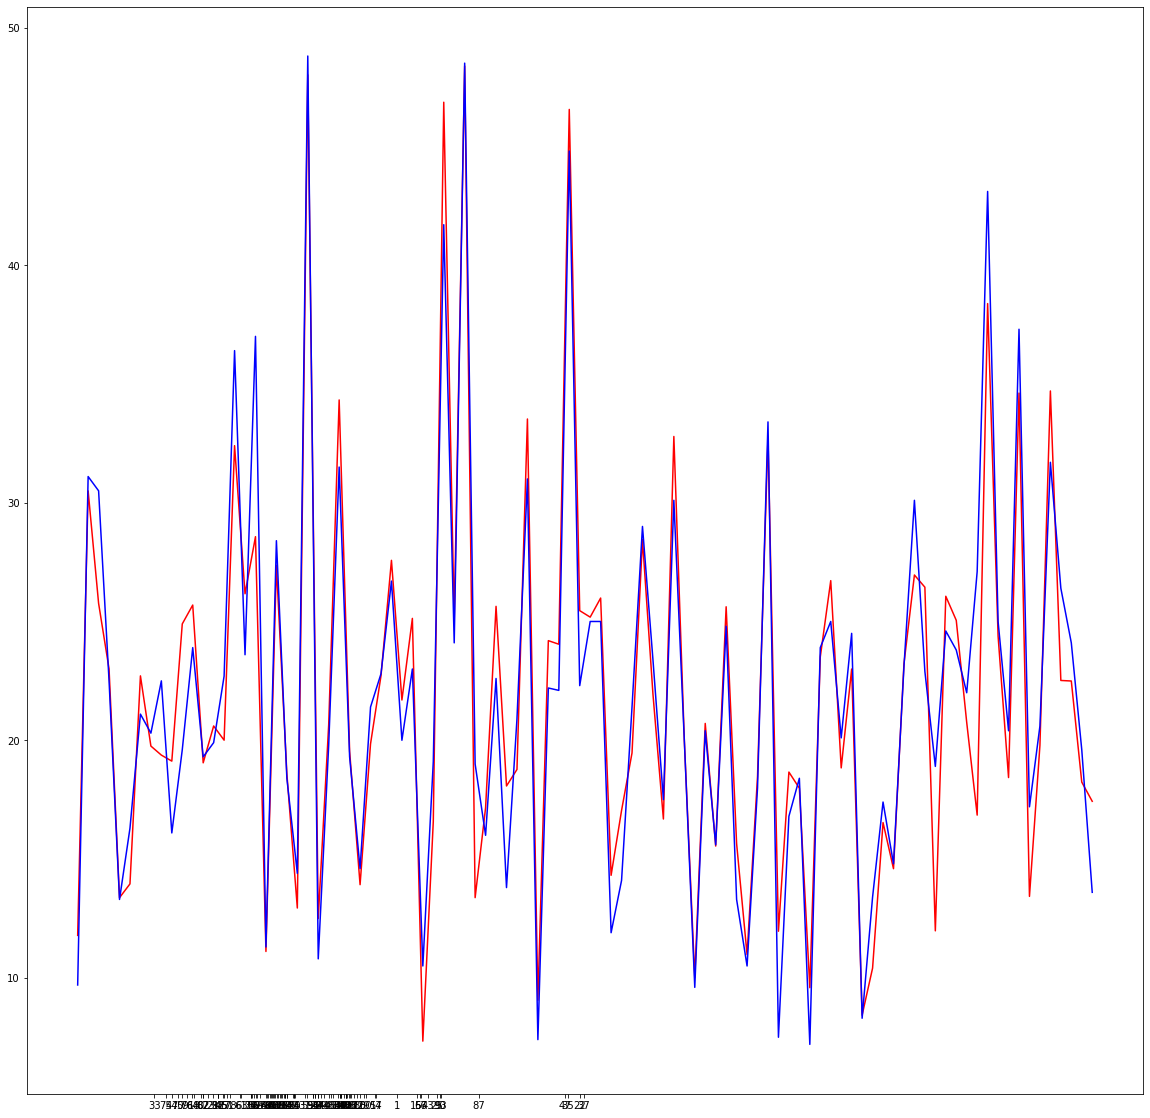

In [167]:
# plot predicted vs real vales
pyplt.xticks(final_predicted_V_real_df['Prediction'], final_predicted_V_real_df.index.values ) # location, labels
ax = pyplt.plot(final_predicted_V_real_df['Prediction'], c="red") # PREDICTED VALUES
ax = pyplt.plot(final_predicted_V_real_df['Real_value'], c="blue") # REAL VALUES
pyplt.show()

# 5. References

[1] Brownlee, J. (2019). How to Configure the Number of Layers and Nodes in a Neural Network. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/ [Accessed 27 Nov. 2019].

[2] Faqs.org. (2019). comp.ai.neural-nets FAQ, Part 3 of 7: GeneralizationSection - How many hidden layers should I use?. [online] Available at: http://www.faqs.org/faqs/ai-faq/neural-nets/part3/section-9.html [Accessed 27 Nov. 2019].

[3] Faqs.org. (2019). comp.ai.neural-nets FAQ, Part 3 of 7: GeneralizationSection - How many hidden units should I use?. [online] Available at: http://www.faqs.org/faqs/ai-faq/neural-nets/part3/section-10.html [Accessed 27 Nov. 2019].

[4] Learning, D. and Them?, F. (2019). Fundamentals of Deep Learning - Activation Functions and their use. [online] Analytics Vidhya. Available at: https://www.analyticsvidhya.com/blog/2017/10/fundamentals-deep-learning-activation-functions-when-to-use-them/ [Accessed 27 Nov. 2019].

[5] Medium. (2019). Activation functions and it’s types-Which is better?. [online] Available at: https://towardsdatascience.com/activation-functions-and-its-types-which-is-better-a9a5310cc8f [Accessed 27 Nov. 2019].

[6] Gupta, V. (2019). Deep learning using Keras - The Basics | Learn OpenCV. [online] Learnopencv.com. Available at: https://www.learnopencv.com/deep-learning-using-keras-the-basics/ [Accessed 27 Nov. 2019].

[7] Brownlee, J. (2019). A Gentle Introduction to the Rectified Linear Unit (ReLU). [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/ [Accessed 27 Nov. 2019].

[8] Sebastian Ruder. (2019). An overview of gradient descent optimization algorithms. [online] Available at: https://ruder.io/optimizing-gradient-descent/index.html#conclusion [Accessed 27 Nov. 2019].

[9] Brownlee, J. (2019). Gentle Introduction to the Adam Optimization Algorithm for Deep Learning. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/ [Accessed 27 Nov. 2019].

[10] Algorithmia Blog. (2019). Introduction to Optimizers | Algorithmia Blog. [online] Available at: https://algorithmia.com/blog/introduction-to-optimizers [Accessed 27 Nov. 2019].

[11] Medium. (2019). Epoch vs Batch Size vs Iterations. [online] Available at: https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9 [Accessed 27 Nov. 2019].

[12] Brownlee, J. (2019). A Gentle Introduction to Mini-Batch Gradient Descent and How to Configure Batch Size. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/ [Accessed 27 Nov. 2019].

[13] Brownlee, J. (2019). An Introduction to Feature Selection. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/an-introduction-to-feature-selection/ [Accessed 4 Dec. 2019].

[14] Chandrayan, P. (2019). Hypothesis Testing Using T Test : Inferential Statistics Part3. [online] Medium. Available at: https://towardsdatascience.com/hypothesis-testing-using-t-test-inferential-statistics-part3-6fb43683bc32 [Accessed 12 Dec. 2019].

[15] Brownlee, J. (2019). A Gentle Introduction to Normality Tests in Python. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/ [Accessed 30 Oct. 2019].